In [76]:
import pandas as pd
import numpy as np
import timeit
from sklearnex import patch_sklearn
patch_sklearn(global_patch = True)
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import pickle
import scipy.stats as stats
import seaborn as sns
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from skopt import BayesSearchCV
import shap

# Loading the dataset
df = pd.read_csv(r'data_with_new_features.csv', delimiter = ',')

Scikit-learn was successfully globally patched by Intel(R) Extension for Scikit-learn


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [233]:
df

Admission grade  Age at enrollment  Curricular units 1st sem (credited)  \
0               127.3           3.044522                                  0.0   
1               142.5           2.995732                                  0.0   
2               124.8           2.995732                                  0.0   
3               119.6           3.044522                                  0.0   
4               141.5           3.828641                                  0.0   
...               ...                ...                                  ...   
4419            122.2           2.995732                                  0.0   
4420            119.0           2.944439                                  0.0   
4421            149.5           3.433987                                  0.0   
4422            153.8           3.044522                                  0.0   
4423            152.0           3.135494                                  0.0   

      Curricular units 1st sem (enrolled)  \
0                                0.000000   
1                                1.945910   
2                                1.945910   
3                                1.945910   
4                                1.945910   
...                                   ...   
4419                             1.945910   
4420                             1.945910   
4421                             2.079442   
4422                             1.791759   
4423                             1.945910   

      Curricular units 1st sem (evaluations)  \
0                                        0.0   
1                                        6.0   
2                                        0.0   
3                                        8.0   
4                                        9.0   
...                                      ...   
4419                                     7.0   
4420                                     6.0   
4421                                     8.0   
4422                                     5.0   
4423                                     8.0   

      Curricular units 1st sem (approved)  \
0                                     0.0   
1                                     6.0   
2                                     0.0   
3                                     6.0   
4                                     5.0   
...                                   ...   
4419                                  5.0   
4420                                  6.0   
4421                                  7.0   
4422                                  5.0   
4423                                  6.0   

      Curricular units 1st sem (without evaluations)  \
0                                                0.0   
1                                                0.0   
2                                                0.0   
3                                                0.0   
4                                                0.0   
...                                              ...   
4419                                             0.0   
4420                                             0.0   
4421                                             0.0   
4422                                             0.0   
4423                                             0.0   

      Curricular units 2nd sem (credited)  \
0                                     0.0   
1                                     0.0   
2                                     0.0   
3                                     0.0   
4                                     0.0   
...                                   ...   
4419                                  0.0   
4420                                  0.0   
4421                                  0.0   
4422                                  0.0   
4423                                  0.0   

      Curricular units 2nd sem (enrolled)  \
0                                     0.0   
1                                     6.0   
2                        

In [234]:
# Splitting the dataset to hold the independent and target variables where X represents the independent variable and y the target variable.
X = df.drop('Target', axis=1)
y = df['Target']
y = y.replace({'Dropout': 1, 'Enrolled': 0, 'Graduate': 0})

In [235]:
# Splitting the dataset into train, validation and test dataset 60%-20%-20%
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=105)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=105)

In [5]:
x_eval = pd.concat([x_train, x_val])
y_eval = pd.concat([y_train, y_val])

In [6]:
def model_training(clf, X_tr, y_tr, X_te, y_te, phase, svc=False, mv = False):
    '''A function to train a model and evaluate it based on various metrics'''
    #Calculate start time
    start_train = timeit.default_timer()

    #Train the model using the training sets y_pred=clf.predict(X_test)
    clf.fit(X_tr,y_tr)

    #Calculate Stop time for training
    stop_train = timeit.default_timer()
    train_time= stop_train - start_train
    
    
#     #Calculate start time for prediction
#     start = timeit.default_timer()

#     # Predict the model
#     pred_class =clf.predict(X_te)

#     #Calculate Stop time
#     stop = timeit.default_timer()
#     test_time= stop - start
    
    print('Train Time(s):', train_time)

#     #Test time
#     print('Test Time(s):',test_time)
    
    train_pred = clf.predict(X_tr)
    
    train_acc = accuracy_score(y_tr, train_pred)
    
    print('Training Accuracy:  {}%'.format(round(train_acc, 2)*100))
    
    model_evaluation(clf, X_te, y_te, phase,svc, mv)

In [7]:
def model_evaluation(clf, X_te, y_te, phase, svc=False, mv=False):
    print('\n Model Evaluation Result For the {} Phase \n'.format(phase))
    #Calculate start time for prediction
    start = timeit.default_timer()
        # Predict the model
    pred_class =clf.predict(X_te)

    #Calculate Stop time
    stop = timeit.default_timer()
    test_time= stop - start
    
#     print('Train Time(s):', train_time)

    #Test time
    print('Test Time(s):',test_time)
    
#     train_pred = clf.predict(X_tr)
    
#     train_acc = accuracy_score(y_tr, train_pred)
    
#     print('Training Accuracy:  {}%\n'.format(round(train_acc, 2)*100))
    
    accuracy = accuracy_score(y_te, pred_class)
    
    report = classification_report(y_te, pred_class)
    
    print('Accuracy:  {}%\n'.format(round(accuracy, 2)*100))
    
    print(report, '\n')
    
    cf_matrix = confusion_matrix(y_te, pred_class)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(
        value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(
        group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()
    
    if mv:
        pass
    else:
    
        if svc:
            y_pred_proba = clf.decision_function(X_te)
        else:
            y_pred_proba = clf.predict_proba(X_te)[::,1]
        # Calculate False Positive Rate, True Positive Rate, and thresholds
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

        # Calculate the AUC (Area Under the Curve)
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Dashed diagonal line for random guessing
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

In [8]:
def grid_tuning(clf, parameters, train_feat, train_labels, val_feat, val_labels, cv, svc = False):
    grid_search = GridSearchCV(clf, parameters,cv=cv,
                               n_jobs=-1, scoring='accuracy', verbose=1)
    grid_search.fit(train_feat, train_labels)
    model_training(grid_search.best_estimator_, train_feat, train_labels, val_feat, val_labels, phase = 'Tuning', svc = svc)
    return grid_search.best_params_, grid_search.best_estimator_

In [9]:
def random_tuning(clf, parameters, train_feat, n_iter, train_labels, val_feat, val_labels, cv, svc = False):
    random_search = RandomizedSearchCV(
        clf,
        param_distributions=parameters,
        n_iter=n_iter,      # Number of parameter settings to sample
        cv=cv,               # Cross-validation with 5 folds
        scoring='accuracy', # You can also pass other scoring metrics
        random_state= 105,
        n_jobs=-1
    )
    random_search.fit(train_feat, train_labels)
    model_training(random_search.best_estimator_, train_feat, train_labels, val_feat, val_labels, phase = 'Tuning', svc = svc)
    return random_search.best_params_, random_search.best_estimator_


In [10]:
def bayes_tuning(clf, parameters, train_feat, train_labels, val_feat, val_labels, cv, n_iter = 10, svc = False):
    bayes_search = BayesSearchCV(clf, search_spaces = parameters,cv=cv, n_iter = n_iter,
                               n_jobs=-1, scoring='accuracy', verbose=1)
    bayes_search.fit(train_feat, train_labels)
    model_training(bayes_search.best_estimator_, train_feat, train_labels, val_feat, val_labels, phase = 'Tuning', svc = svc)
    return bayes_search.best_params_, bayes_search.best_estimator_

In [11]:
from sklearn.model_selection import cross_val_score

cv = 5
def cross_validation(clf_model, features, labels, cv):
    scores = cross_val_score(
      clf_model, features,
      labels,
      scoring="accuracy", cv=cv)
    acc_scores = scores
    print("Scores:", acc_scores)
    print("Mean:", acc_scores.mean())
    print("StandardDeviation:", acc_scores.std())

In [12]:
def save_model(model, filename):
    try:
        with open(filename, 'wb') as file:
            pickle.dump(model, file)
        print(f"Model saved successfully to {filename}")
    except Exception as e:
        print(f"Error saving model: {e}")


In [13]:
def evaluate_pipeline_with_metrics(pipeline, param_name, param_values, X_train, X_test, y_train, y_test, metrics=['accuracy']):
    results = {metric: [] for metric in metrics}

    # Loop through each hyperparameter value
    for value in param_values:
        pipeline.get_params()['classifier'].set_params(**{param_name: value})
        
        # Fit the model
        pipeline.fit(X_train, y_train)
        
        # Predict on test data
        y_pred = pipeline.predict(X_test)
        
        # Calculate metrics

        results['accuracy'].append(accuracy_score(y_test, y_pred))

    # Plot the results
    sns.set()
    plt.figure(figsize=(10, 6))
    for metric in metrics:
        scores = results[metric]
        plt.plot(param_values, results[metric], marker='o', linestyle='-', label=metric)
            # Annotate each point with the corresponding score value
        for i, score in enumerate(scores):
            plt.annotate(f'{score:.4f}', (param_values[i], scores[i]), textcoords="offset points", xytext=(0,5), ha='center')
    
    plt.xlabel(param_name)
    plt.ylabel('Score')
    plt.title(f'Effect of {param_name} on Model Performance')
    plt.legend()
    plt.grid(True)
    plt.show()

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

# Logistic Regression

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

# Create the pipeline
pipeline_log = Pipeline([
    ('scaler', MinMaxScaler()),  # Step 1: Scale features to a range (0, 1)
    ('classifier', LogisticRegression(random_state = 105))  # Step 2: Apply Logistic Regression
])



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Train Time(s): 0.5172240999963833
Training Accuracy:  88.0%

 Model Evaluation Result For the Training Phase 

Test Time(s): 0.013595600001281127
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       595
           1       0.83      0.74      0.78       290

    accuracy                           0.87       885
   macro avg       0.85      0.83      0.84       885
weighted avg       0.86      0.87      0.86       885
 



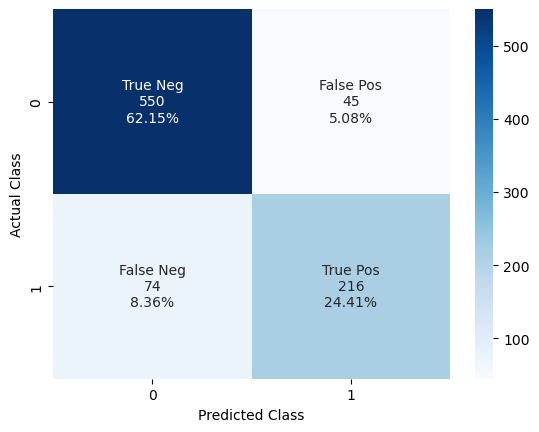

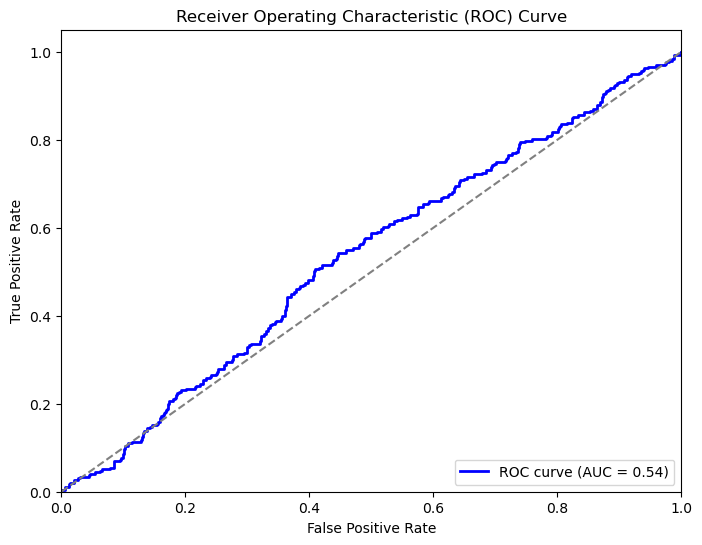

In [16]:
#log = LogisticRegression(max_iter = 10000, random_state = 105)
model_training(pipeline_log, x_train, y_train, x_val, y_val, phase = 'Training')

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


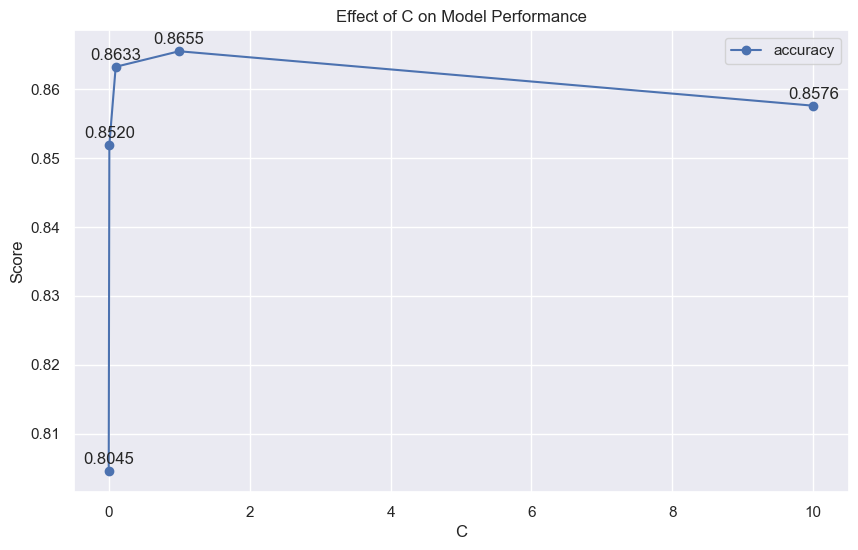

In [17]:
# Define the range of values for the hyperparameter 'C'
param_values = [0.001, 0.01, 0.1, 1, 10]
param_name = 'C'

# Call the function to evaluate and plot the metrics
evaluate_pipeline_with_metrics(pipeline_log, param_name, param_values, x_train, x_val, y_train, y_val, metrics=['accuracy'])

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

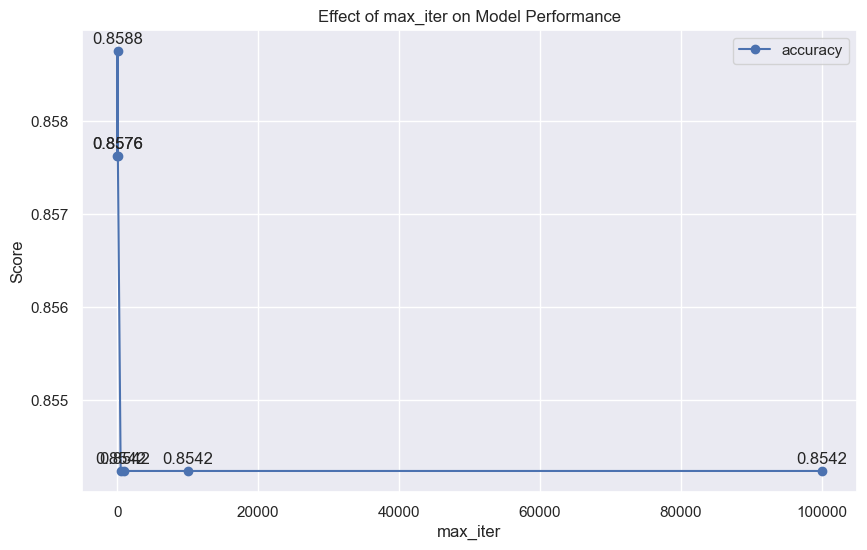

In [18]:
# Define the range of values for the hyperparameter 'C'
param_values = [10, 50, 100, 500, 1000, 10000, 100000]
param_name = 'max_iter'

# Call the function to evaluate and plot the metrics
evaluate_pipeline_with_metrics(pipeline_log, param_name, param_values, x_train, x_val, y_train, y_val, metrics=['accuracy'])

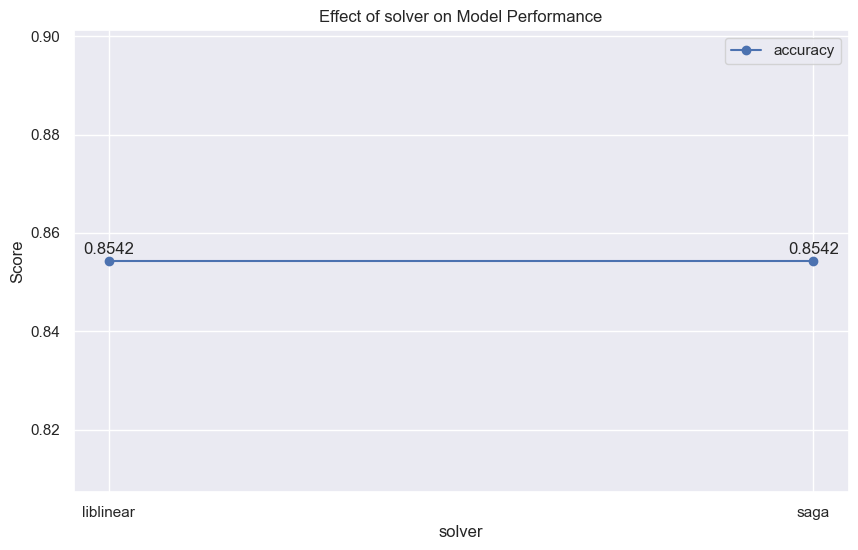

In [19]:
# Define the range of values for the hyperparameter 'C'
param_values = ['liblinear', 'saga']
param_name = 'solver'

# Call the function to evaluate and plot the metrics
evaluate_pipeline_with_metrics(pipeline_log, param_name, param_values, x_train, x_val, y_train, y_val, metrics=['accuracy'])

## Tuning the Logistic Regression Model

### Manual Tuning

In [20]:
# Create the pipeline
pipeline_log_tuned = Pipeline([
    ('scaler', MinMaxScaler()),  # Step 1: Scale features to a range (0, 1)
    ('classifier', LogisticRegression(C = 1, max_iter = 50, solver = 'saga', random_state = 105))  # Step 2: Apply Logistic Regression
])

The max_iter was reached which means the coef_ did not converge


Train Time(s): 0.9568215999970562
Training Accuracy:  88.0%

 Model Evaluation Result For the Training Phase 

Test Time(s): 0.007934599998407066
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       595
           1       0.83      0.74      0.78       290

    accuracy                           0.86       885
   macro avg       0.85      0.83      0.84       885
weighted avg       0.86      0.86      0.86       885
 



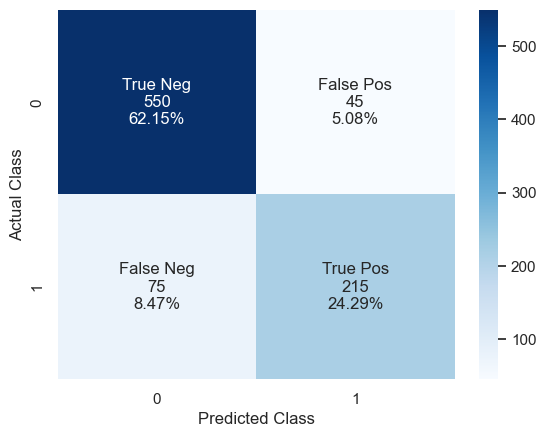

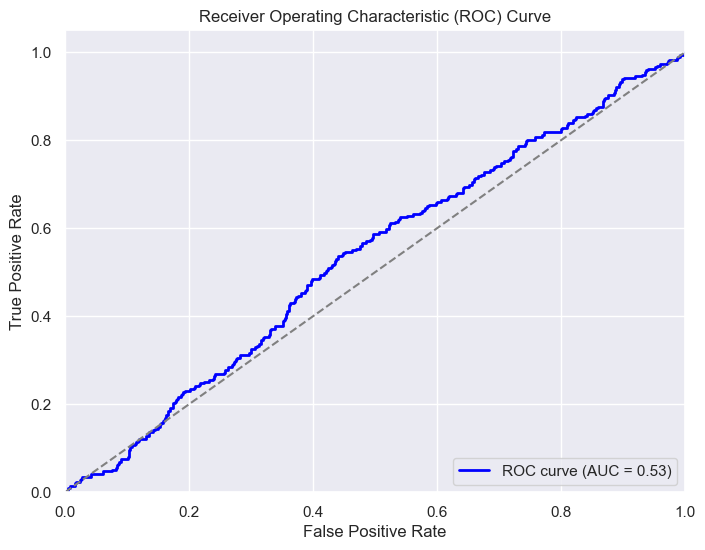

In [57]:
#log = LogisticRegression(max_iter = 10000, random_state = 105)
model_training(pipeline_log_tuned, x_train, y_train, x_val, y_val, phase = 'Training')

In [22]:
#cross_validation(pipeline_log_tuned, x_eval, y_eval, cv)


 Model Evaluation Result For the Test Phase 

Test Time(s): 0.008759700001974124
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       594
           1       0.88      0.71      0.79       291

    accuracy                           0.87       885
   macro avg       0.88      0.83      0.85       885
weighted avg       0.88      0.87      0.87       885
 



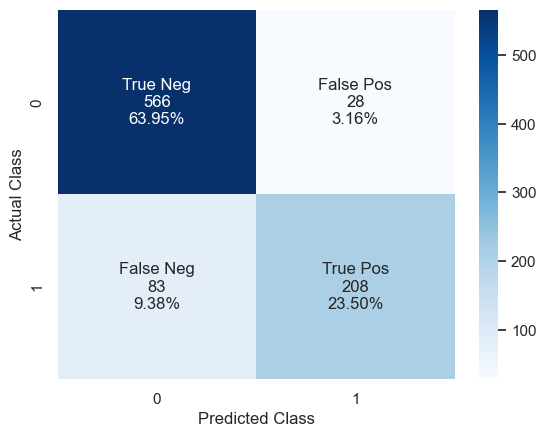

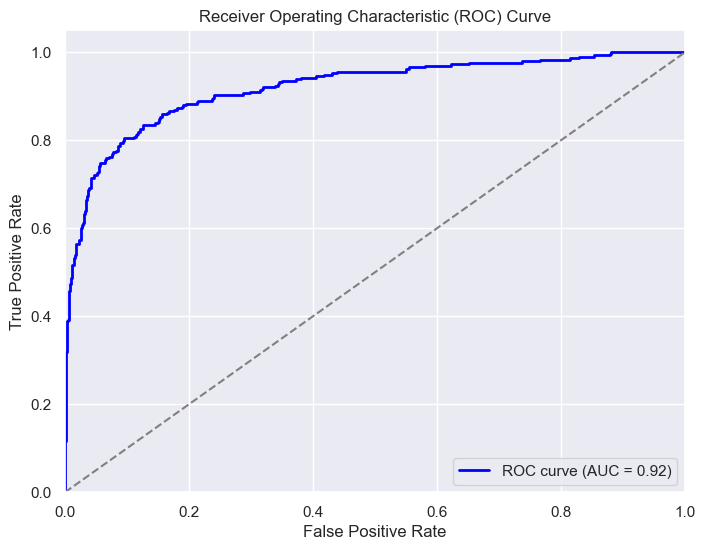

In [23]:
model_evaluation(pipeline_log_tuned, x_test, y_test, phase = 'Test')

### GridSearch

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Train Time(s): 22.392696499999147
Training Accuracy:  89.0%

 Model Evaluation Result For the Tuning Phase 

Test Time(s): 0.010379100000136532
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       595
           1       0.83      0.74      0.78       290

    accuracy                           0.87       885
   macro avg       0.86      0.83      0.84       885
weighted avg       0.86      0.87      0.86       885
 



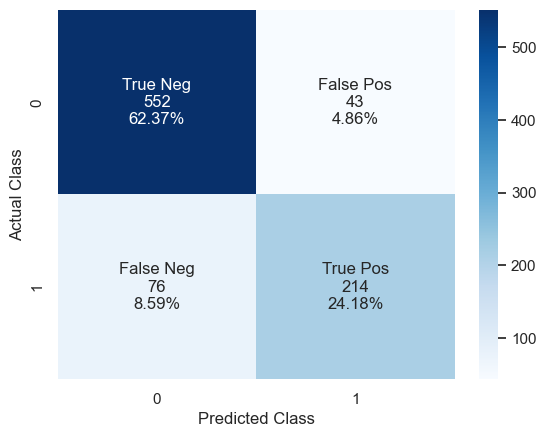

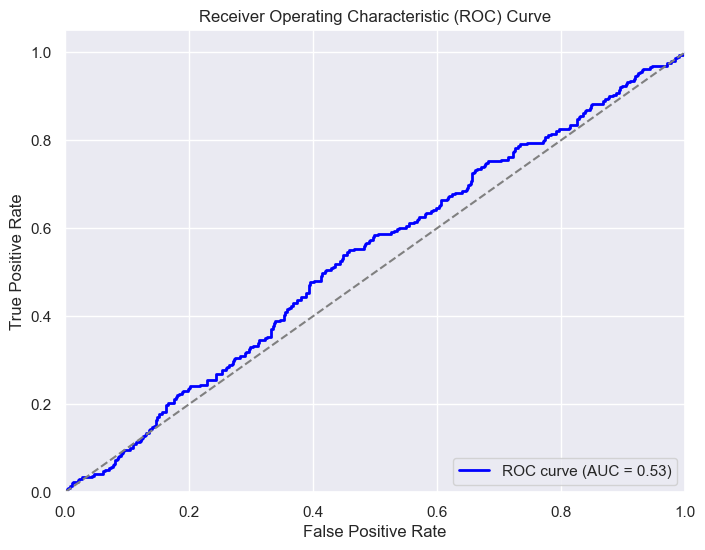

In [24]:
param_grid = {
    'classifier__C': [0.1, 1, 10, 100], 
    'classifier__penalty': ['l1', 'l2'], 
    'classifier__solver': ['liblinear', 'saga', ]
}

best_log_params, best_log_model = grid_tuning(pipeline_log, parameters = param_grid, train_feat = x_train,
                              train_labels = y_train, val_feat = x_val, val_labels = y_val, cv = 5)


In [25]:
best_log_params

{'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}

In [26]:
#cross_validation(best_log_model, x_eval, y_eval, cv)


 Model Evaluation Result For the Test Phase 

Test Time(s): 0.022325199999613687
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       594
           1       0.87      0.71      0.79       291

    accuracy                           0.87       885
   macro avg       0.87      0.83      0.85       885
weighted avg       0.87      0.87      0.87       885
 



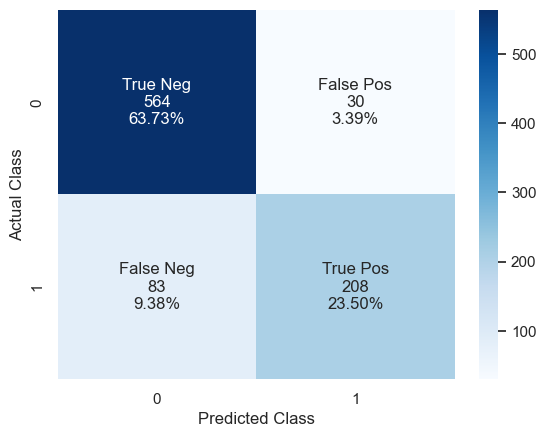

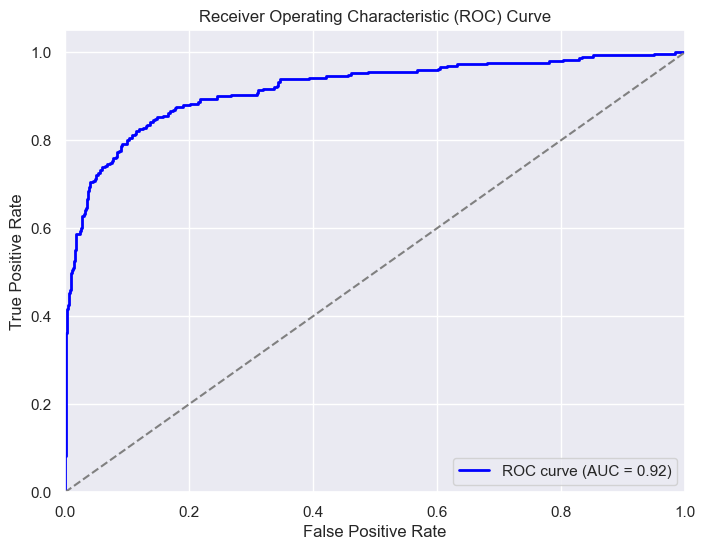

In [27]:
model_evaluation(best_log_model, x_test, y_test, phase = 'Test')

### Random Search

Train Time(s): 0.33557419999851845
Training Accuracy:  89.0%

 Model Evaluation Result For the Tuning Phase 

Test Time(s): 0.00623020000057295
Accuracy:  85.0%

              precision    recall  f1-score   support

           0       0.88      0.91      0.89       595
           1       0.80      0.74      0.77       290

    accuracy                           0.85       885
   macro avg       0.84      0.83      0.83       885
weighted avg       0.85      0.85      0.85       885
 



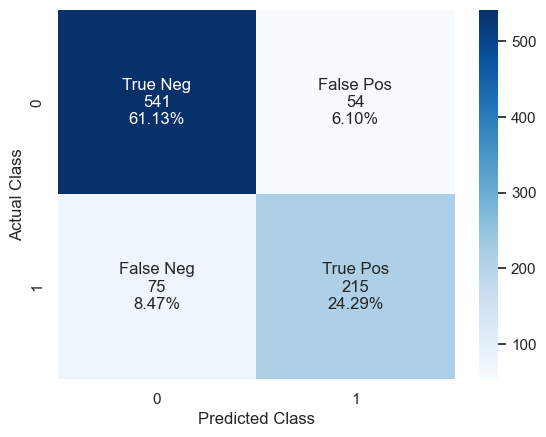

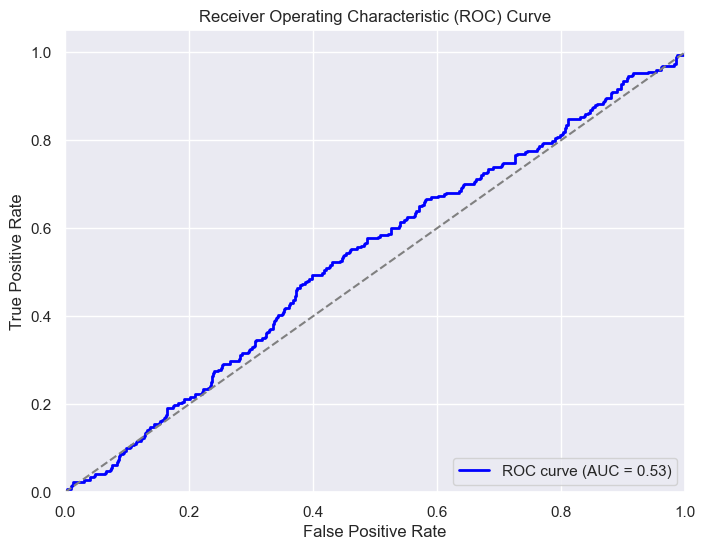

In [28]:
param_distributions = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__max_iter': [50, 100, 200, 300, 500]
}
random_log_params, random_log_model = random_tuning(clf = pipeline_log, parameters= param_distributions, train_feat = x_train, n_iter = 5, train_labels = y_train, val_feat = x_val, val_labels = y_val, cv = 3, svc = False)

In [29]:
random_log_params

{'classifier__solver': 'liblinear',
 'classifier__penalty': 'l2',
 'classifier__max_iter': 50}

In [30]:
#cross_validation(random_log_model, x_eval, y_eval, cv)


 Model Evaluation Result For the Test Phase 

Test Time(s): 0.01223279999976512
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       594
           1       0.87      0.71      0.78       291

    accuracy                           0.87       885
   macro avg       0.87      0.83      0.85       885
weighted avg       0.87      0.87      0.87       885
 



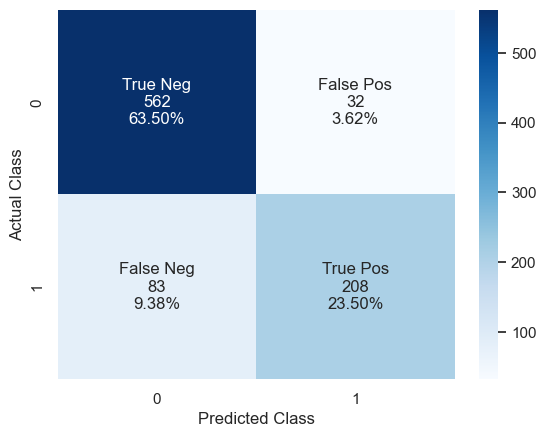

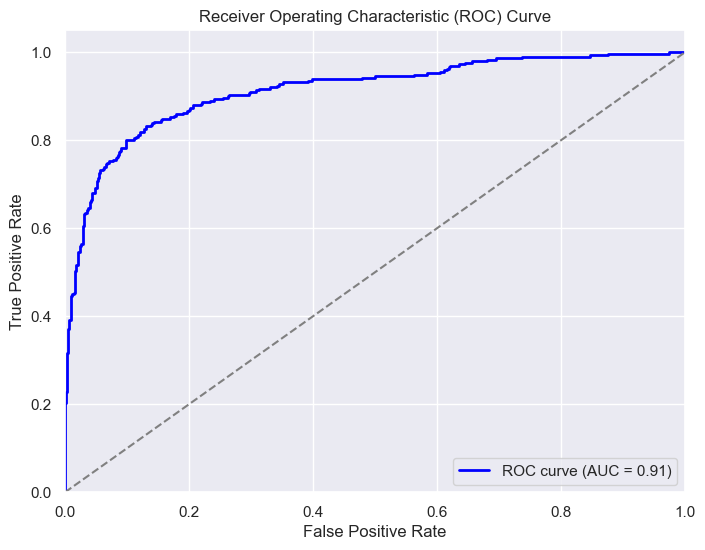

In [31]:
model_evaluation(random_log_model, x_test, y_test, phase = 'Test')

### Bayes Search

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Train Time(s): 0.46876850000262493
Training Accuracy:  89.0%

 Model Evaluation Result For the Tuning Phase 

Test Time(s): 0.010469200002262369
Accuracy:  85.0%

              precision    recall  f1-score   support

           0       0.88      0.91      0.89       595
           1       0.80      0.74      0.77       290

    accuracy                           0.85       885
   macro avg       0.84      

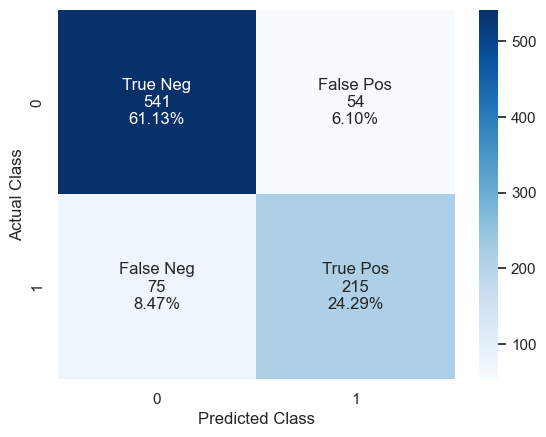

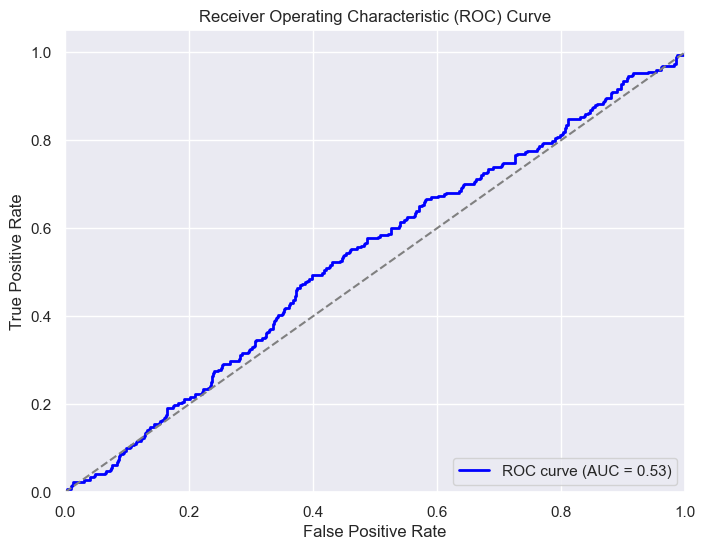

In [32]:
param_distributions = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__max_iter': [50, 100, 200, 300, 500]
}
bayes_log_params, bayes_log_model = bayes_tuning(clf = pipeline_log, parameters= param_distributions, train_feat = x_train, train_labels = y_train, val_feat = x_val, val_labels = y_val, cv = 3, svc = False)

In [33]:
bayes_log_params

OrderedDict([('classifier__max_iter', 50),
             ('classifier__penalty', 'l2'),
             ('classifier__solver', 'liblinear')])

In [34]:
#cross_validation(bayes_log_model, x_eval, y_eval, cv)


 Model Evaluation Result For the Test Phase 

Test Time(s): 0.008523099997546524
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       594
           1       0.87      0.71      0.78       291

    accuracy                           0.87       885
   macro avg       0.87      0.83      0.85       885
weighted avg       0.87      0.87      0.87       885
 



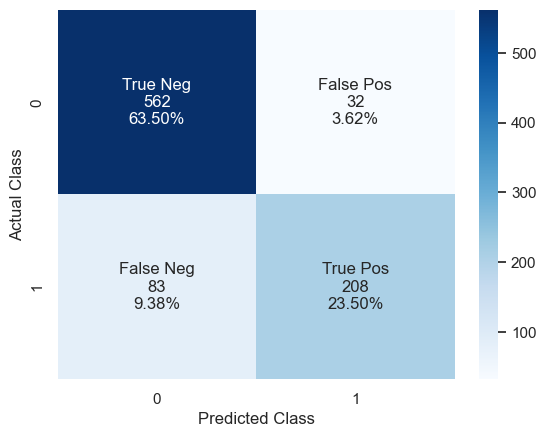

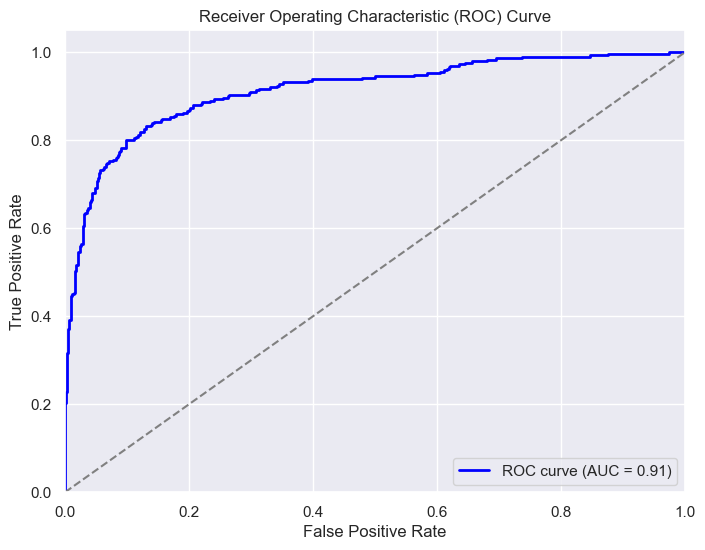

In [35]:
model_evaluation(bayes_log_model, x_test, y_test, phase = 'Test')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


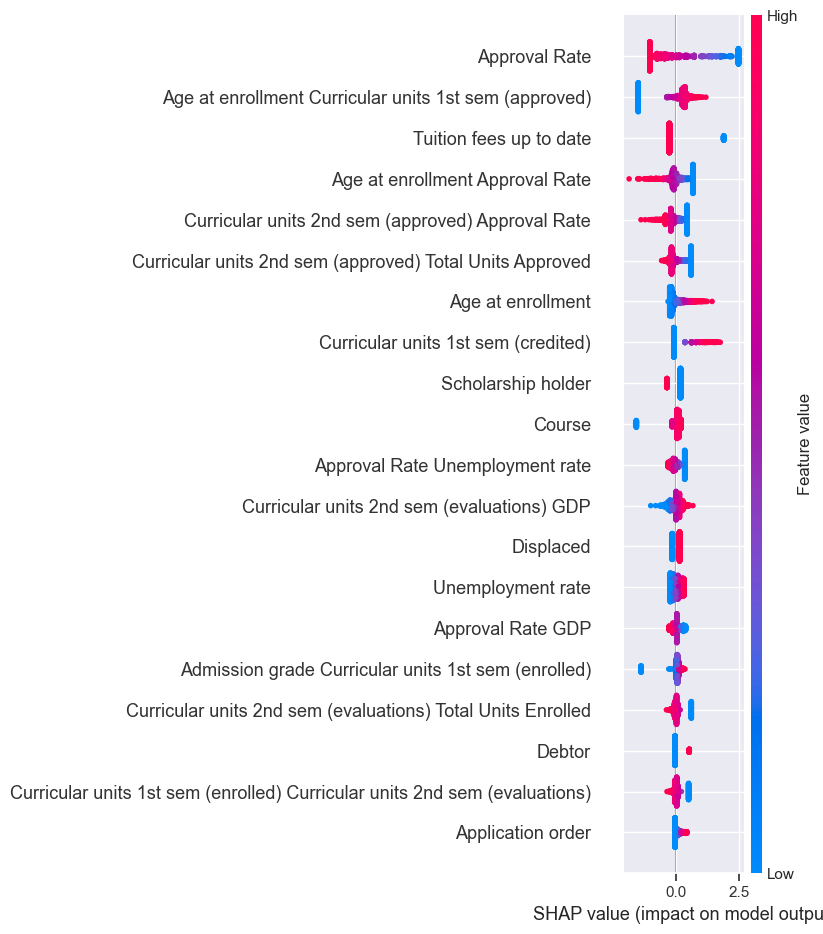

In [259]:
import shap
import matplotlib.pyplot as plt

def shap_explanations(pipeline, X_train, y_train, X_test, feature_names):

    # Train the pipeline on the data
    pipeline.fit(X_train, y_train)

    # Create a SHAP explainer for the classifier in the pipeline
    explainer = shap.Explainer(pipeline.named_steps['classifier'], pipeline.named_steps['scaler'].transform(X_train), check_additivity=False)

    # Get SHAP values for the test dataset
    shap_values = explainer.shap_values(pipeline.named_steps['scaler'].transform(X_test))

    # Plot SHAP summary plot
    shap.summary_plot(shap_values, pipeline.named_steps['scaler'].transform(X_test), feature_names=feature_names)
    plt.show()

    return shap_values

shap_values = shap_explanations(best_log_model, x_train, y_train, x_test, x_train.columns)


In [68]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay

def create_pdp(model, X, features, algo, grid_resolution=100):
    
    
    # Create the partial dependence plot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Use PartialDependenceDisplay to plot the PDP
    display = PartialDependenceDisplay.from_estimator(
        model,
        X,
        features=features,
        grid_resolution=grid_resolution,
        ax=ax
    )
    
    # Set plot title and show the plot
    fig = plt.gcf()
    fig.suptitle('Partial dependence of Various Features\n'
             'for the Student dropout using {}'.format(algo))
    fig.subplots_adjust(hspace=0.3)
    plt.subplots_adjust(top=0.85)  # Adjust the top space for the title
    plt.show()



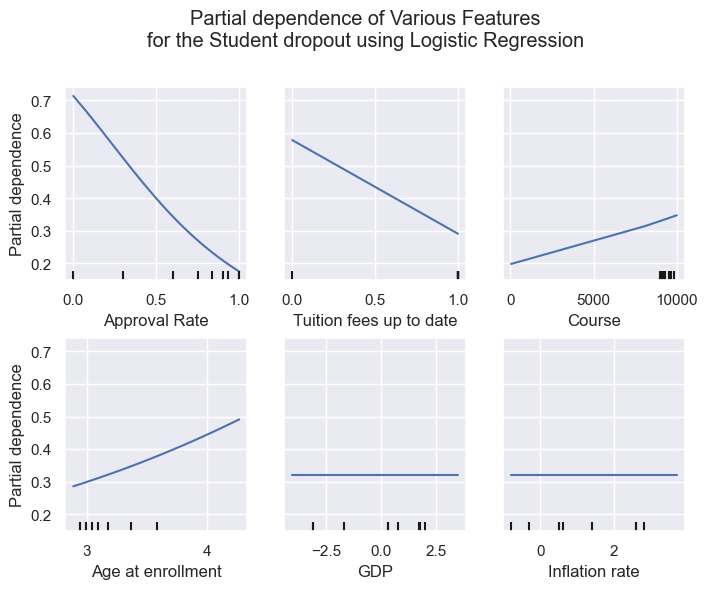

In [71]:
create_pdp(best_log_model, x_test, ['Approval Rate', 'Tuition fees up to date', 'Course', 'Age at enrollment', 'GDP', 'Inflation rate'], algo = 'Logistic Regression')

In [266]:
save_model(best_log_model, 'grid_logistic_regression.pkl')
save_model(random_log_model, 'random_logistic_regression.pkl')
save_model(bayes_log_model, 'bayes_logistic_regression.pkl')
save_model(pipeline_log_tuned, 'manual_logistic_regression.pkl')

Model saved successfully to grid_logistic_regression.pkl
Model saved successfully to random_logistic_regression.pkl
Model saved successfully to bayes_logistic_regression.pkl
Model saved successfully to manual_logistic_regression.pkl


## Decision Tree Classifier

In [73]:
# Create the pipeline
pipeline_dt = Pipeline([
    ('scaler', MinMaxScaler()),  # Step 1: Scale features to a range (0, 1)
    ('classifier', DecisionTreeClassifier(random_state = 105))  # Step 2: Apply Logistic Regression
])

Train Time(s): 0.7184672000003047
Training Accuracy:  100.0%

 Model Evaluation Result For the Training Phase 

Test Time(s): 0.008931600001233164
Accuracy:  80.0%

              precision    recall  f1-score   support

           0       0.86      0.85      0.85       595
           1       0.69      0.71      0.70       290

    accuracy                           0.80       885
   macro avg       0.78      0.78      0.78       885
weighted avg       0.80      0.80      0.80       885
 



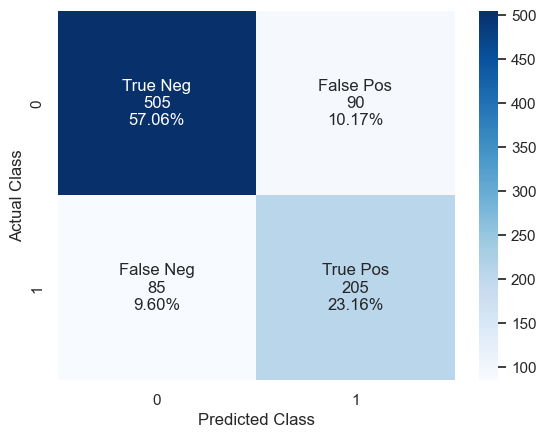

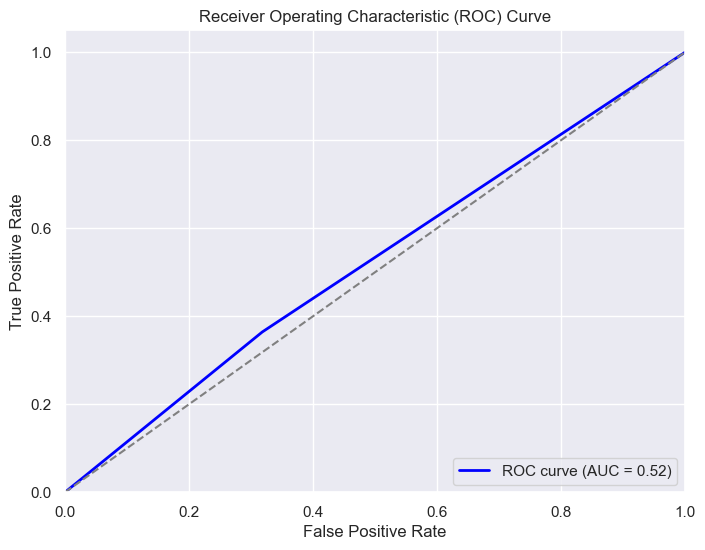

In [77]:
model_training(pipeline_dt, x_train, y_train, x_val, y_val, phase = 'Training')

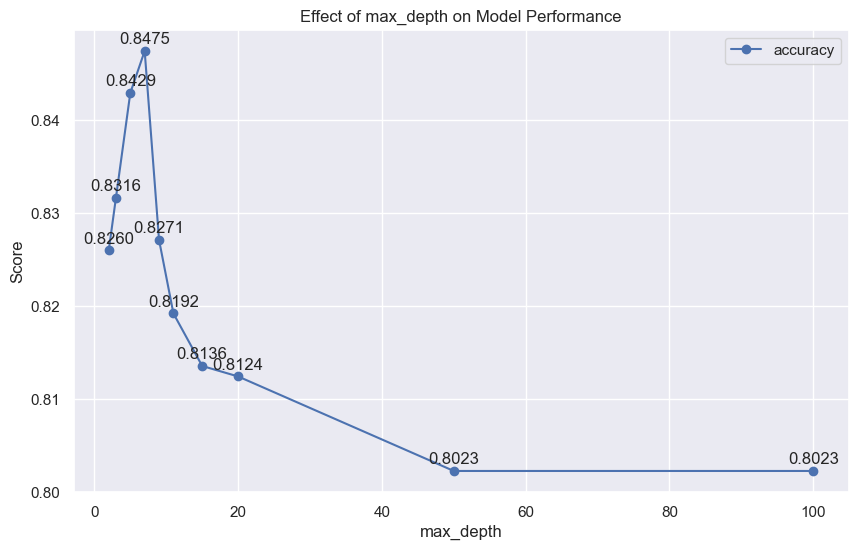

In [78]:
# Define the range of values for the hyperparameter 'max_depth'
param_values = [2, 3, 5, 7, 9, 11, 15, 20, 50, 100]
param_name = 'max_depth'

# Call the function to evaluate and plot the metrics
evaluate_pipeline_with_metrics(pipeline_dt, param_name, param_values, x_train, x_val, y_train, y_val, metrics=['accuracy'])

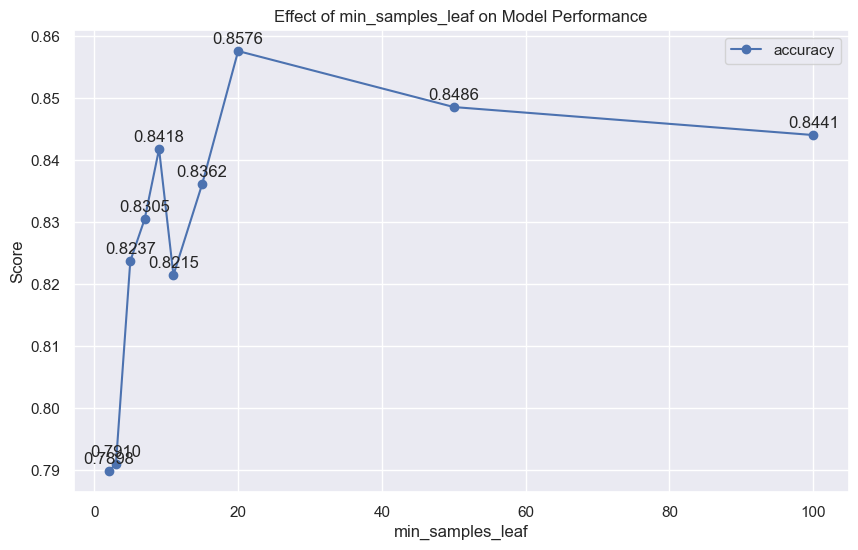

In [79]:
# Define the range of values for the hyperparameter 'min_samples_leaf'
param_values = [2, 3, 5, 7, 9, 11, 15, 20, 50, 100]
param_name = 'min_samples_leaf'

# Call the function to evaluate and plot the metrics
evaluate_pipeline_with_metrics(pipeline_dt, param_name, param_values, x_train, x_val, y_train, y_val, metrics=['accuracy'])

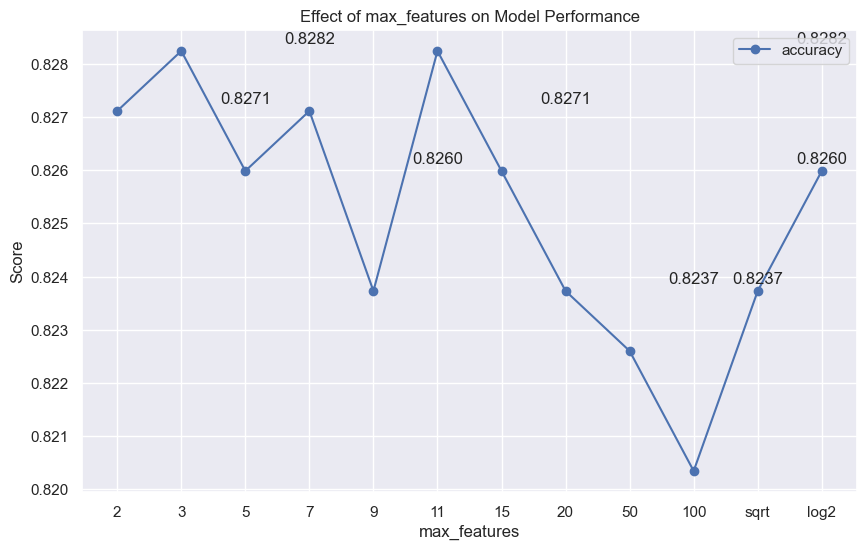

In [80]:
# Define the range of values for the hyperparameter 'max_features'
param_values = [2, 3, 5, 7, 9, 11, 15, 20, 50, 100, 'sqrt', 'log2']
param_name = 'max_features'

# Call the function to evaluate and plot the metrics
evaluate_pipeline_with_metrics(pipeline_dt, param_name, param_values, x_train, x_val, y_train, y_val, metrics=['accuracy'])

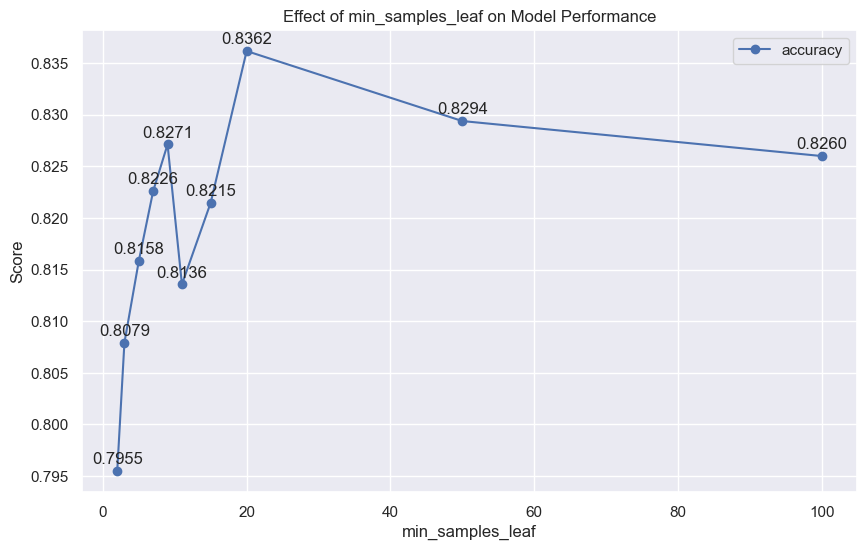

In [81]:
# Define the range of values for the hyperparameter 'min_samples_leaf'
param_values = [2, 3, 5, 7, 9, 11, 15, 20, 50, 100]
param_name = 'min_samples_leaf'

# Call the function to evaluate and plot the metrics
evaluate_pipeline_with_metrics(pipeline_dt, param_name, param_values, x_train, x_val, y_train, y_val, metrics=['accuracy'])

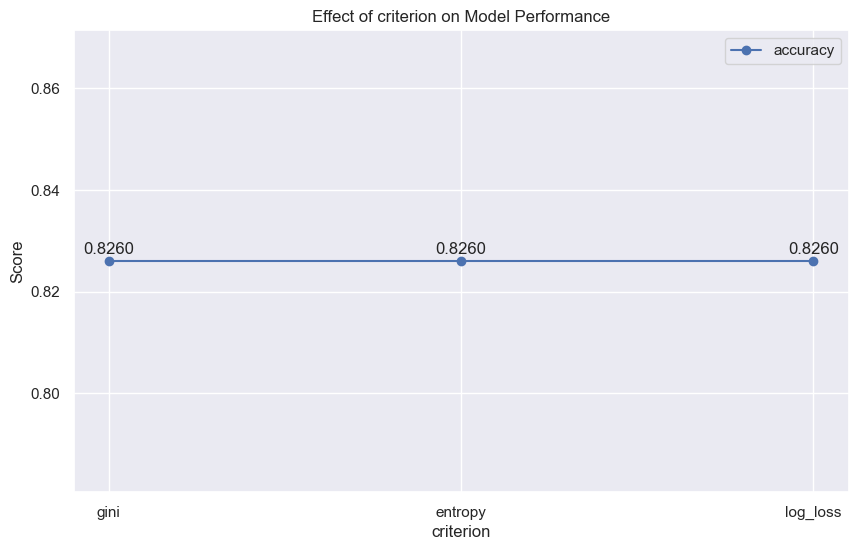

In [82]:
# Define the range of values for the hyperparameter 'n_estimators'
param_values = ['gini', 'entropy', 'log_loss']
param_name = 'criterion'

# Call the function to evaluate and plot the metrics
evaluate_pipeline_with_metrics(pipeline_dt, param_name, param_values, x_train, x_val, y_train, y_val, metrics=['accuracy'])

## Manual Tuning

In [85]:
pipeline_dt_tuned = Pipeline([
    ('scaler', MinMaxScaler()),  # Step 1: Scale features to a range (0, 1)
    ('classifier', DecisionTreeClassifier(max_depth = 7, min_samples_split = 7,
                                          max_features = 11, min_samples_leaf = 20,
                                          random_state = 105))  # Step 2: Apply Logistic Regression
])

Train Time(s): 0.048275199995259754
Training Accuracy:  86.0%

 Model Evaluation Result For the Training Phase 

Test Time(s): 0.009372199994686525
Accuracy:  83.0%

              precision    recall  f1-score   support

           0       0.85      0.90      0.88       595
           1       0.77      0.67      0.72       290

    accuracy                           0.83       885
   macro avg       0.81      0.79      0.80       885
weighted avg       0.82      0.83      0.82       885
 



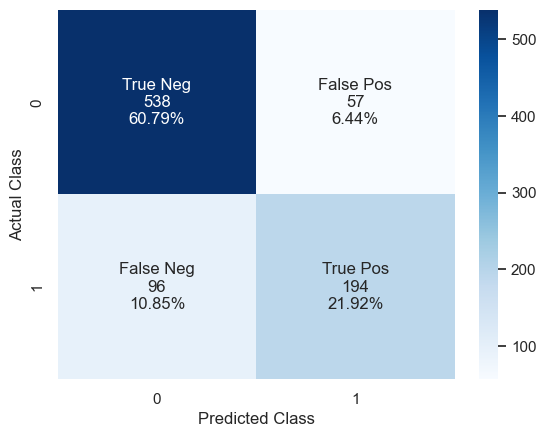

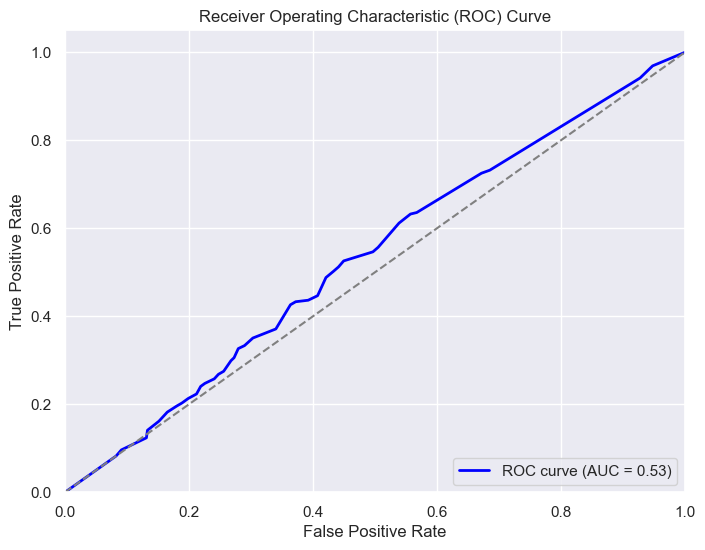

In [87]:
model_training(pipeline_dt_tuned, x_train, y_train, x_val, y_val, phase = 'Training')


 Model Evaluation Result For the Test Phase 

Test Time(s): 0.01531010000326205
Accuracy:  83.0%

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       594
           1       0.80      0.65      0.72       291

    accuracy                           0.83       885
   macro avg       0.82      0.79      0.80       885
weighted avg       0.83      0.83      0.83       885
 



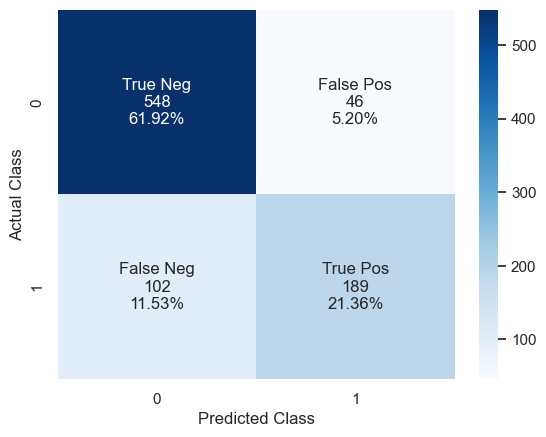

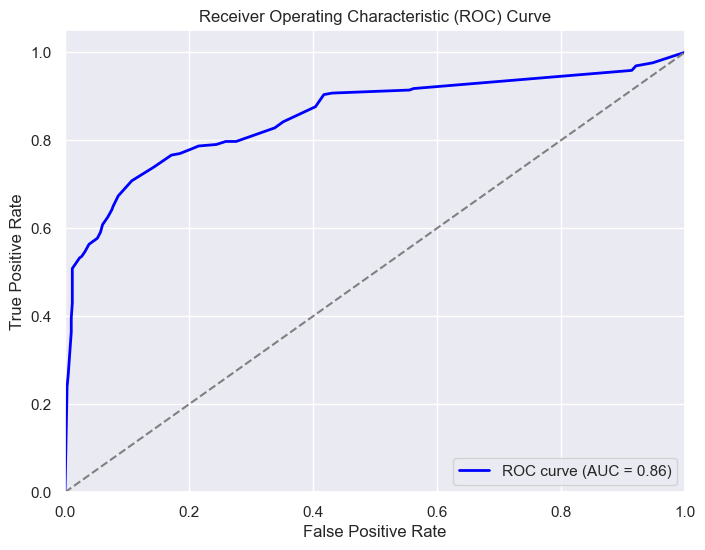

In [88]:
model_evaluation(pipeline_dt_tuned, x_test, y_test, phase = 'Test', svc = False)

## Grid Search

Fitting 3 folds for each of 480 candidates, totalling 1440 fits
Train Time(s): 0.04182750000472879
Training Accuracy:  88.0%

 Model Evaluation Result For the Tuning Phase 

Test Time(s): 0.007836900003894698
Accuracy:  83.0%

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       595
           1       0.77      0.70      0.73       290

    accuracy                           0.83       885
   macro avg       0.81      0.80      0.80       885
weighted avg       0.83      0.83      0.83       885
 



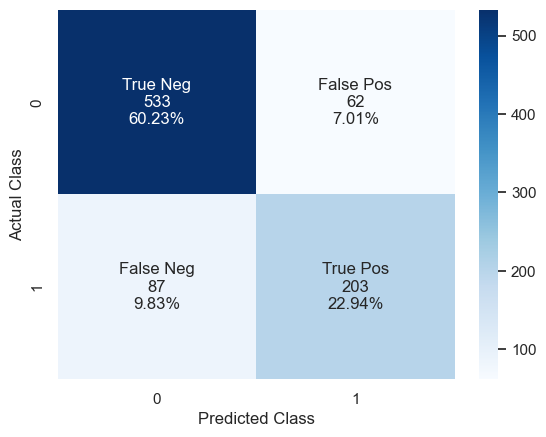

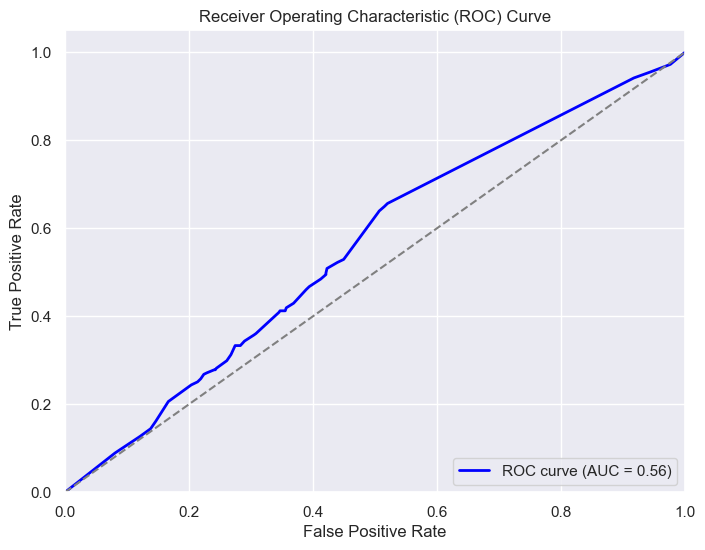

In [89]:
param_grid_dt = {
    "classifier__min_samples_split": [2, 3, 5, 7],
    "classifier__max_depth": [5, 7, 9, 15],
    "classifier__min_samples_leaf": [2, 3, 7, 9, 11],
    "classifier__max_features": [None, 'sqrt', 'log2'],
    "classifier__criterion": ['gini', 'entropy']
}
grid_dt_params, grid_dt_model = grid_tuning(pipeline_dt, parameters = param_grid_dt, train_feat = x_train,
                              train_labels = y_train, val_feat = x_val, val_labels = y_val, cv = 3)

In [90]:
grid_dt_params

{'classifier__criterion': 'gini',
 'classifier__max_depth': 7,
 'classifier__max_features': 'log2',
 'classifier__min_samples_leaf': 7,
 'classifier__min_samples_split': 2}

In [54]:
#cross_validation(grid_dt_model, x_eval, y_eval, cv)


 Model Evaluation Result For the Test Phase 

Test Time(s): 0.016092800004116725
Accuracy:  83.0%

              precision    recall  f1-score   support

           0       0.85      0.90      0.88       594
           1       0.77      0.67      0.72       291

    accuracy                           0.83       885
   macro avg       0.81      0.79      0.80       885
weighted avg       0.83      0.83      0.82       885
 



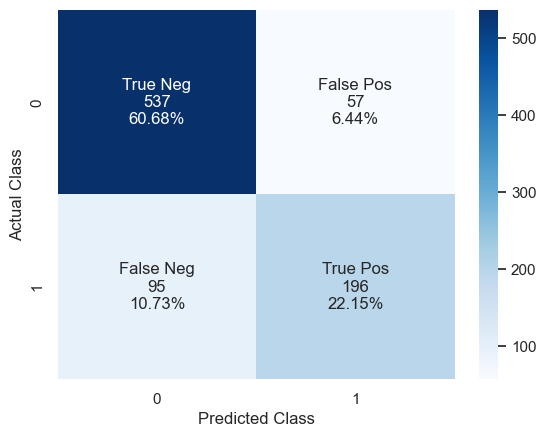

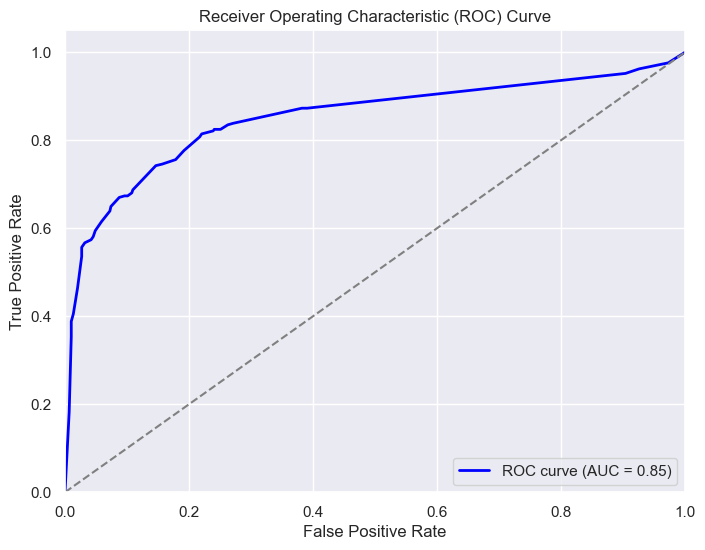

In [91]:
model_evaluation(grid_dt_model, x_test, y_test, phase = 'Test')

## Random Search

Train Time(s): 0.18252290000236826
Training Accuracy:  88.0%

 Model Evaluation Result For the Tuning Phase 

Test Time(s): 0.008362900000065565
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       595
           1       0.83      0.70      0.76       290

    accuracy                           0.86       885
   macro avg       0.85      0.82      0.83       885
weighted avg       0.85      0.86      0.85       885
 



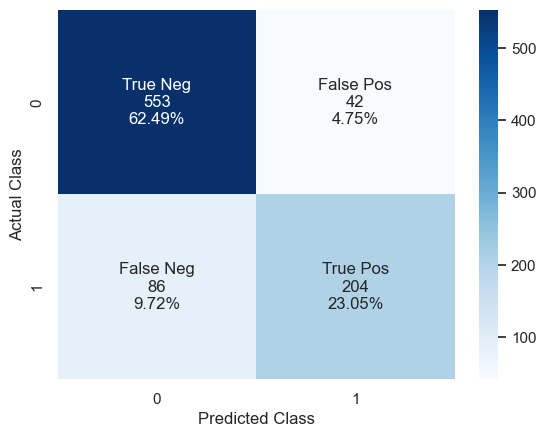

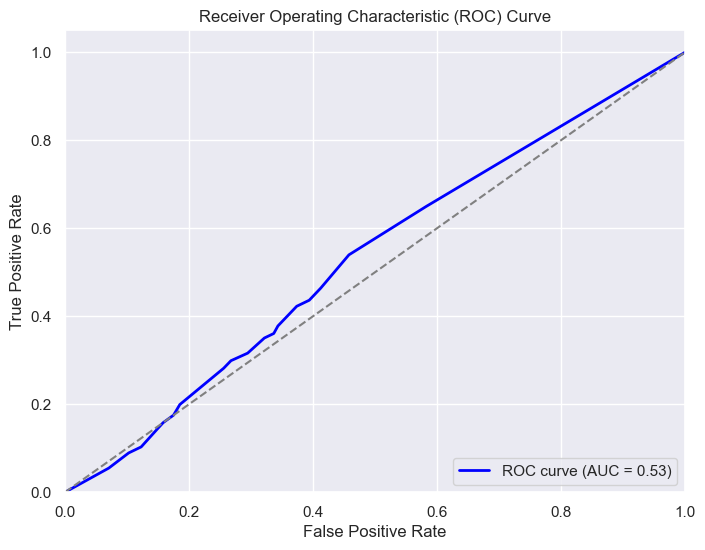

In [92]:
param_dist_dt = {
    "classifier__min_samples_split": [2, 3, 5, 7, 11, 15, 20, 25],
    "classifier__max_depth": [5, 7, 9, 15, 20, 25, 30, 50],
    "classifier__min_samples_leaf": [2, 3, 7, 9, 11, 13, 15, 17, 25, 30, 40, 50],
    "classifier__max_features": [None, 'sqrt', 'log2'],
    "classifier__criterion": ['gini', 'entropy']
}
random_dt_params, random_dt_model = random_tuning(clf = pipeline_dt, parameters= param_dist_dt, train_feat = x_train, n_iter = 5, train_labels = y_train, val_feat = x_val, val_labels = y_val, cv = 3, svc = False)

In [93]:
random_dt_params

{'classifier__min_samples_split': 3,
 'classifier__min_samples_leaf': 30,
 'classifier__max_features': None,
 'classifier__max_depth': 5,
 'classifier__criterion': 'gini'}


 Model Evaluation Result For the Test Phase 

Test Time(s): 0.01269029999821214
Accuracy:  85.0%

              precision    recall  f1-score   support

           0       0.85      0.95      0.90       594
           1       0.86      0.66      0.75       291

    accuracy                           0.85       885
   macro avg       0.86      0.80      0.82       885
weighted avg       0.86      0.85      0.85       885
 



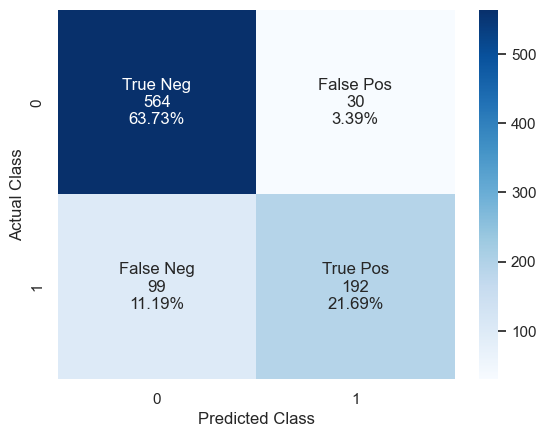

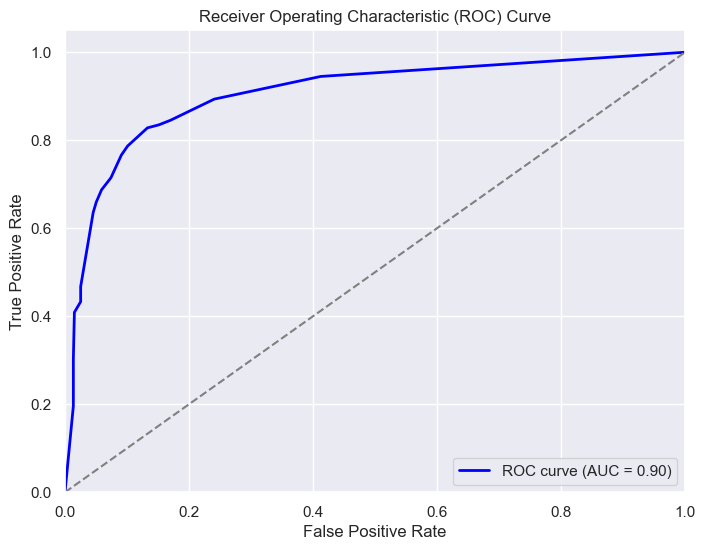

In [94]:
model_evaluation(random_dt_model, x_test, y_test, phase = 'Test')

## Bayes Search

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Train Time(s): 0.2203873000034946
Training Accuracy:  88.0%

 Model Evaluation Result For the Tuning Phase 

Test Time(s): 0.013577500001701992
Accuracy:  85.0%

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       595
           1       0.80      0.71      0.76       290

    accuracy                           0.85       885
   macro avg       0.83      0

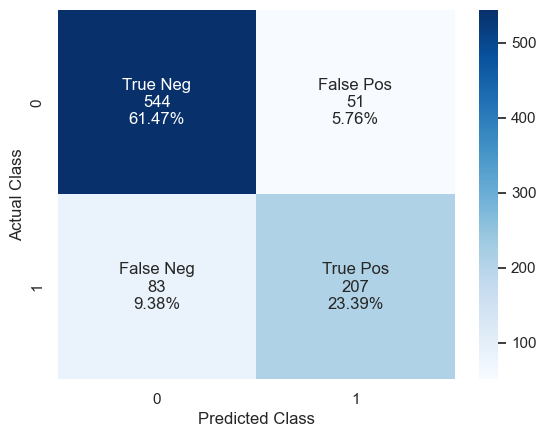

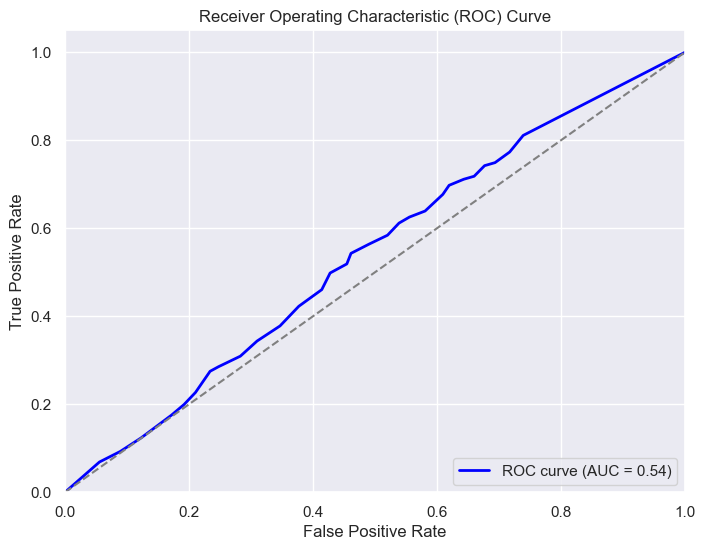

In [95]:
param_dist_dt = {
    "classifier__min_samples_split": [2, 3, 5, 7, 11, 15, 20, 25],
    "classifier__max_depth": [5, 7, 9, 15, 20, 25, 30, 50],
    "classifier__min_samples_leaf": [2, 3, 7, 9, 11, 13, 15, 17, 25, 30, 40, 50],
    "classifier__max_features": [None, 'sqrt', 'log2'],
    "classifier__criterion": ['gini', 'entropy']
}
bayes_dt_params, bayes_dt_model = bayes_tuning(clf = pipeline_dt, parameters= param_dist_dt, train_feat = x_train, train_labels = y_train, val_feat = x_val, val_labels = y_val, cv = 3, svc = False)

In [96]:
bayes_dt_params

OrderedDict([('classifier__criterion', 'gini'),
             ('classifier__max_depth', 20),
             ('classifier__max_features', None),
             ('classifier__min_samples_leaf', 50),
             ('classifier__min_samples_split', 25)])


 Model Evaluation Result For the Test Phase 

Test Time(s): 0.016555899994273204
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       594
           1       0.84      0.71      0.77       291

    accuracy                           0.86       885
   macro avg       0.85      0.82      0.83       885
weighted avg       0.86      0.86      0.86       885
 



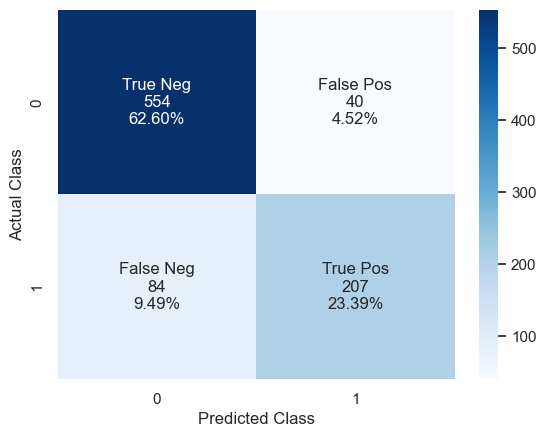

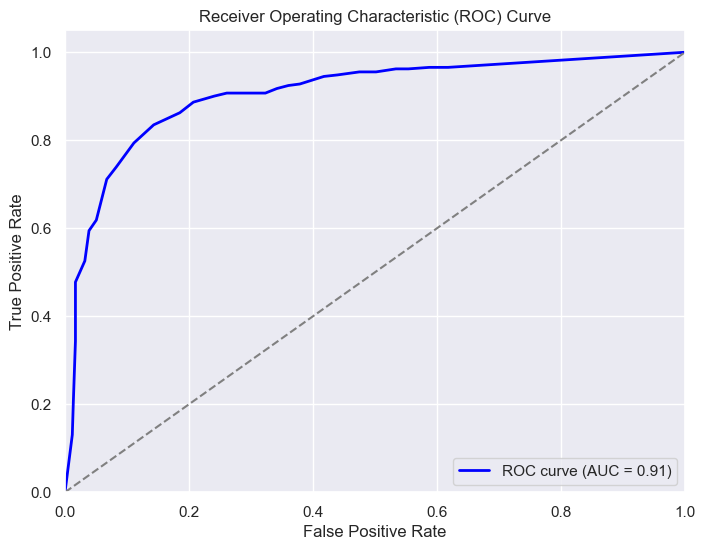

In [97]:
model_evaluation(bayes_dt_model, x_test, y_test, phase = 'Test')

## Feature Importance (Dt)

In [98]:
def feature_importance(model):
    imp_df = pd.DataFrame({'columns': x_train.columns, 'importance' : model.get_params()['classifier'].feature_importances_}).sort_values('importance', ascending = False).head(10)
    ax = sns.barplot(y = 'columns', x = 'importance', data = imp_df)
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title('Feature Importance')
    for container in ax.containers:
        ax.bar_label(container)
    plt.show()

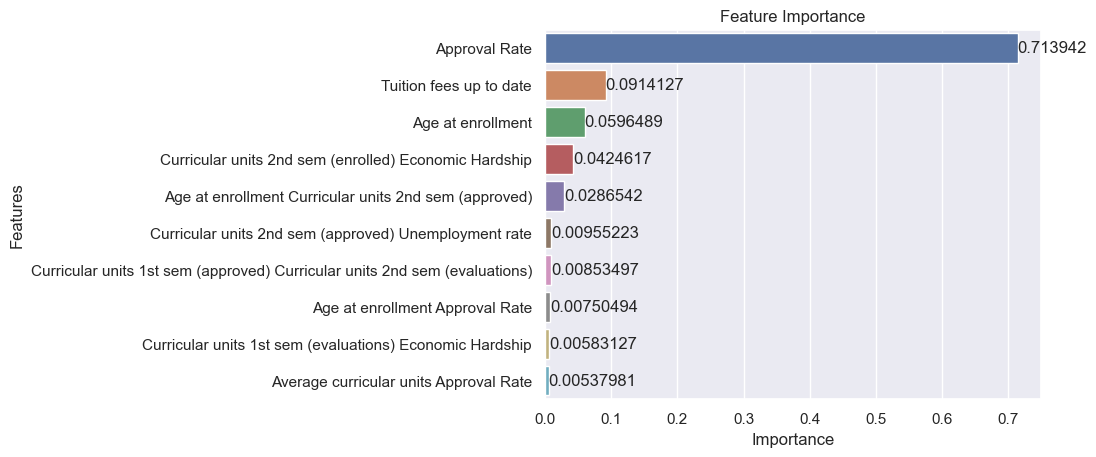

In [99]:
feature_importance(bayes_dt_model)

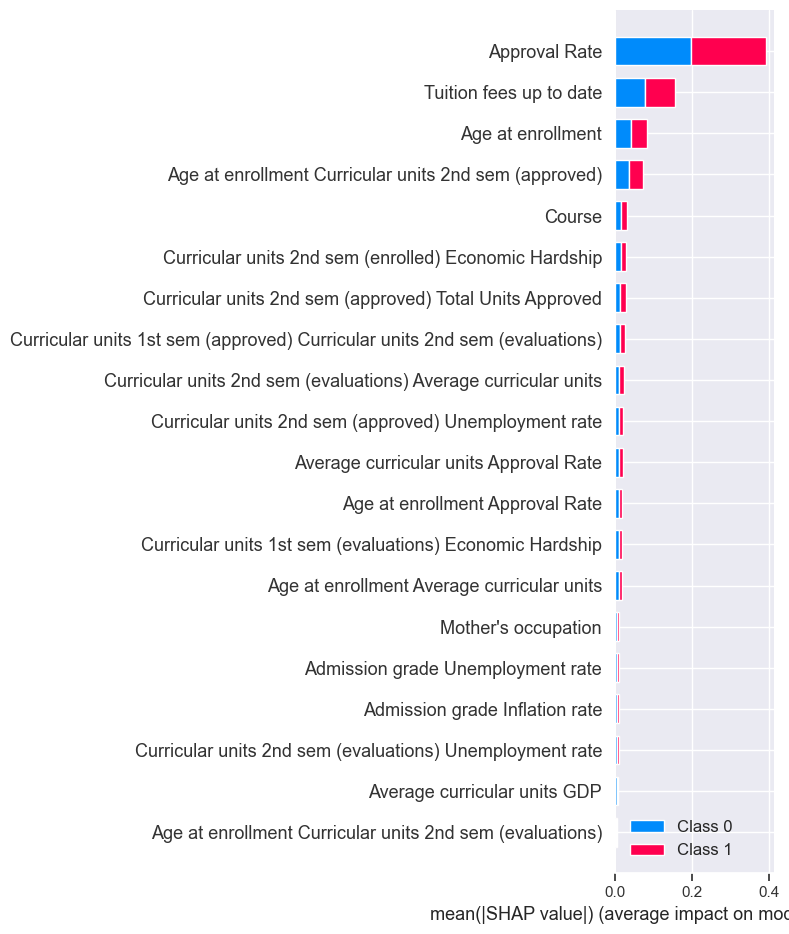

In [260]:
shap_values = shap_explanations(bayes_dt_model, x_train, y_train, x_test, x_train.columns)


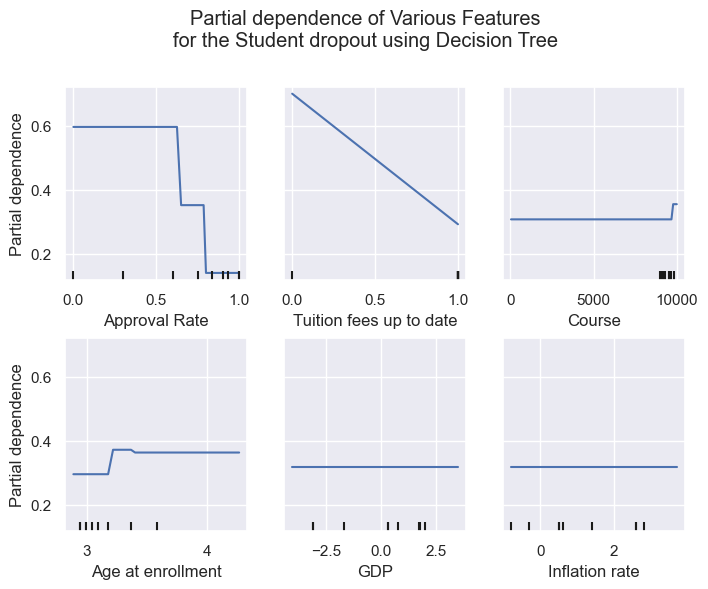

In [255]:
create_pdp(bayes_dt_model, x_test, ['Approval Rate', 'Tuition fees up to date', 'Course', 'Age at enrollment', 'GDP', 'Inflation rate'], algo = 'Decision Tree')

In [265]:
save_model(grid_dt_model, 'grid_decision_tree.pkl')
save_model(random_dt_model, 'random_decision tree.pkl')
save_model(bayes_dt_model, 'bayes_decision_tree.pkl')
save_model(pipeline_dt_tuned, 'manual_decision_tree.pkl')

Model saved successfully to grid_decision_tree.pkl
Model saved successfully to random_decision tree.pkl
Model saved successfully to bayes_decision_tree.pkl
Model saved successfully to manual_decision_tree.pkl


# Random Forest Classifier

In [101]:
# Create the pipeline
pipeline_rf = Pipeline([
    ('scaler', MinMaxScaler()),  # Step 1: Scale features to a range (0, 1)
    ('classifier', RandomForestClassifier(random_state = 105))  # Step 2: Apply Logistic Regression
])

Train Time(s): 1.1931411000041408
Training Accuracy:  100.0%

 Model Evaluation Result For the Training Phase 

Test Time(s): 0.024493199998687487
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.87      0.92      0.90       595
           1       0.82      0.72      0.77       290

    accuracy                           0.86       885
   macro avg       0.85      0.82      0.83       885
weighted avg       0.85      0.86      0.85       885
 



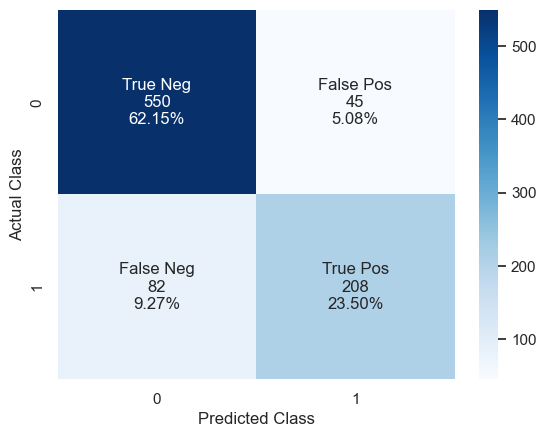

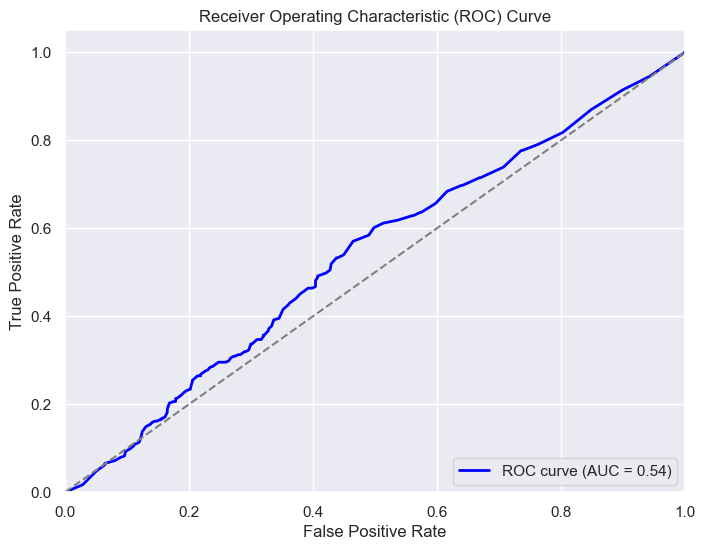

In [102]:
model_training(pipeline_rf, x_train, y_train, x_val, y_val, phase= 'Training')

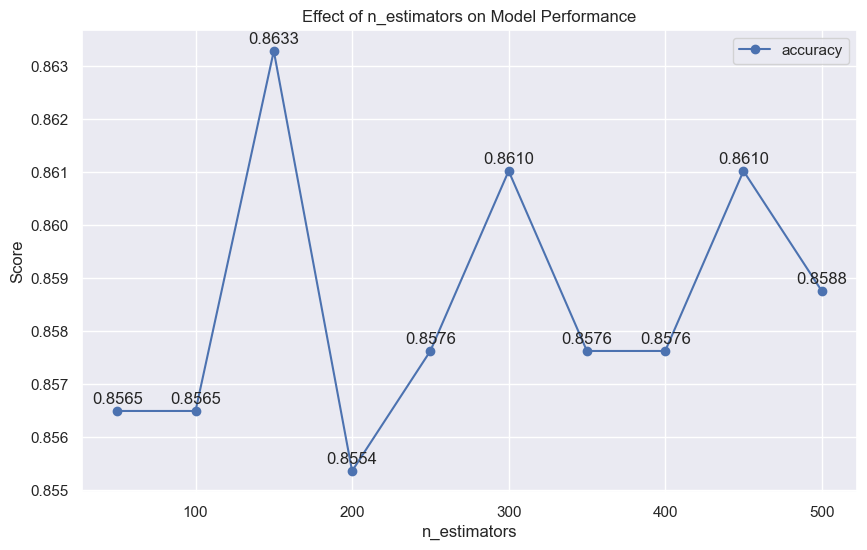

In [103]:
# Define the range of values for the hyperparameter 'n_estimators'
param_values = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
param_name = 'n_estimators'

# Call the function to evaluate and plot the metrics
evaluate_pipeline_with_metrics(pipeline_rf, param_name, param_values, x_train, x_val, y_train, y_val, metrics=['accuracy'])

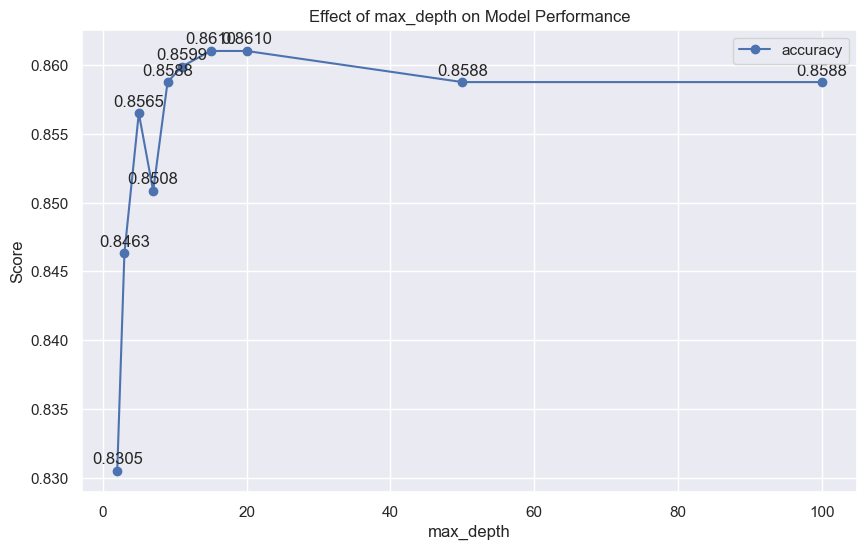

In [104]:
# Define the range of values for the hyperparameter 'max_depth'
param_values = [2, 3, 5, 7, 9, 11, 15, 20, 50, 100]
param_name = 'max_depth'

# Call the function to evaluate and plot the metrics
evaluate_pipeline_with_metrics(pipeline_rf, param_name, param_values, x_train, x_val, y_train, y_val, metrics=['accuracy'])

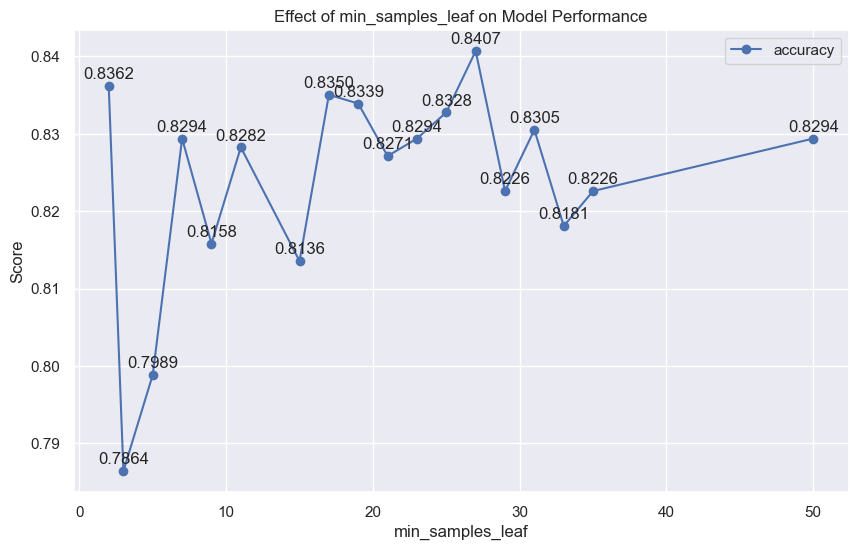

In [105]:
# Define the range of values for the hyperparameter 'min_samples_leaf'
param_values = [2, 3, 5, 7, 9, 11, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 50]
param_name = 'min_samples_leaf'

# Call the function to evaluate and plot the metrics
evaluate_pipeline_with_metrics(pipeline_dt, param_name, param_values, x_train, x_val, y_train, y_val, metrics=['accuracy'])

### Manual Tuning

In [106]:
# Create the pipeline
pipeline_rf_tuned = Pipeline([
    ('scaler', MinMaxScaler()),  # Step 1: Scale features to a range (0, 1)
    ('classifier', RandomForestClassifier(n_estimators = 50, max_depth = 11, min_samples_leaf = 25, random_state = 105))  # Step 2: Apply Logistic Regression
])

Train Time(s): 0.19986209999478888
Training Accuracy:  89.0%

 Model Evaluation Result For the Training Phase 

Test Time(s): 0.011810100004367996
Accuracy:  85.0%

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       595
           1       0.83      0.69      0.75       290

    accuracy                           0.85       885
   macro avg       0.85      0.81      0.82       885
weighted avg       0.85      0.85      0.85       885
 



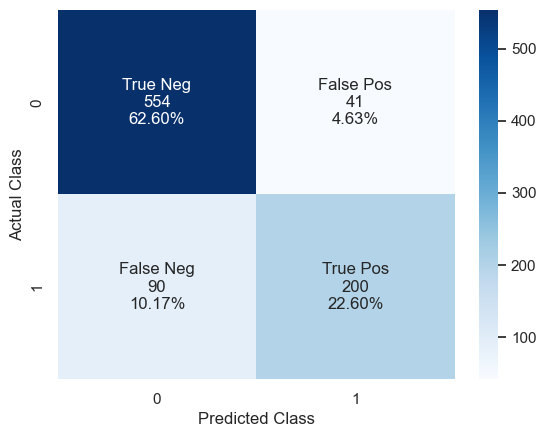

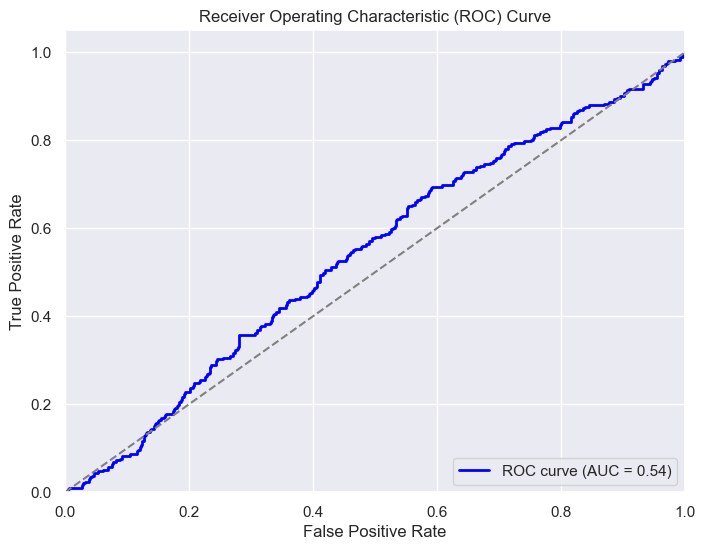

In [107]:
model_training(pipeline_rf_tuned, x_train, y_train, x_val, y_val, phase= 'Training')

In [108]:
#cross_validation(pipeline_rf_tuned, x_eval, y_eval, cv)


 Model Evaluation Result For the Test Phase 

Test Time(s): 0.01992930000415072
Accuracy:  83.0%

              precision    recall  f1-score   support

           0       0.84      0.94      0.88       594
           1       0.83      0.62      0.71       291

    accuracy                           0.83       885
   macro avg       0.83      0.78      0.80       885
weighted avg       0.83      0.83      0.83       885
 



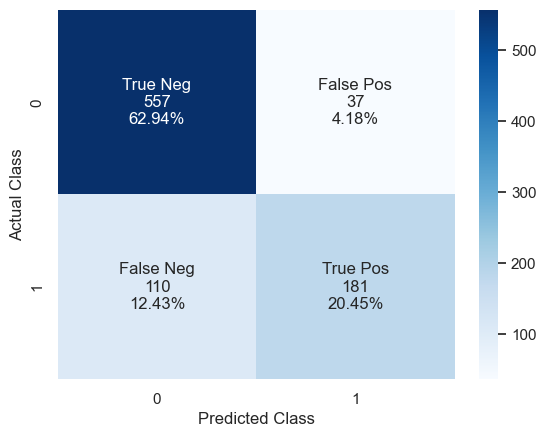

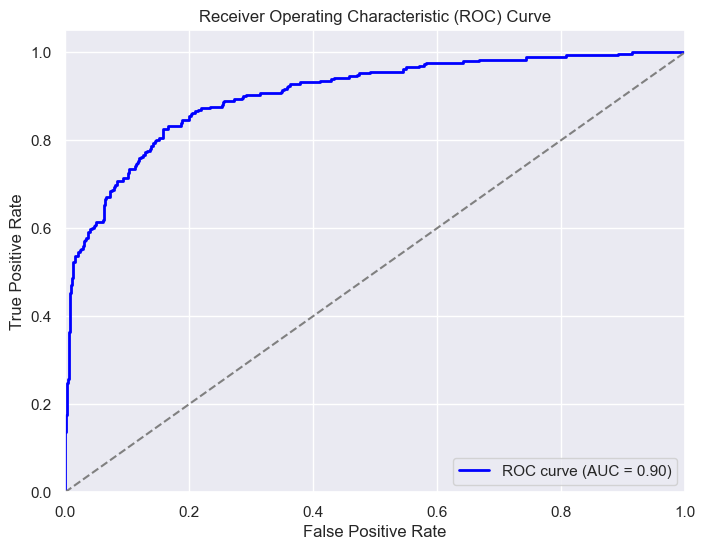

In [109]:
model_evaluation(pipeline_rf_tuned, x_test, y_test, phase = 'Test')

### Grid Search

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Train Time(s): 1.0746956000002683
Training Accuracy:  97.0%

 Model Evaluation Result For the Tuning Phase 

Test Time(s): 0.029631700002937578
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       595
           1       0.81      0.74      0.77       290

    accuracy                           0.86       885
   macro avg       0.85      0.83      0.84       885
weighted avg       0.86      0.86      0.86       885
 



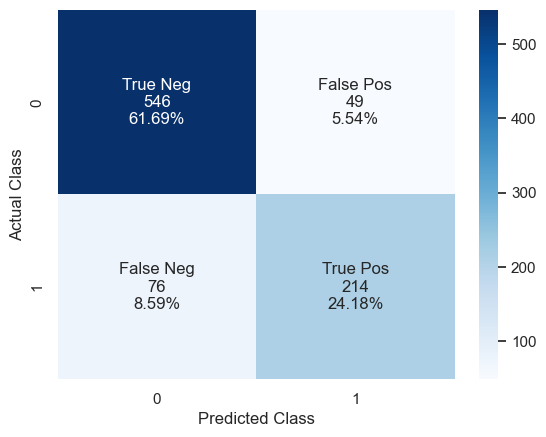

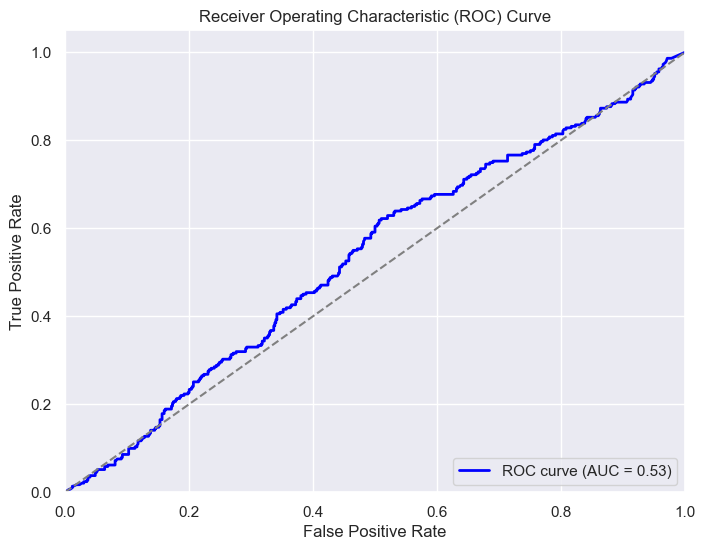

In [110]:
param_grid_rf = {
    "classifier__n_estimators": [50, 100, 200],
    "classifier__max_features": [5, 10, 20],
    "classifier__min_samples_leaf": [2, 3, 7], 
}

grid_rf_params, grid_rf_model = grid_tuning(pipeline_rf, parameters = param_grid_rf, train_feat = x_train,
                              train_labels = y_train, val_feat = x_val, val_labels = y_val, cv = 3)

In [111]:
grid_rf_params

{'classifier__max_features': 20,
 'classifier__min_samples_leaf': 3,
 'classifier__n_estimators': 200}

In [112]:
#cross_validation(grid_rf_model, x_eval, y_eval, cv)


 Model Evaluation Result For the Test Phase 

Test Time(s): 0.02775839999958407
Accuracy:  85.0%

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       594
           1       0.84      0.68      0.75       291

    accuracy                           0.85       885
   macro avg       0.85      0.81      0.82       885
weighted avg       0.85      0.85      0.85       885
 



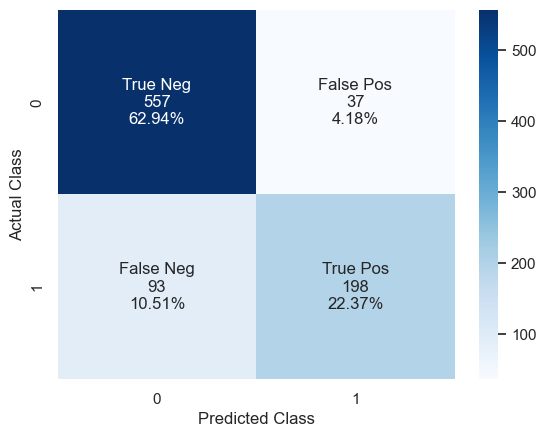

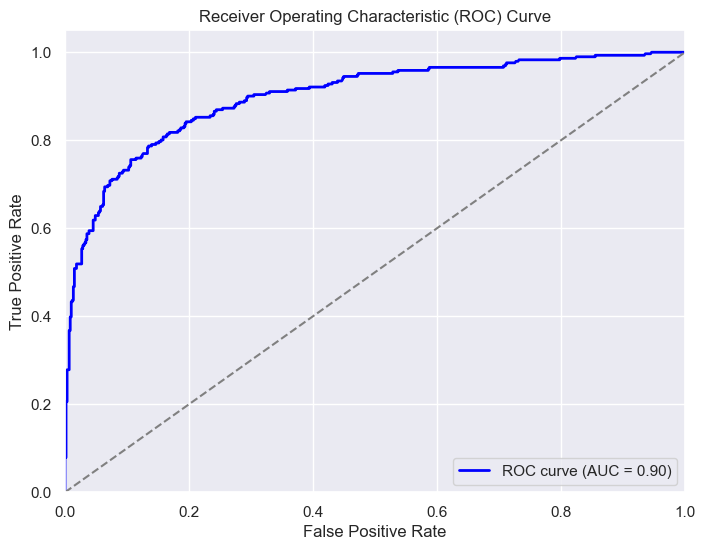

In [113]:
model_evaluation(grid_rf_model, x_test, y_test, phase = 'Test')

### Random Search

Train Time(s): 1.0972380000021076
Training Accuracy:  90.0%

 Model Evaluation Result For the Tuning Phase 

Test Time(s): 0.010807599996041972
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       595
           1       0.83      0.74      0.78       290

    accuracy                           0.87       885
   macro avg       0.86      0.83      0.84       885
weighted avg       0.86      0.87      0.86       885
 



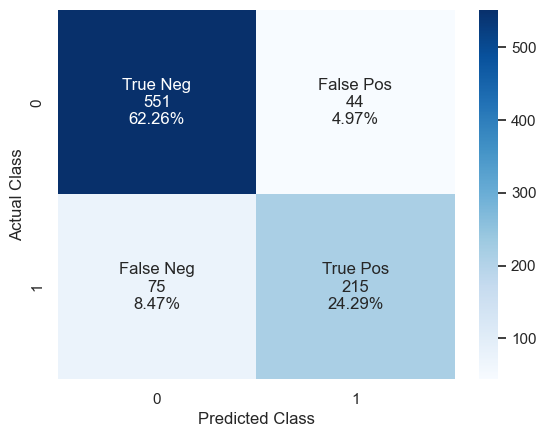

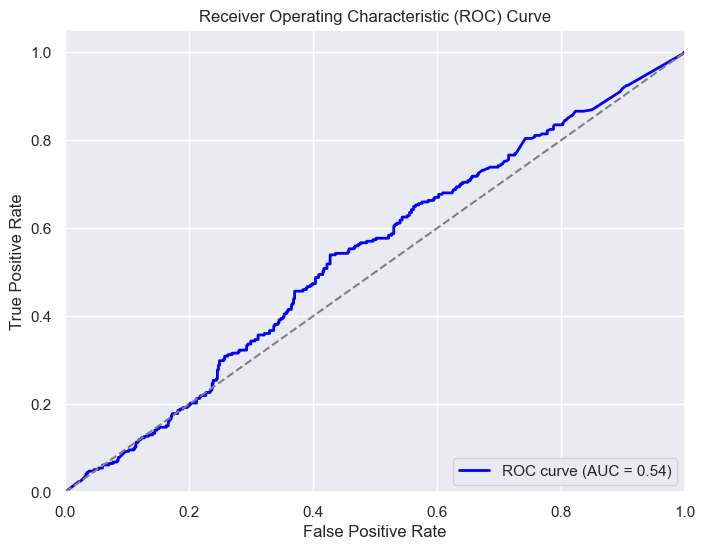

In [114]:
param_dist_rf = {
    "classifier__n_estimators": [50, 100, 150, 200, 250, 300],
    "classifier__min_samples_split": [2, 3, 5, 7, 11, 15, 20, 25],
    "classifier__max_depth": [5, 7, 9, 15, 20, 25, 30, 50],
    "classifier__min_samples_leaf": [2, 3, 7, 9, 11, 13, 15, 17, 25, 30, 40, 50],
    "classifier__max_features": [None, 'sqrt', 'log2'],
    "classifier__criterion": ['gini', 'entropy']
}
random_rf_params, random_rf_model = random_tuning(clf = pipeline_rf, parameters= param_dist_rf, train_feat = x_train, n_iter = 5, train_labels = y_train, val_feat = x_val, val_labels = y_val, cv = 3, svc = False)

In [115]:
random_rf_params

{'classifier__n_estimators': 100,
 'classifier__min_samples_split': 11,
 'classifier__min_samples_leaf': 3,
 'classifier__max_features': None,
 'classifier__max_depth': 5,
 'classifier__criterion': 'gini'}

In [116]:
#cross_validation(random_rf_model, x_eval, y_eval, cv)


 Model Evaluation Result For the Test Phase 

Test Time(s): 0.021646000001055654
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.86      0.93      0.90       594
           1       0.84      0.69      0.76       291

    accuracy                           0.86       885
   macro avg       0.85      0.81      0.83       885
weighted avg       0.85      0.86      0.85       885
 



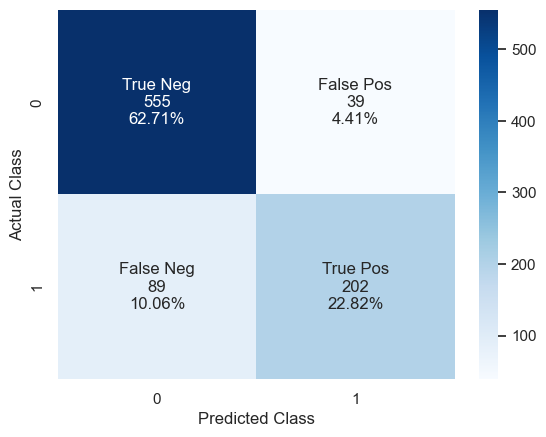

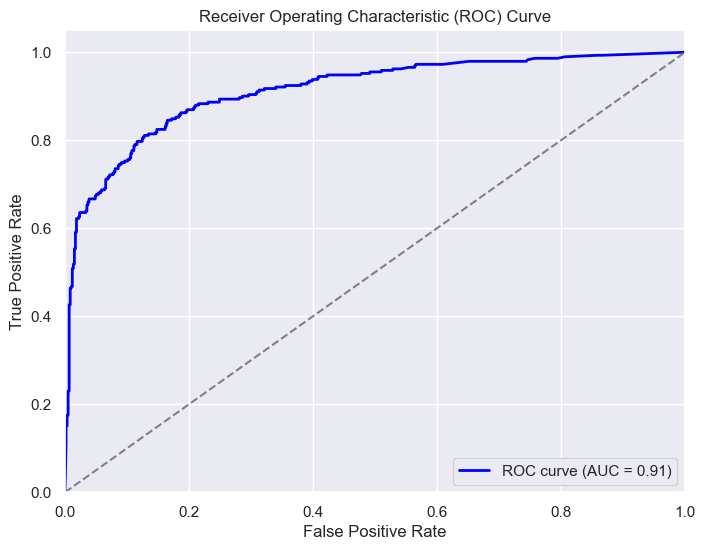

In [117]:
model_evaluation(random_rf_model, x_test, y_test, phase = 'Test')

## Bayes Search

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Train Time(s): 15.53728439999395
Training Accuracy:  89.0%

 Model Evaluation Result For the Tuning Phase 

Test Time(s): 0.026005499996244907
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       595
           1       0.84      0.73      0.78       290

    accuracy                           0.87       885
   macro avg       0.86      0.

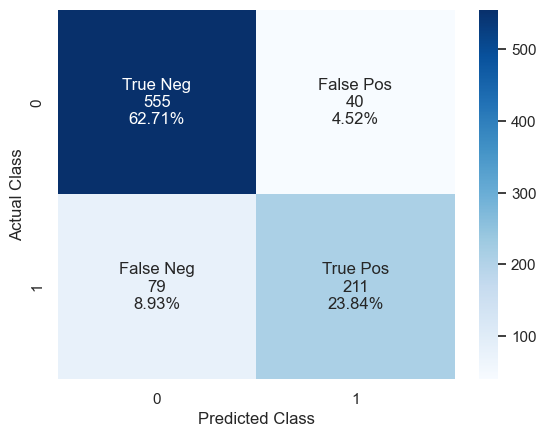

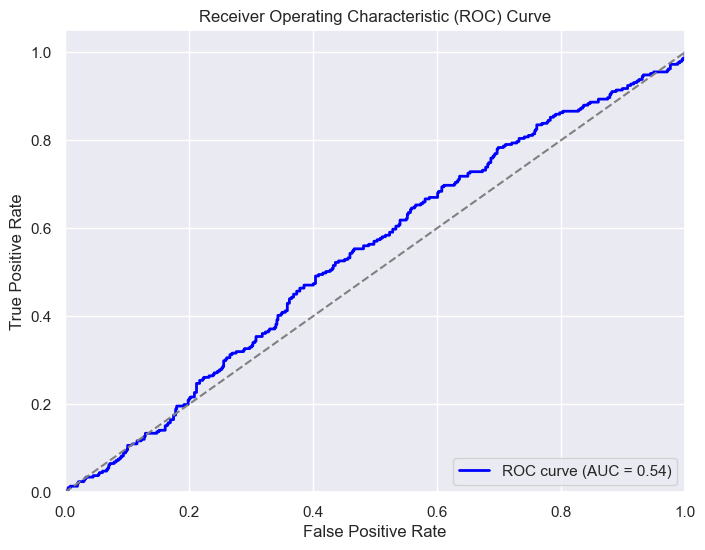

In [118]:
param_dist_rf = {
    "classifier__n_estimators": [50, 100, 150, 200, 250, 300],
    "classifier__min_samples_split": [2, 3, 5, 7, 11, 15, 20, 25],
    "classifier__max_depth": [5, 7, 9, 15, 20, 25, 30, 50],
    "classifier__min_samples_leaf": [2, 3, 7, 9, 11, 13, 15, 17, 25, 30, 40, 50],
    "classifier__max_features": [None, 'sqrt', 'log2'],
    "classifier__criterion": ['gini', 'entropy']
}
bayes_rf_params, bayes_rf_model = bayes_tuning(clf = pipeline_rf, parameters= param_dist_rf, train_feat = x_train, train_labels = y_train, val_feat = x_val, val_labels = y_val, cv = 3, svc = False)

In [119]:
bayes_rf_params

OrderedDict([('classifier__criterion', 'entropy'),
             ('classifier__max_depth', 5),
             ('classifier__max_features', None),
             ('classifier__min_samples_leaf', 17),
             ('classifier__min_samples_split', 5),
             ('classifier__n_estimators', 100)])

In [120]:
#cross_validation(bayes_rf_model, x_eval, y_eval, cv)


 Model Evaluation Result For the Test Phase 

Test Time(s): 0.04241110000293702
Accuracy:  85.0%

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       594
           1       0.85      0.68      0.75       291

    accuracy                           0.85       885
   macro avg       0.85      0.81      0.82       885
weighted avg       0.85      0.85      0.85       885
 



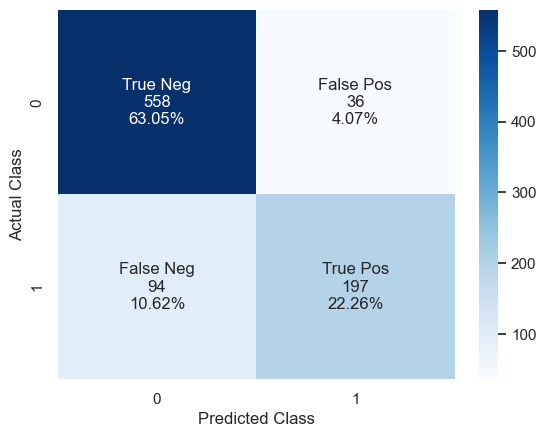

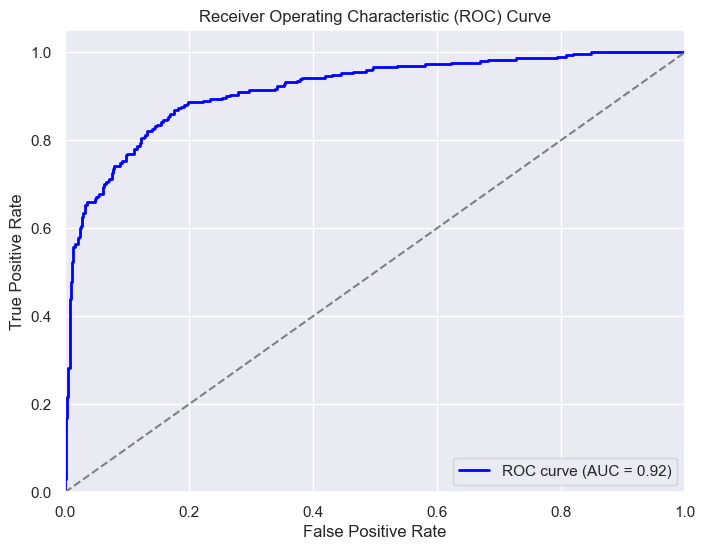

In [121]:
model_evaluation(bayes_rf_model, x_test, y_test, phase = 'Test')

## Feature Importance (Rf)

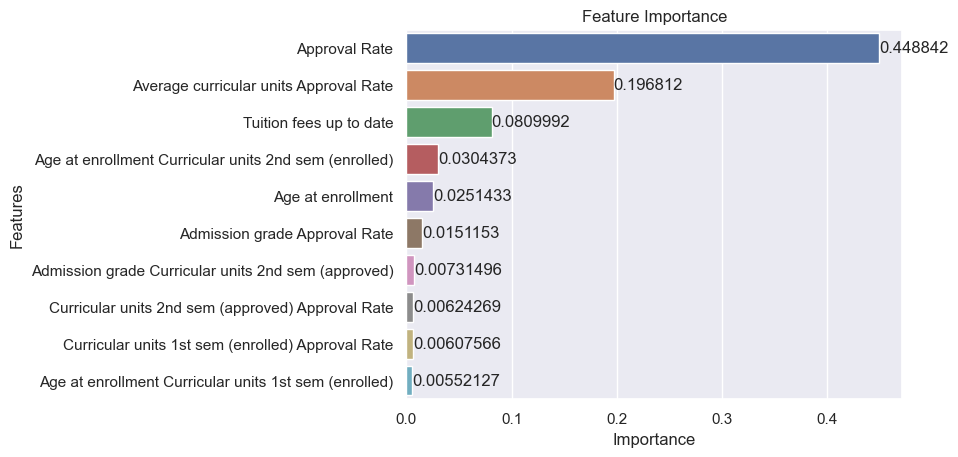

In [122]:
feature_importance(random_rf_model)

In [262]:
#shap_values = shap_explanations(random_rf_model, x_train, y_train, x_test, x_train.columns)


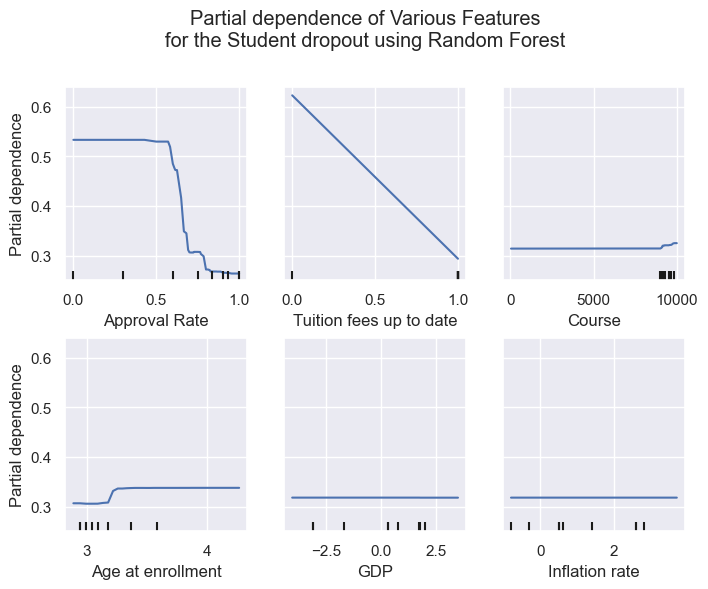

In [271]:
create_pdp(random_rf_model, x_test, ['Approval Rate', 'Tuition fees up to date', 'Course', 'Age at enrollment', 'GDP', 'Inflation rate'], algo = 'Random Forest')

In [264]:
save_model(grid_rf_model, 'grid_random_forest.pkl')
save_model(random_rf_model, 'random_random_forest.pkl')
save_model(bayes_rf_model, 'bayes_random_forest.pkl')
save_model(pipeline_rf_tuned, 'manual_random_forest.pkl')

Model saved successfully to grid_random_forest.pkl
Model saved successfully to random_random_forest.pkl
Model saved successfully to bayes_random_forest.pkl
Model saved successfully to manual_random_forest.pkl


# Support Vector Machine 

In [124]:
# Create the pipeline
pipeline_svc = Pipeline([
    ('scaler', MinMaxScaler()),  # Step 1: Scale features to a range (0, 1)
    ('classifier', SVC(random_state = 105))  # Step 2: Apply Logistic Regression
])

Train Time(s): 0.6538214999964111
Training Accuracy:  88.0%

 Model Evaluation Result For the Training Phase 

Test Time(s): 0.2577482999986387
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.87      0.95      0.90       595
           1       0.86      0.70      0.77       290

    accuracy                           0.87       885
   macro avg       0.86      0.82      0.84       885
weighted avg       0.87      0.87      0.86       885
 



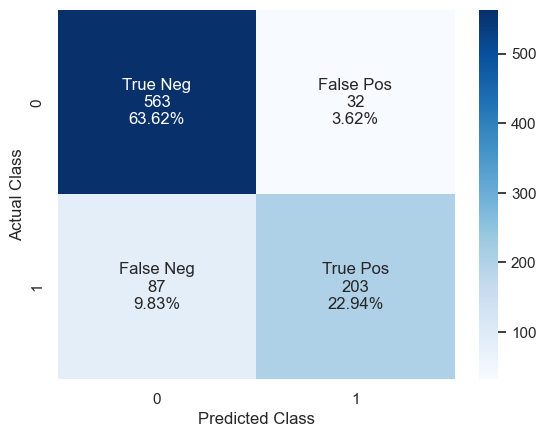

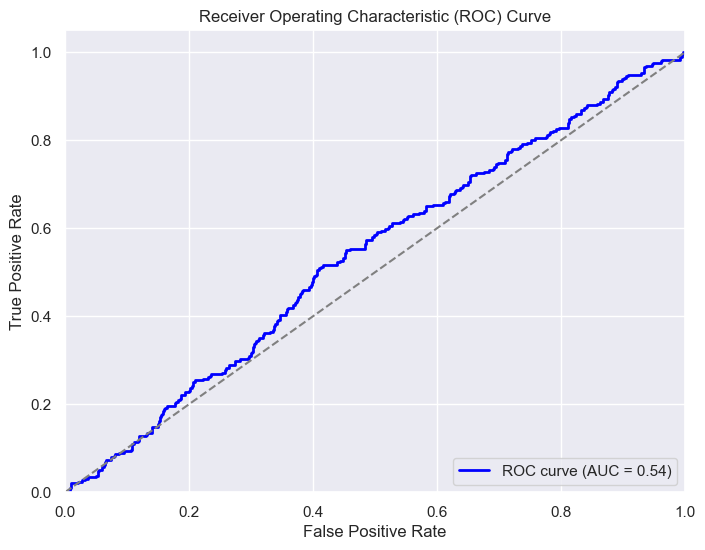

In [125]:
model_training(pipeline_svc, x_train, y_train, x_val, y_val, svc = True, phase = 'Training')

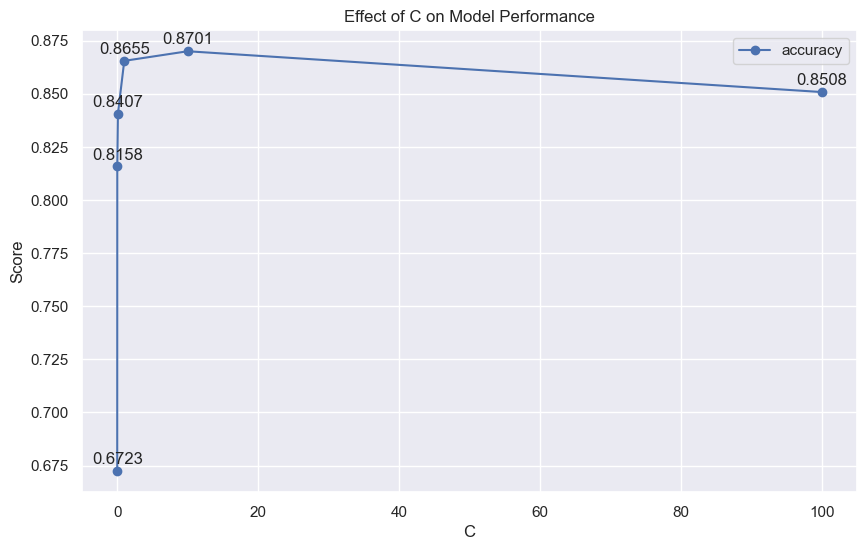

In [126]:
# Define the range of values for the hyperparameter 'max_depth'
param_values = [0.001, 0.01, 0.1, 1, 10, 100]
param_name = 'C'

# Call the function to evaluate and plot the metrics
evaluate_pipeline_with_metrics(pipeline_svc, param_name, param_values, x_train, x_val, y_train, y_val, metrics=['accuracy'])

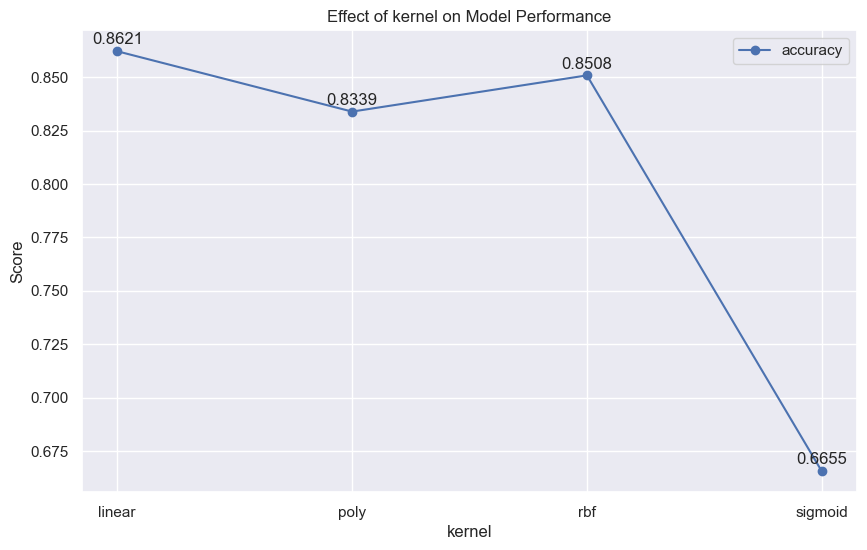

In [127]:
# Define the range of values for the hyperparameter 'max_depth'
param_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_name = 'kernel'

# Call the function to evaluate and plot the metrics
evaluate_pipeline_with_metrics(pipeline_svc, param_name, param_values, x_train, x_val, y_train, y_val, metrics=['accuracy'])

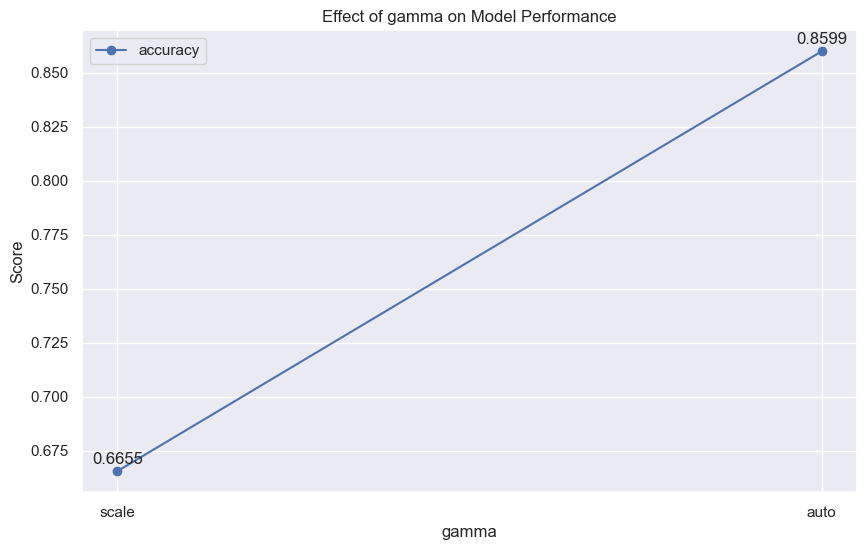

In [128]:
# Define the range of values for the hyperparameter 'min_samples_leaf'
param_values = ['scale', 'auto']
param_name = 'gamma'

# Call the function to evaluate and plot the metrics
evaluate_pipeline_with_metrics(pipeline_svc, param_name, param_values, x_train, x_val, y_train, y_val, metrics=['accuracy'])

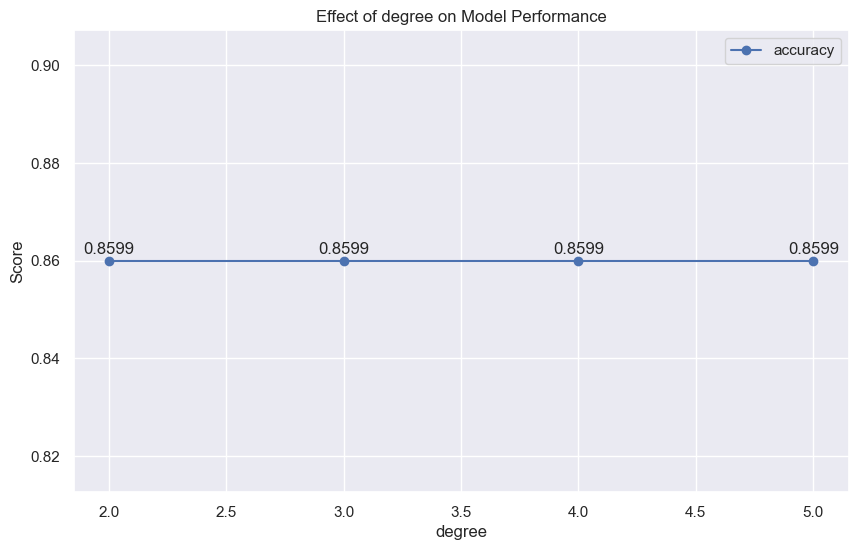

In [129]:
# Define the range of values for the hyperparameter 'min_samples_leaf'
param_values = [2, 3, 4, 5]
param_name = 'degree'

# Call the function to evaluate and plot the metrics
evaluate_pipeline_with_metrics(pipeline_svc, param_name, param_values, x_train, x_val, y_train, y_val, metrics=['accuracy'])

Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


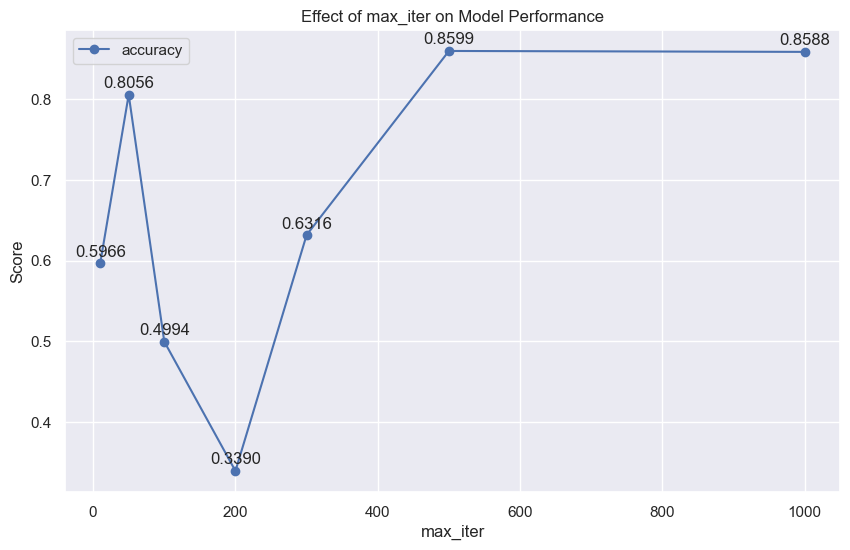

In [130]:
# Define the range of values for the hyperparameter 'min_samples_leaf'
param_values = [10, 50, 100, 200, 300, 500, 1000]
param_name = 'max_iter'

# Call the function to evaluate and plot the metrics
evaluate_pipeline_with_metrics(pipeline_svc, param_name, param_values, x_train, x_val, y_train, y_val, metrics=['accuracy'])

### Manual Tuning

In [131]:
# Create the pipeline
pipeline_svc_tuned = Pipeline([
    ('scaler', MinMaxScaler()),  # Step 1: Scale features to a range (0, 1)
    ('classifier', SVC(C = 10, kernel ='rbf', gamma = 'auto', max_iter = 500, random_state = 105))  # Step 2: Apply Logistic Regression
])

Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


Train Time(s): 0.5782738999987487
Training Accuracy:  87.0%

 Model Evaluation Result For the Training Phase 

Test Time(s): 0.41363700000511017
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       595
           1       0.84      0.70      0.76       290

    accuracy                           0.86       885
   macro avg       0.85      0.82      0.83       885
weighted avg       0.86      0.86      0.86       885
 



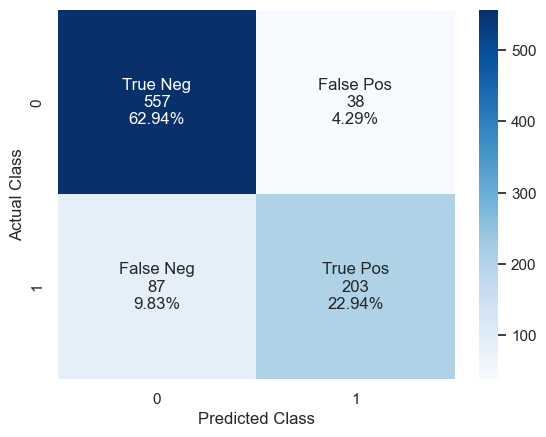

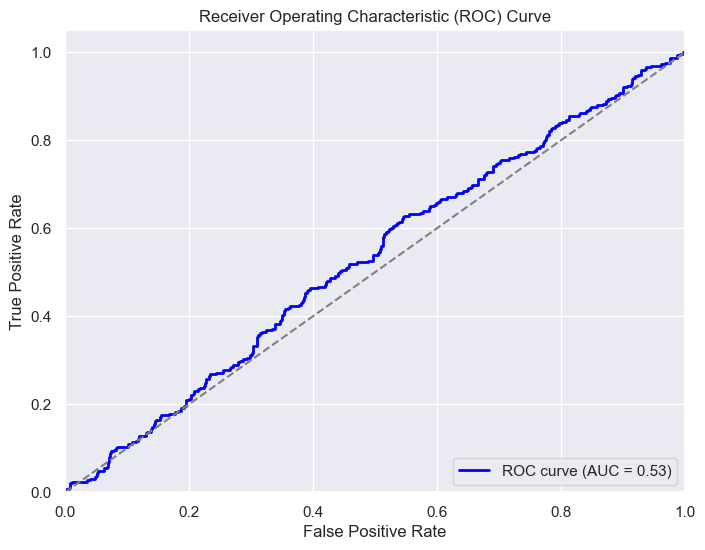

In [132]:
model_training(pipeline_svc_tuned, x_train, y_train, x_val, y_val, phase= 'Training', svc = True)

In [133]:
#cross_validation(pipeline_svc_tuned, x_eval, y_eval, cv)


 Model Evaluation Result For the Test Phase 

Test Time(s): 0.2794565000003786
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.86      0.95      0.91       594
           1       0.88      0.69      0.78       291

    accuracy                           0.87       885
   macro avg       0.87      0.82      0.84       885
weighted avg       0.87      0.87      0.86       885
 



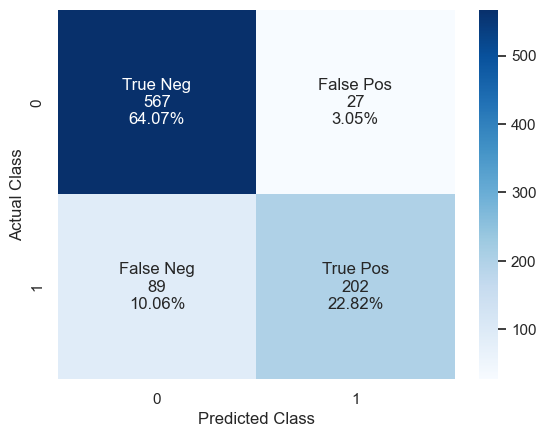

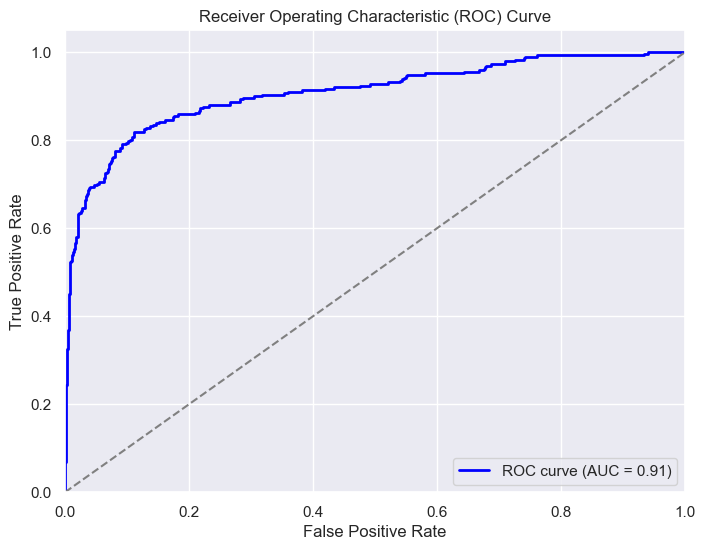

In [134]:
model_evaluation(pipeline_svc_tuned, x_test, y_test, phase = 'Test', svc = True)

### Grid Search

Fitting 3 folds for each of 72 candidates, totalling 216 fits


Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


Train Time(s): 0.7213098000065656
Training Accuracy:  88.0%

 Model Evaluation Result For the Tuning Phase 

Test Time(s): 0.11870690000068862
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       595
           1       0.84      0.71      0.77       290

    accuracy                           0.86       885
   macro avg       0.85      0.82      0.83       885
weighted avg       0.86      0.86      0.86       885
 



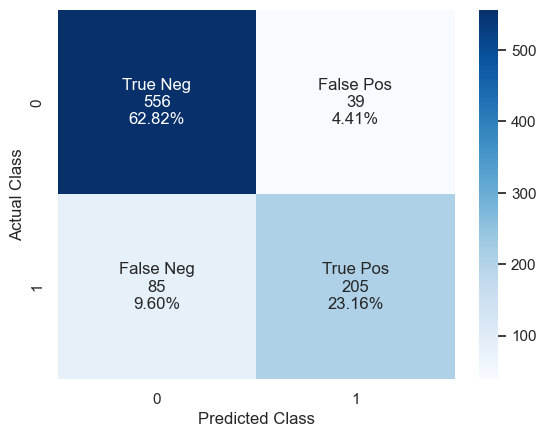

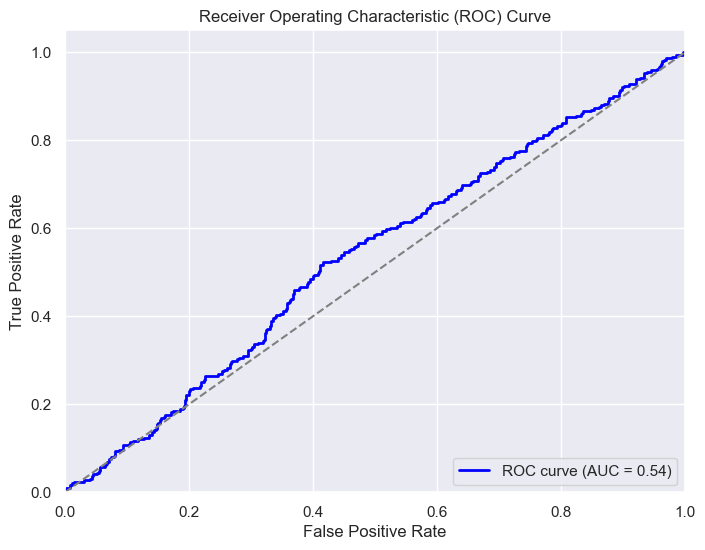

In [135]:
param_grid_svc = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__kernel': ['linear', 'poly', 'rbf'],
    'classifier__degree': [2, 3, 4],  
    'classifier__max_iter': [1000, 2000]
}

grid_svc_params, grid_svc_model = grid_tuning(pipeline_svc, parameters = param_grid_svc, train_feat = x_train,
                              train_labels = y_train, val_feat = x_val, val_labels = y_val, cv = 3, svc = True)

In [136]:
grid_svc_params

{'classifier__C': 1,
 'classifier__degree': 2,
 'classifier__kernel': 'linear',
 'classifier__max_iter': 2000}

In [137]:
#cross_validation(grid_svc_model, x_eval, y_eval, cv)


 Model Evaluation Result For the Test Phase 

Test Time(s): 0.11855210000067018
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       594
           1       0.87      0.70      0.78       291

    accuracy                           0.87       885
   macro avg       0.87      0.82      0.84       885
weighted avg       0.87      0.87      0.86       885
 



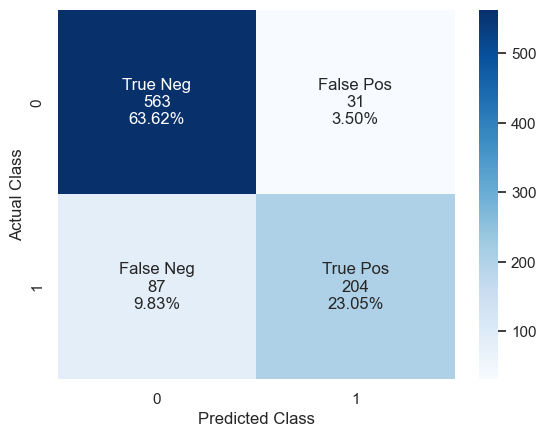

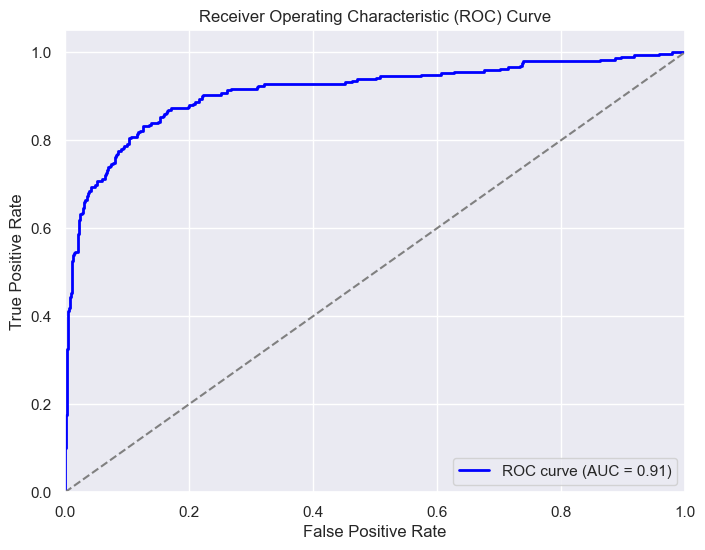

In [138]:
model_evaluation(grid_svc_model, x_test, y_test, phase = 'Test', svc = True)

### Random Search

Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


Train Time(s): 0.5991701000020839
Training Accuracy:  91.0%

 Model Evaluation Result For the Tuning Phase 

Test Time(s): 0.13900719999946887
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.88      0.91      0.89       595
           1       0.80      0.75      0.77       290

    accuracy                           0.86       885
   macro avg       0.84      0.83      0.83       885
weighted avg       0.85      0.86      0.86       885
 



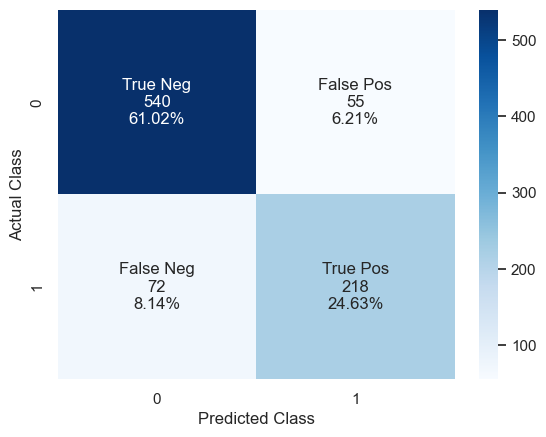

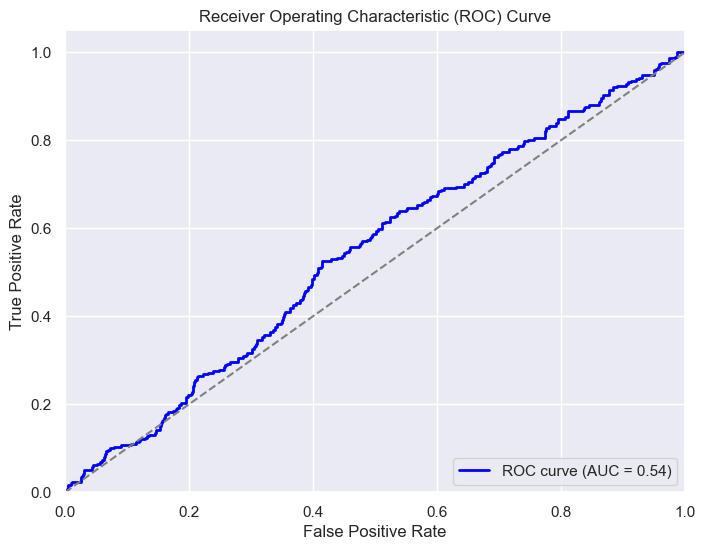

In [139]:
param_dist_svc = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'classifier__gamma': ['scale', 'auto'],
    'classifier__degree': [2, 3, 4],  
    'classifier__max_iter': [1000, 2000, 3000]
}
random_svc_params, random_svc_model = random_tuning(clf = pipeline_svc, parameters= param_dist_svc, train_feat = x_train, n_iter = 5, train_labels = y_train, val_feat = x_val, val_labels = y_val, cv = 3, svc = True)

In [140]:
random_svc_params

{'classifier__max_iter': 1000,
 'classifier__kernel': 'poly',
 'classifier__gamma': 'scale',
 'classifier__degree': 4,
 'classifier__C': 1}

In [141]:
#cross_validation(random_svc_model, x_eval, y_eval, cv)


 Model Evaluation Result For the Test Phase 

Test Time(s): 0.11716200000228127
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       594
           1       0.83      0.74      0.78       291

    accuracy                           0.86       885
   macro avg       0.85      0.83      0.84       885
weighted avg       0.86      0.86      0.86       885
 



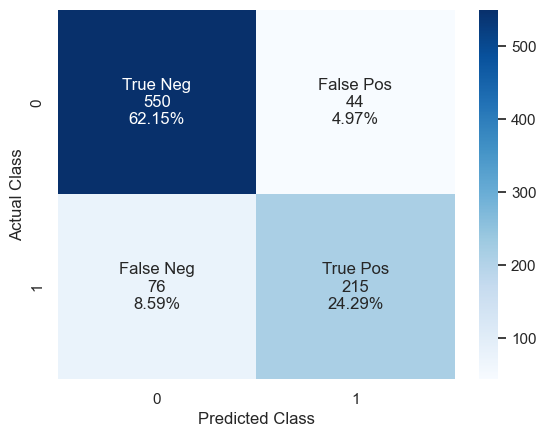

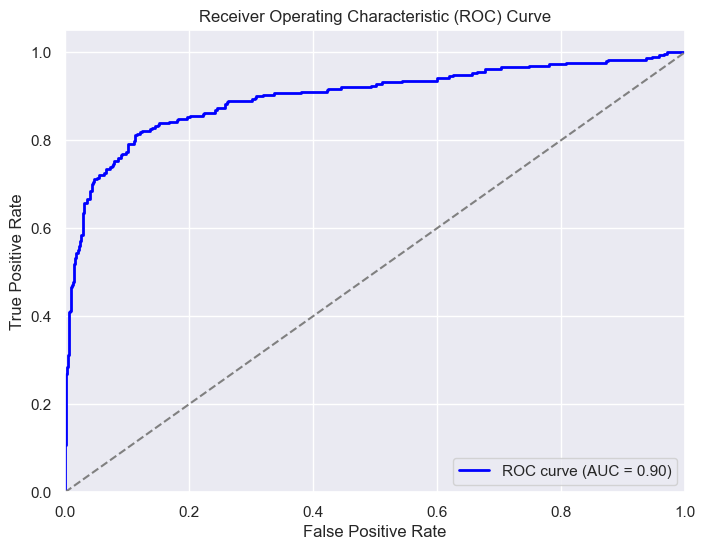

In [142]:
model_evaluation(random_svc_model, x_test, y_test, phase = 'Test', svc = True)

## Bayes Search

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


Train Time(s): 1.0223299999997835
Training Accuracy:  88.0%

 Model Evaluation Result For the Tuning Phase 

Test Time(s): 0.16844729999866104
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.86      0.93      0.90       595
           1       0.84      0.70      0.76       290

    accuracy                           0.86       885
   macro avg       0.85      0.82      0.83       885
weighted avg       0.85      0.86      0.85       885
 



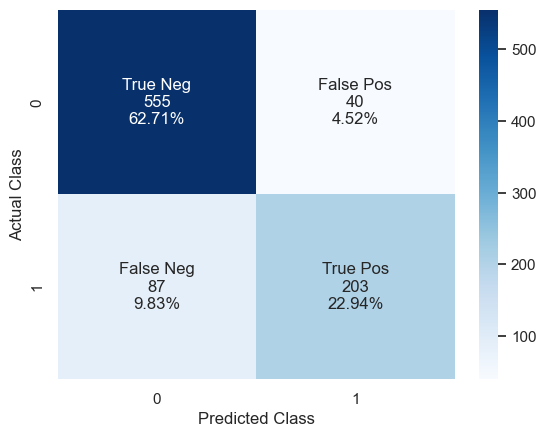

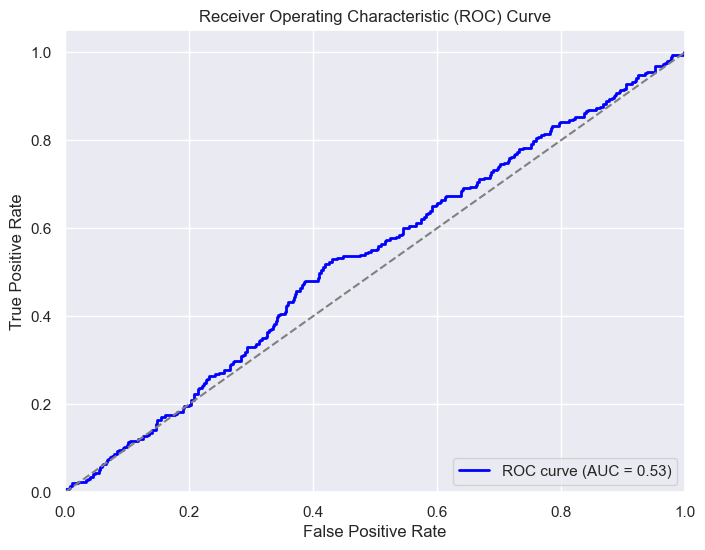

In [143]:
param_grid_svc = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'classifier__gamma': ['scale', 'auto'],
    'classifier__degree': [2, 3, 4],  
    'classifier__max_iter': [1000, 2000, 3000]
}
bayes_svc_params, bayes_svc_model = bayes_tuning(clf = pipeline_svc, parameters= param_dist_svc, train_feat = x_train, train_labels = y_train, val_feat = x_val, val_labels = y_val, cv = 3, svc = True)

In [144]:
bayes_svc_params

OrderedDict([('classifier__C', 1),
             ('classifier__degree', 3),
             ('classifier__gamma', 'scale'),
             ('classifier__kernel', 'linear'),
             ('classifier__max_iter', 3000)])

In [145]:
#cross_validation(bayes_svc_model, x_eval, y_eval, cv)


 Model Evaluation Result For the Test Phase 

Test Time(s): 0.10971679999784101
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.86      0.95      0.91       594
           1       0.88      0.69      0.78       291

    accuracy                           0.87       885
   macro avg       0.87      0.82      0.84       885
weighted avg       0.87      0.87      0.86       885
 



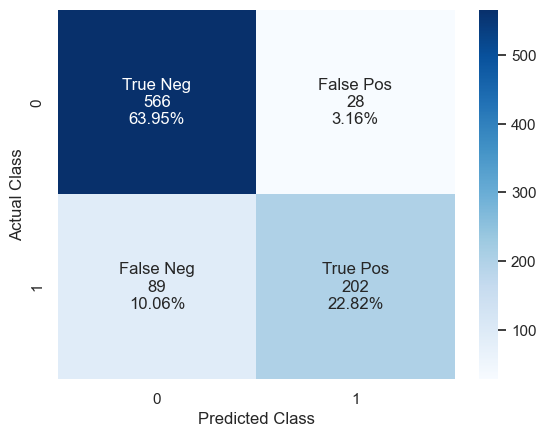

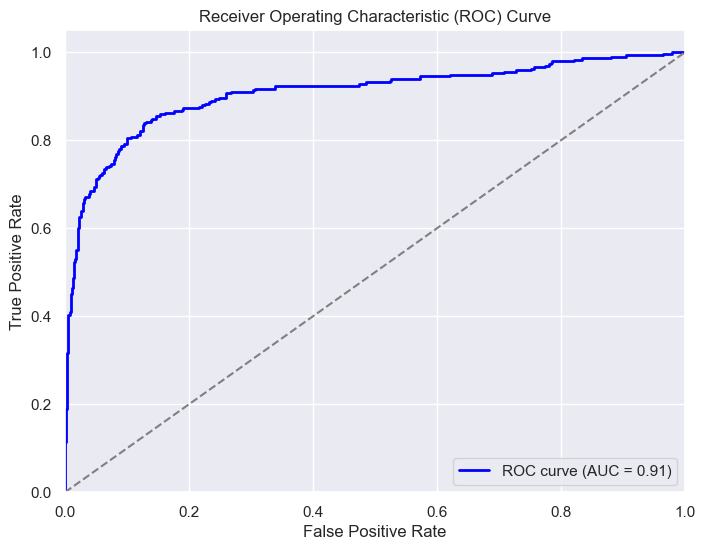

In [146]:
model_evaluation(bayes_svc_model, x_test, y_test, phase = 'Test', svc = True)

Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


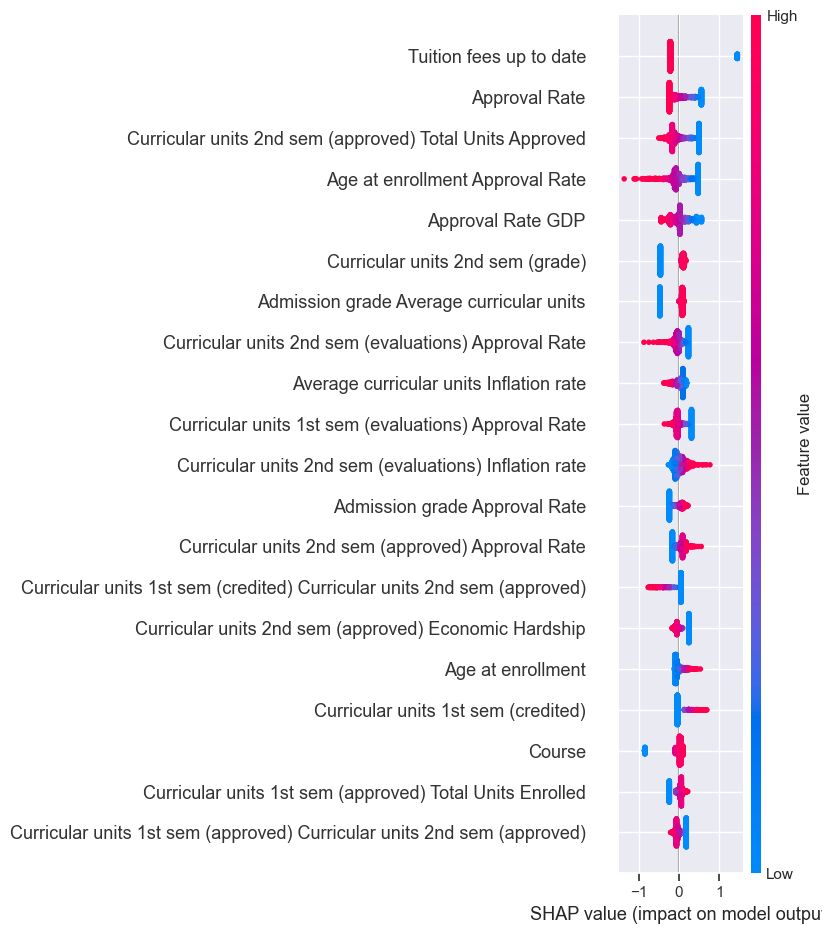

In [270]:
shap_values = shap_explanations(grid_svc_model, x_train, y_train, x_test, x_train.columns)


In [274]:
# create_pdp(grid_svc_model, x_test, ['Approval Rate', 'Tuition fees up to date', 'Course', 'Age at enrollment', 'GDP', 'Inflation rate'], algo = 'SVM')

In [275]:
save_model(grid_svc_model, 'grid_svc.pkl')
save_model(random_svc_model, 'random_svc.pkl')
save_model(bayes_svc_model, 'bayes_svc.pkl')
save_model(pipeline_svc_tuned, 'manual_svc.pkl')

Model saved successfully to grid_svc.pkl
Model saved successfully to random_svc.pkl
Model saved successfully to bayes_svc.pkl
Model saved successfully to manual_svc.pkl


# Gradient Boosting Classifier

In [148]:
# Create the pipeline
pipeline_gdb = Pipeline([
    ('scaler', MinMaxScaler()),  
    ('classifier', GradientBoostingClassifier(random_state = 105))  
])

Train Time(s): 14.567386700000498
Training Accuracy:  93.0%

 Model Evaluation Result For the Training Phase 

Test Time(s): 0.013089100000797771
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       595
           1       0.82      0.74      0.78       290

    accuracy                           0.86       885
   macro avg       0.85      0.83      0.84       885
weighted avg       0.86      0.86      0.86       885
 



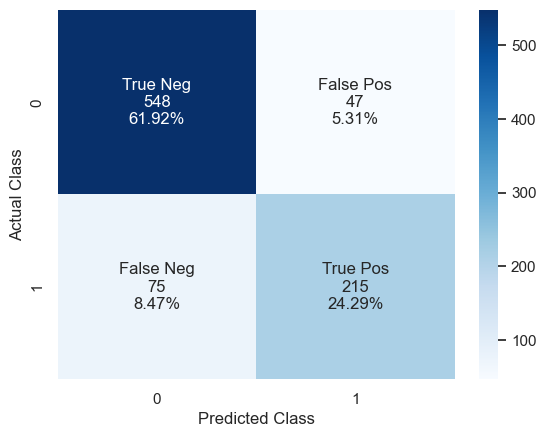

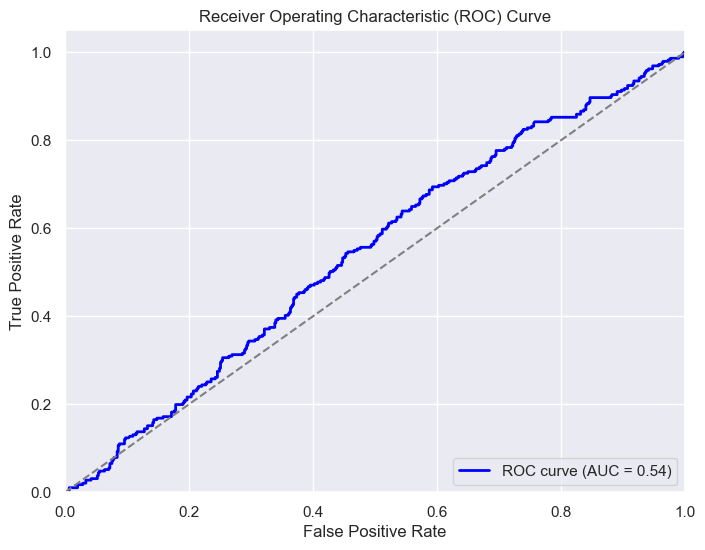

In [149]:
model_training(pipeline_gdb, x_train, y_train, x_val, y_val, phase = 'Training')

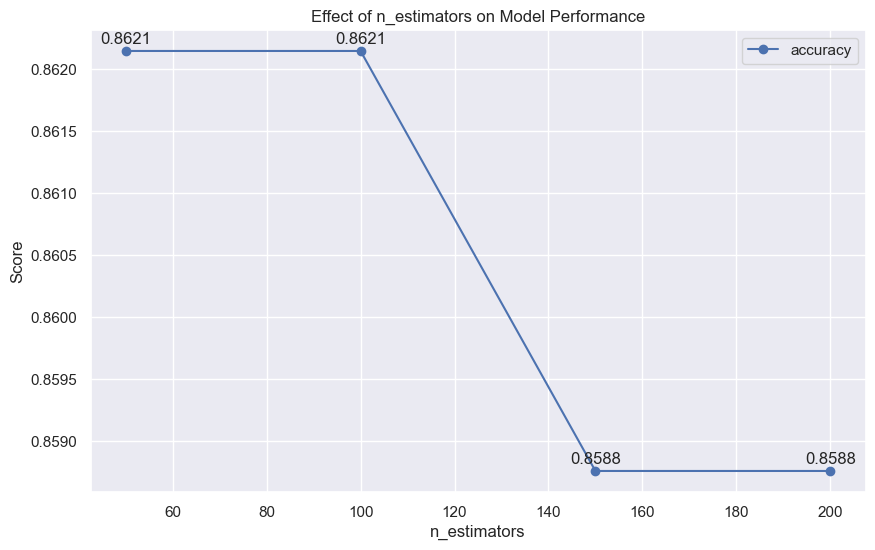

In [150]:
# Define the range of values for the hyperparameter 'max_depth'
param_values = [50, 100, 150, 200]
param_name = 'n_estimators'

# Call the function to evaluate and plot the metrics
evaluate_pipeline_with_metrics(pipeline_gdb, param_name, param_values, x_train, x_val, y_train, y_val, metrics=['accuracy'])

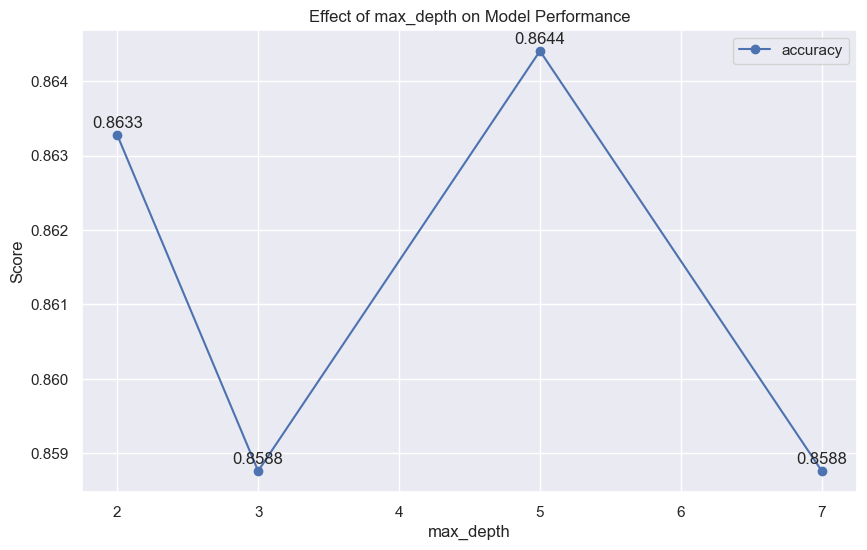

CPU times: total: 0 ns
Wall time: 0 ns


In [151]:
# Define the range of values for the hyperparameter 'max_depth'
param_values = [2, 3, 5, 7]
param_name = 'max_depth'

# Call the function to evaluate and plot the metrics
evaluate_pipeline_with_metrics(pipeline_gdb, param_name, param_values, x_train, x_val, y_train, y_val, metrics=['accuracy'])


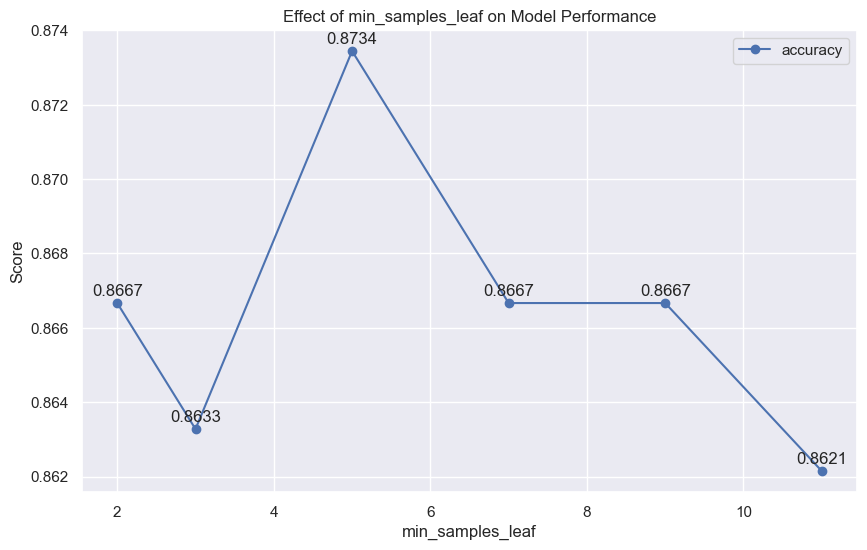

In [152]:
# Define the range of values for the hyperparameter 'min_samples_leaf'
param_values = [2, 3, 5, 7, 9, 11]
param_name = 'min_samples_leaf'

# Call the function to evaluate and plot the metrics
evaluate_pipeline_with_metrics(pipeline_gdb, param_name, param_values, x_train, x_val, y_train, y_val, metrics=['accuracy'])

### Manual Tuning

In [153]:
# Create the pipeline
pipeline_gdb_tuned = Pipeline([
    ('scaler', MinMaxScaler()),  # Step 1: Scale features to a range (0, 1)
    ('classifier', GradientBoostingClassifier(n_estimators = 50, max_depth = 11, min_samples_leaf = 25, random_state = 105))  # Step 2: Apply Logistic Regression
])

Train Time(s): 19.256996099997195
Training Accuracy:  98.0%

 Model Evaluation Result For the Training Phase 

Test Time(s): 0.011362999997800216
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.88      0.93      0.91       595
           1       0.84      0.75      0.79       290

    accuracy                           0.87       885
   macro avg       0.86      0.84      0.85       885
weighted avg       0.87      0.87      0.87       885
 



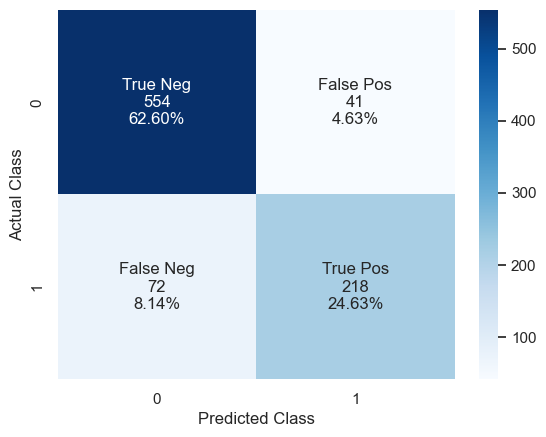

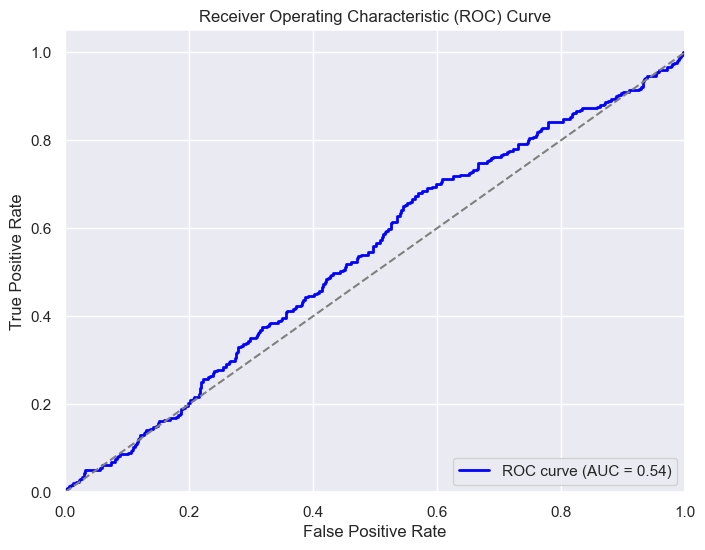

In [154]:
model_training(pipeline_gdb_tuned, x_train, y_train, x_val, y_val, phase= 'Training')

In [155]:
#cross_validation(pipeline_gdb_tuned, x_eval, y_eval, cv)


 Model Evaluation Result For the Test Phase 

Test Time(s): 0.0193585000015446
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.86      0.93      0.90       594
           1       0.84      0.70      0.76       291

    accuracy                           0.86       885
   macro avg       0.85      0.82      0.83       885
weighted avg       0.85      0.86      0.85       885
 



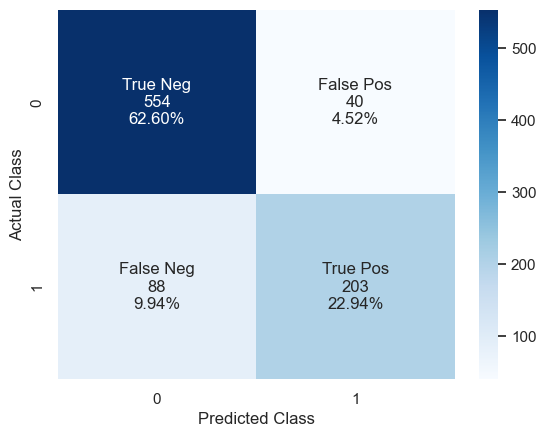

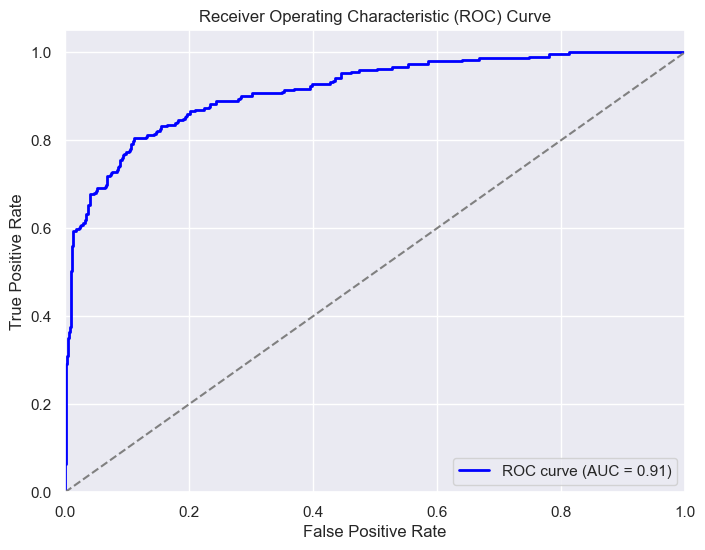

In [156]:
model_evaluation(pipeline_gdb_tuned, X_te = x_test, y_te = y_test, phase = 'Test')

### Grid Search

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Train Time(s): 3.9640260000014678
Training Accuracy:  89.0%

 Model Evaluation Result For the Tuning Phase 

Test Time(s): 0.013071699999272823
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       595
           1       0.83      0.74      0.78       290

    accuracy                           0.87       885
   macro avg       0.86      0.83      0.84       885
weighted avg       0.86      0.87      0.86       885
 



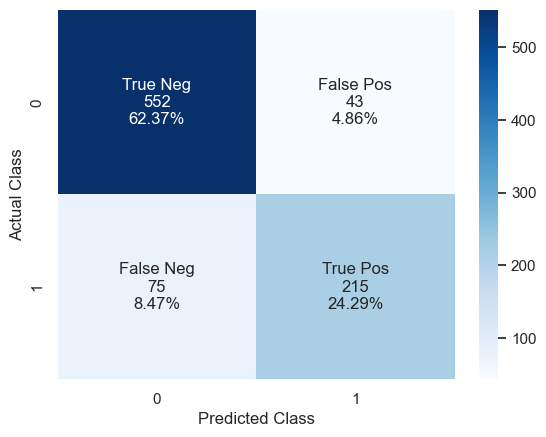

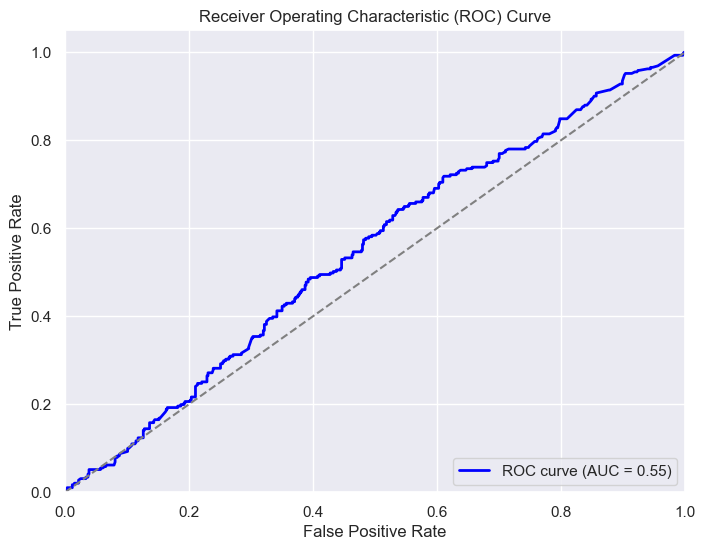

In [157]:
param_grid_gdb = {
    "classifier__n_estimators":[50,100, 200],
    "classifier__max_depth":[2, 3],
    "classifier__min_samples_split":[5, 7, 8],
    "classifier__subsample": [0.8, 0.9, 1.0],
    
}

grid_gdb_params, grid_gdb_model = grid_tuning(pipeline_gdb, parameters = param_grid_gdb, train_feat = x_train,
                              train_labels = y_train, val_feat = x_val, val_labels = y_val, cv = 3)

In [158]:
grid_gdb_params

{'classifier__max_depth': 2,
 'classifier__min_samples_split': 5,
 'classifier__n_estimators': 50,
 'classifier__subsample': 1.0}

In [159]:
#cross_validation(grid_gdb_model, x_eval, y_eval, cv)


 Model Evaluation Result For the Test Phase 

Test Time(s): 0.013561900006607175
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.87      0.94      0.90       594
           1       0.86      0.70      0.77       291

    accuracy                           0.86       885
   macro avg       0.86      0.82      0.84       885
weighted avg       0.86      0.86      0.86       885
 



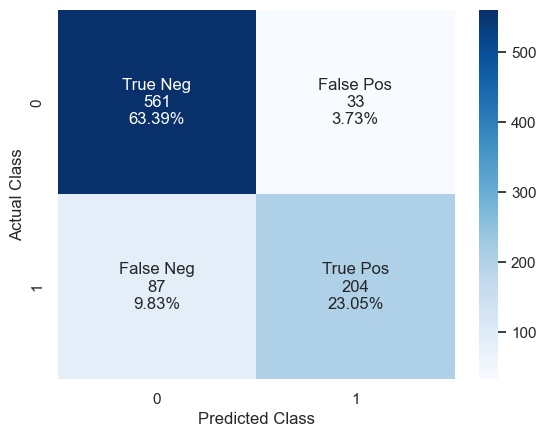

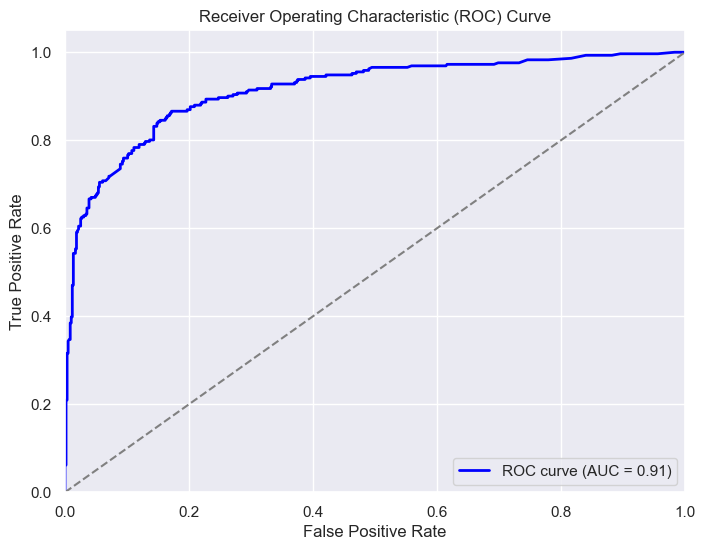

In [160]:
model_evaluation(grid_gdb_model, X_te = x_test, y_te = y_test, phase = 'Test')

### Random Search

Train Time(s): 6.548378899999079
Training Accuracy:  91.0%

 Model Evaluation Result For the Tuning Phase 

Test Time(s): 0.018861600001400802
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       595
           1       0.83      0.75      0.79       290

    accuracy                           0.87       885
   macro avg       0.86      0.84      0.85       885
weighted avg       0.87      0.87      0.87       885
 



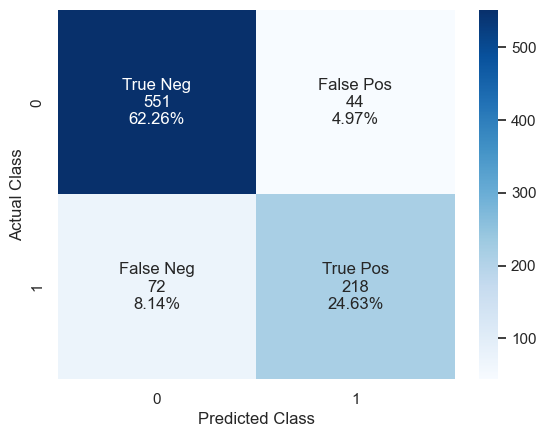

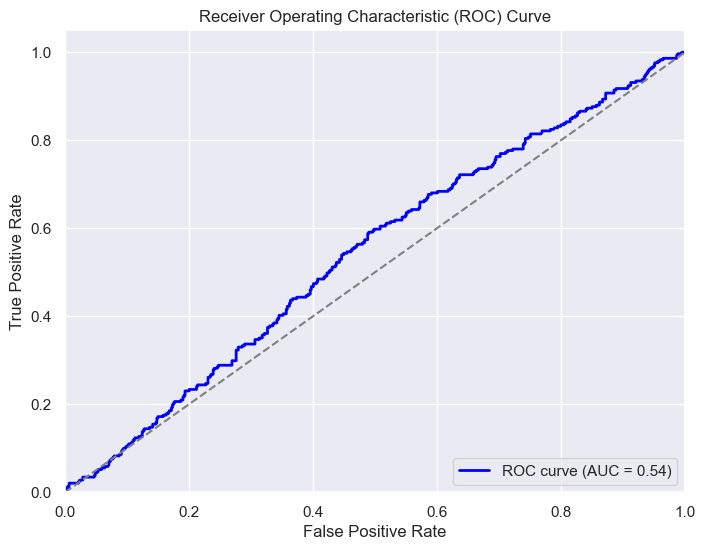

In [161]:
random_gdb_params, random_gdb_model = random_tuning(clf = pipeline_gdb, parameters= param_grid_gdb, train_feat = x_train, n_iter = 5, train_labels = y_train, val_feat = x_val, val_labels = y_val, cv = 3, svc = False)

In [162]:
random_gdb_params

{'classifier__subsample': 0.8,
 'classifier__n_estimators': 100,
 'classifier__min_samples_split': 5,
 'classifier__max_depth': 2}

In [163]:
#cross_validation(random_gdb_model, x_eval, y_eval, cv)


 Model Evaluation Result For the Test Phase 

Test Time(s): 0.014309999998658895
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       594
           1       0.84      0.70      0.77       291

    accuracy                           0.86       885
   macro avg       0.85      0.82      0.83       885
weighted avg       0.86      0.86      0.86       885
 



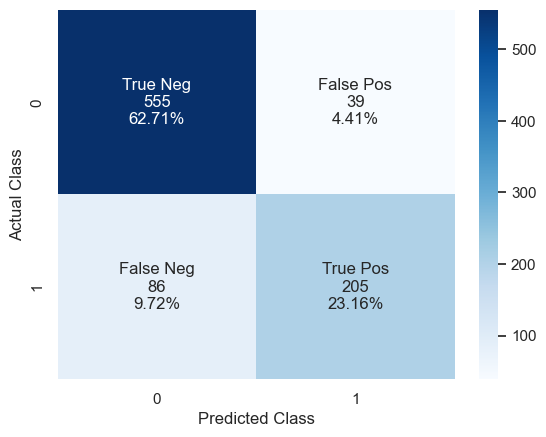

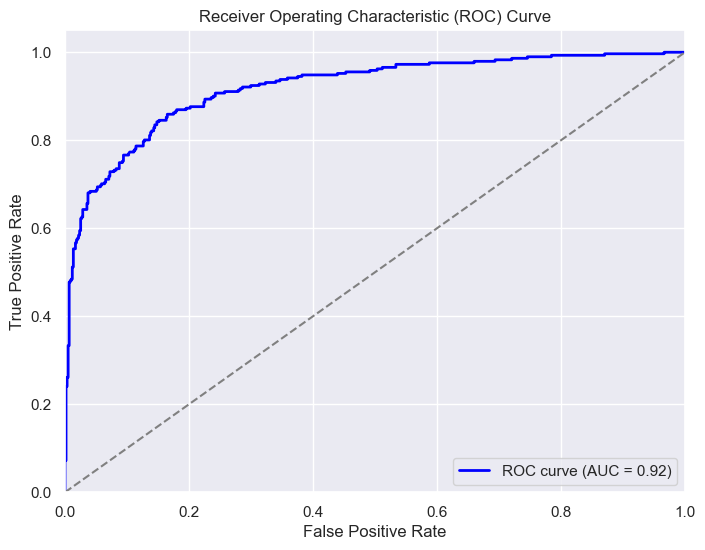

In [164]:
model_evaluation(random_gdb_model, x_test, y_test, phase = 'Test')

### Bayes Search

Dimension [2, 3] was inferred to Integer(low=2, high=3, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(2, 3), prior=None). See the documentation of the check_dimension function for the upcoming API.
Dimension [2, 3] was inferred to Integer(low=2, high=3, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(2, 3), prior=None). See the documentation of the check_dimension function for the upcoming API.
Dimension [2, 3] was inferred to Integer(low=2, high=3, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(2, 3), prior=None). See the documentation of the check_dimension function for the upcoming API.


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Train Time(s): 10.108104600003571
Training Accuracy:  93.0%

 Model Evaluation Result For the Tuning Phase 

Test Time(s): 0.0095904000045266
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       595
           1       0.82      0.76      0.78       290

    accuracy                           0.86       885
   macro avg       0.85      0.8

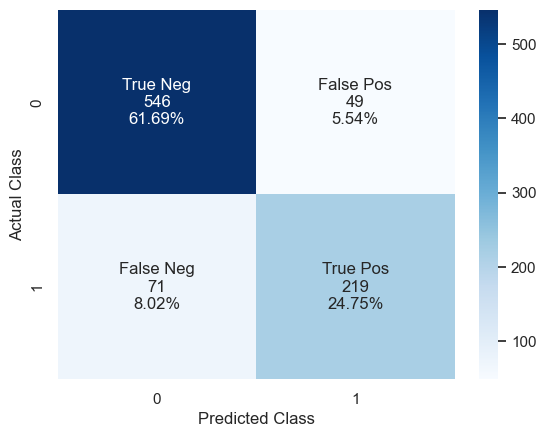

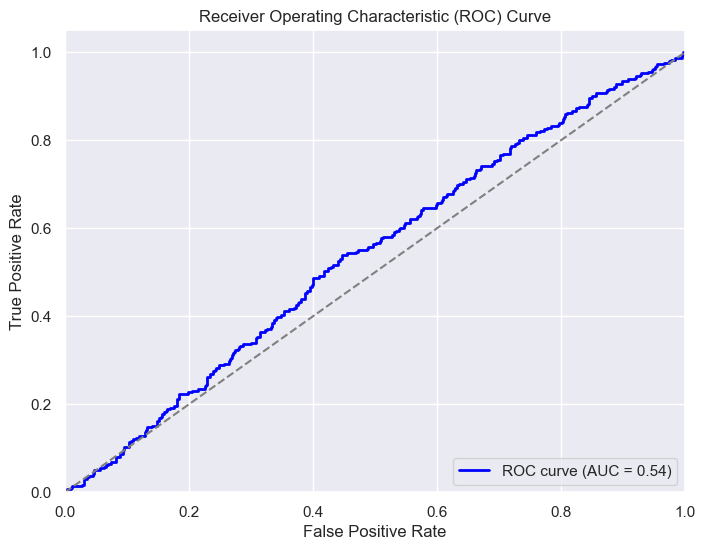

In [165]:
bayes_gdb_params, bayes_gdb_model = bayes_tuning(clf = pipeline_gdb, parameters= param_grid_gdb, train_feat = x_train, train_labels = y_train, val_feat = x_val, val_labels = y_val, cv = 3, svc = False)

In [166]:
bayes_gdb_params

OrderedDict([('classifier__max_depth', 3),
             ('classifier__min_samples_split', 7),
             ('classifier__n_estimators', 100),
             ('classifier__subsample', 0.8)])

In [167]:
#cross_validation(bayes_gdb_model, x_eval, y_eval, cv)


 Model Evaluation Result For the Test Phase 

Test Time(s): 0.013082600002235267
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       594
           1       0.84      0.69      0.76       291

    accuracy                           0.86       885
   macro avg       0.85      0.81      0.83       885
weighted avg       0.86      0.86      0.85       885
 



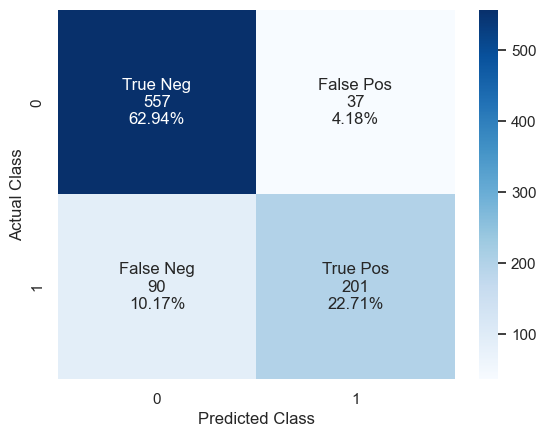

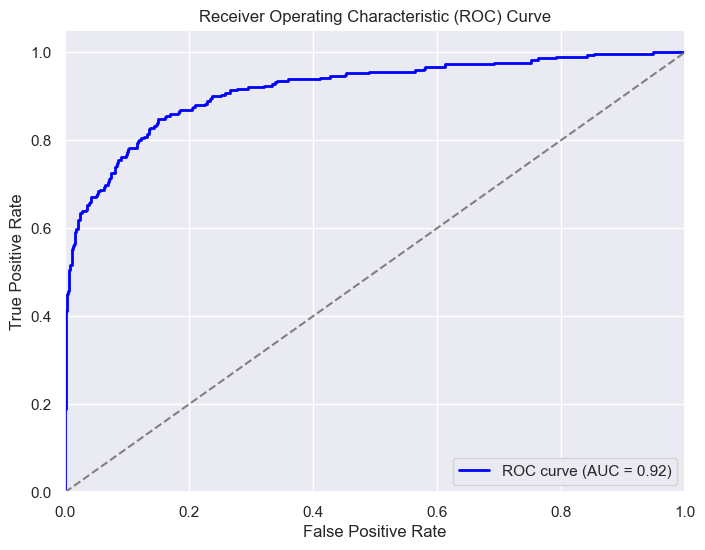

In [168]:
model_evaluation(bayes_gdb_model, x_test, y_test, phase = 'Test')

## Feature Importance (GDB)

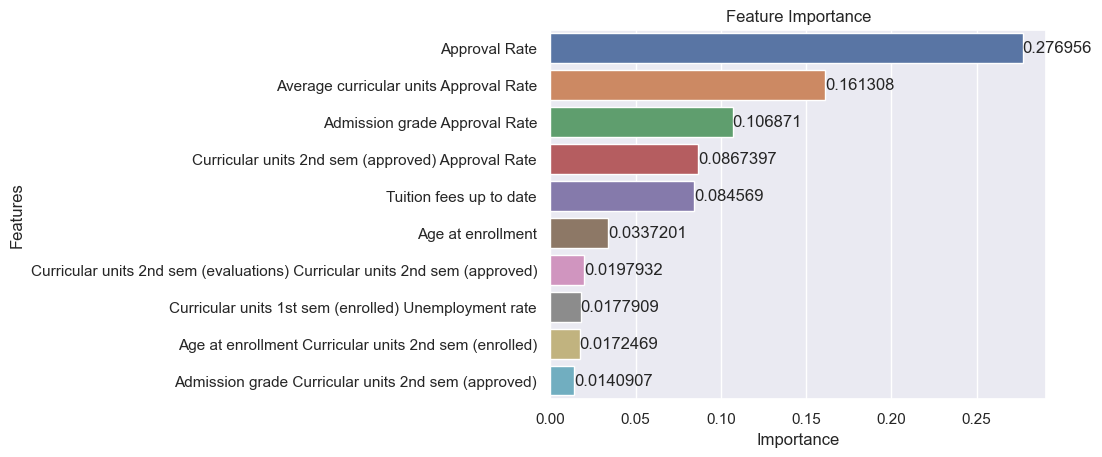

In [169]:
feature_importance(random_gdb_model)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


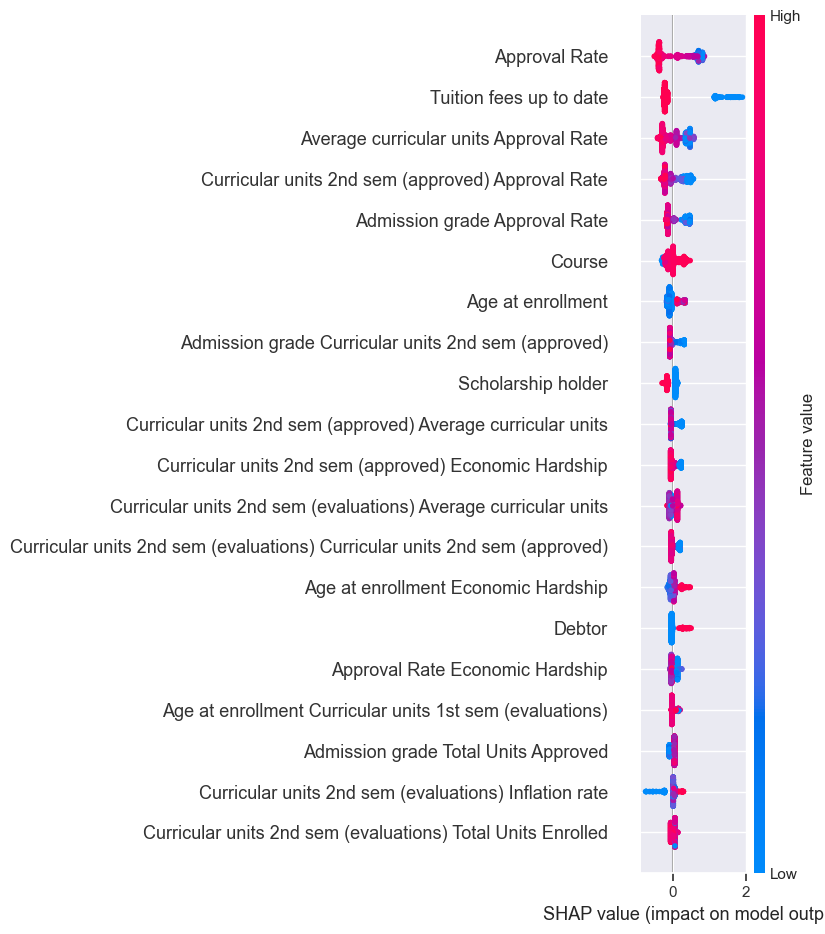

In [267]:
shap_values = shap_explanations(random_gdb_model, x_train, y_train, x_test, x_train.columns)


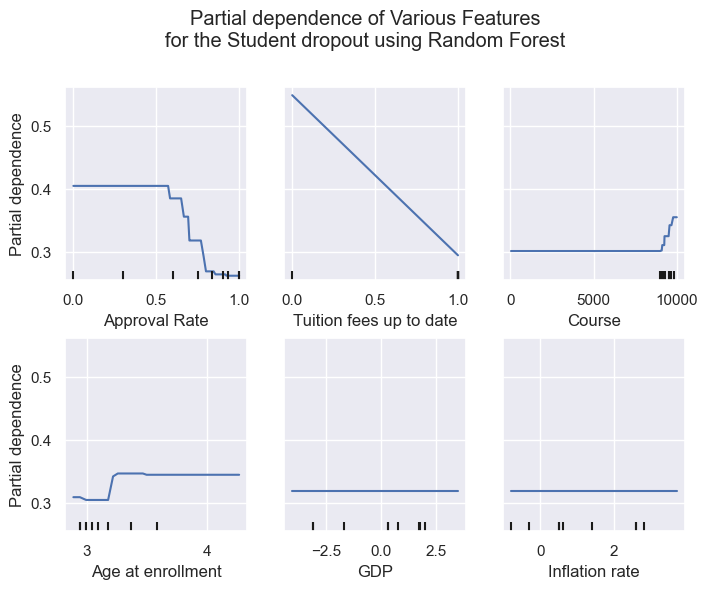

In [268]:
create_pdp(random_gdb_model, x_test, ['Approval Rate', 'Tuition fees up to date', 'Course', 'Age at enrollment', 'GDP', 'Inflation rate'], algo = 'Random Forest')

In [269]:
save_model(grid_gdb_model, 'grid_gdb.pkl')
save_model(random_gdb_model, 'random_gdb.pkl')
save_model(bayes_gdb_model, 'bayes_gdb.pkl')
save_model(pipeline_gdb_tuned, 'manual_gdb.pkl')

Model saved successfully to grid_gdb.pkl
Model saved successfully to random_gdb.pkl
Model saved successfully to bayes_gdb.pkl
Model saved successfully to manual_gdb.pkl


# Catboost Classifier

In [171]:
cat = CatBoostClassifier(
    iterations=500, 
    learning_rate=0.01,silent =True, 
    random_state = 105
)
pipeline_cat = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', cat)  
])

Train Time(s): 21.84018289999949
Training Accuracy:  91.0%

 Model Evaluation Result For the Training Phase 

Test Time(s): 0.01418740000372054
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       595
           1       0.85      0.73      0.79       290

    accuracy                           0.87       885
   macro avg       0.86      0.84      0.85       885
weighted avg       0.87      0.87      0.87       885
 



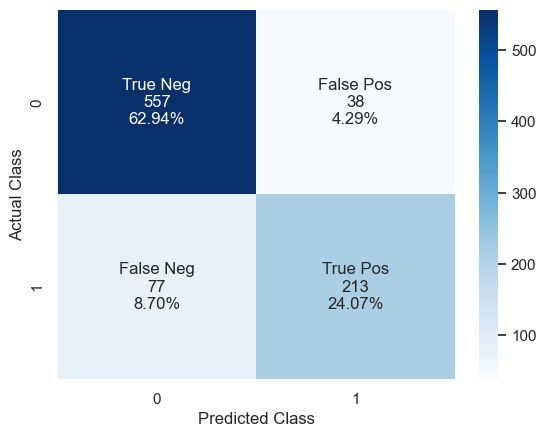

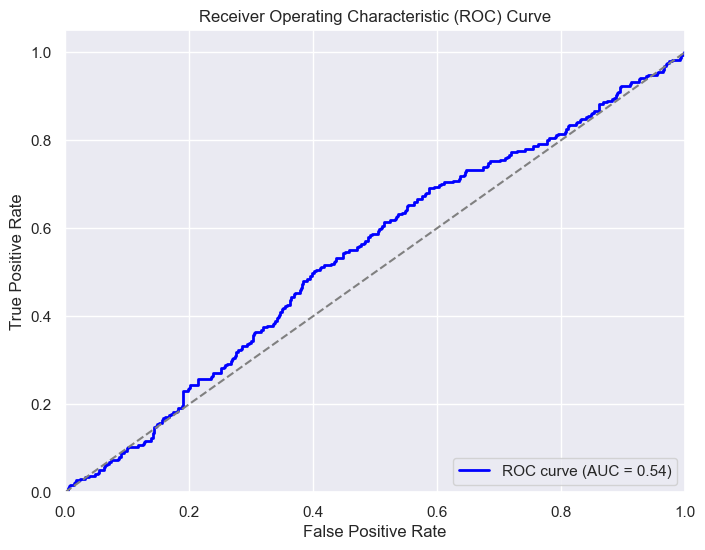

In [172]:
model_training(pipeline_cat, x_train, y_train, x_val, y_val, phase = 'Training')

### Manual Tuning

In [173]:
# Create the pipeline
pipeline_cat_tuned = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('classifier', CatBoostClassifier(iterations = 100, depth = 11, learning_rate = 0.1, random_state = 105, silent = True))  # Step 2: Apply Logistic Regression
])

Train Time(s): 135.86324410000088
Training Accuracy:  100.0%

 Model Evaluation Result For the Training Phase 

Test Time(s): 0.01750239999819314
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       595
           1       0.83      0.74      0.78       290

    accuracy                           0.87       885
   macro avg       0.86      0.83      0.84       885
weighted avg       0.86      0.87      0.86       885
 



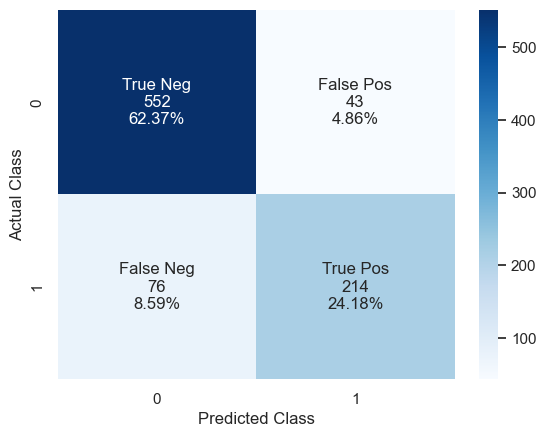

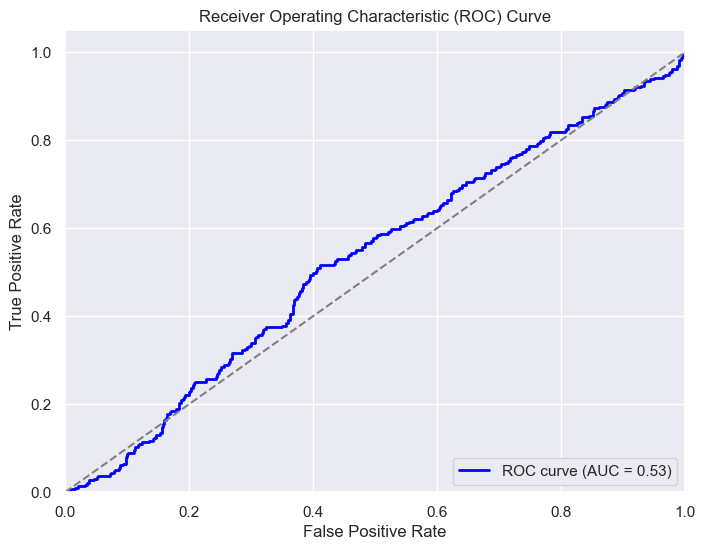

In [174]:
model_training(pipeline_cat_tuned, x_train, y_train, x_val, y_val, phase= 'Training')

In [175]:
#cross_validation(pipeline_cat_tuned, x_eval, y_eval, cv)


 Model Evaluation Result For the Test Phase 

Test Time(s): 0.06593319999956293
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       594
           1       0.87      0.68      0.77       291

    accuracy                           0.86       885
   macro avg       0.86      0.82      0.83       885
weighted avg       0.86      0.86      0.86       885
 



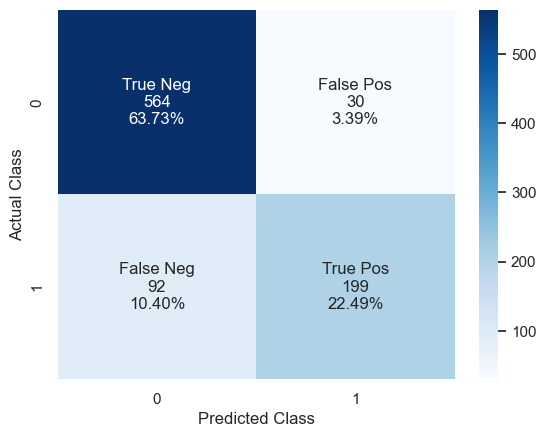

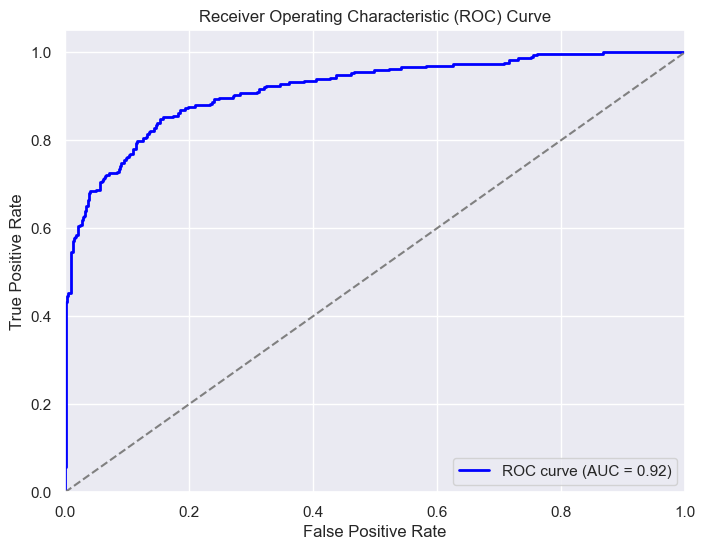

In [176]:
model_evaluation(pipeline_cat_tuned, x_test, y_test, phase = 'Test')

In [177]:
param_grid_cat = {
    'classifier__depth': [2, 3, 5, 7],           # Depth of the trees
    'classifier__learning_rate': [0.001, 0.01, 0.1], # Learning rate
    'classifier__l2_leaf_reg': [1, 2, 3, 4, 5],     # L2 regularization term on weights
    'classifier__border_count': [30, 40, 50],  # Number of splits for features

}


### Random Search

Train Time(s): 4.192460800004483
Training Accuracy:  89.0%

 Model Evaluation Result For the Tuning Phase 

Test Time(s): 0.021346199995605275
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       595
           1       0.83      0.74      0.79       290

    accuracy                           0.87       885
   macro avg       0.86      0.84      0.85       885
weighted avg       0.87      0.87      0.87       885
 



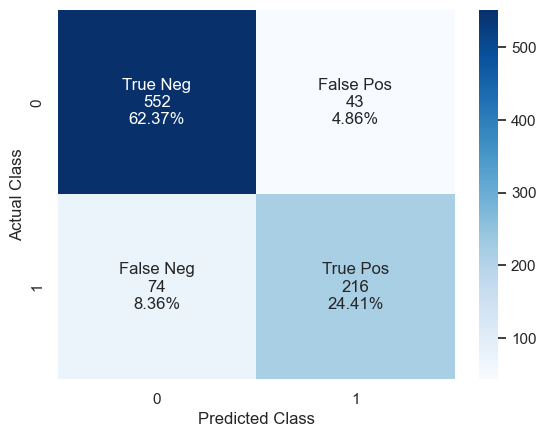

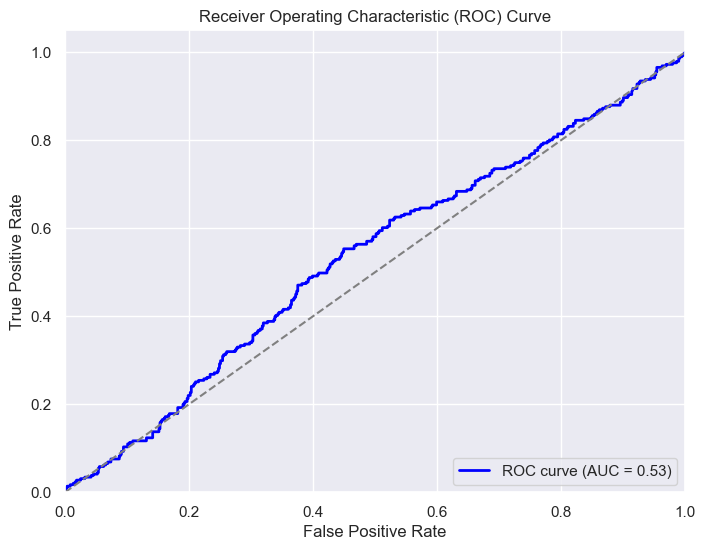

In [178]:
random_cat_params, random_cat_model = random_tuning(clf = pipeline_cat, parameters= param_grid_cat, train_feat = x_train, n_iter = 5, train_labels = y_train, val_feat = x_val, val_labels = y_val, cv = 3, svc = False)

In [179]:
random_cat_params

{'classifier__learning_rate': 0.01,
 'classifier__l2_leaf_reg': 3,
 'classifier__depth': 2,
 'classifier__border_count': 40}

In [180]:
#cross_validation(random_cat_model, x_eval, y_eval, cv)


 Model Evaluation Result For the Test Phase 

Test Time(s): 0.014592500003345776
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       594
           1       0.85      0.68      0.76       291

    accuracy                           0.86       885
   macro avg       0.86      0.81      0.83       885
weighted avg       0.86      0.86      0.85       885
 



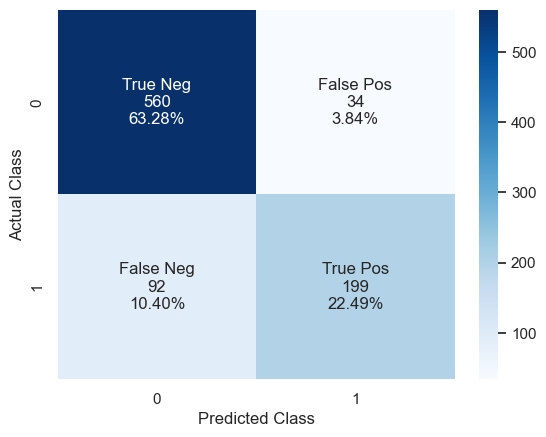

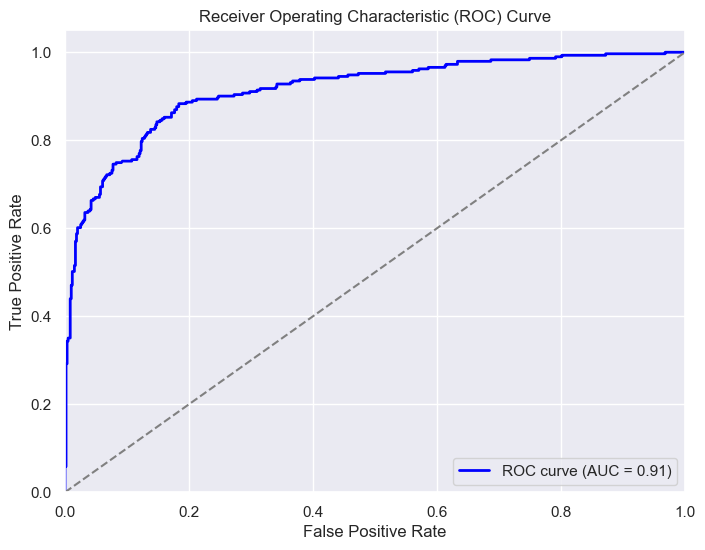

In [181]:
model_evaluation(random_cat_model, x_test, y_test, phase = 'Test')

### Bayes Search

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Train Time(s): 5.269480099996144
Training Accuracy:  89.0%

 Model Evaluation Result For the Tuning Phase 

Test Time(s): 0.01713529999688035
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.88      0.93      0.91       595
           1       0.84      0.74      0.79       290

    accuracy                           0.87       885
   macro avg       0.86      0.8

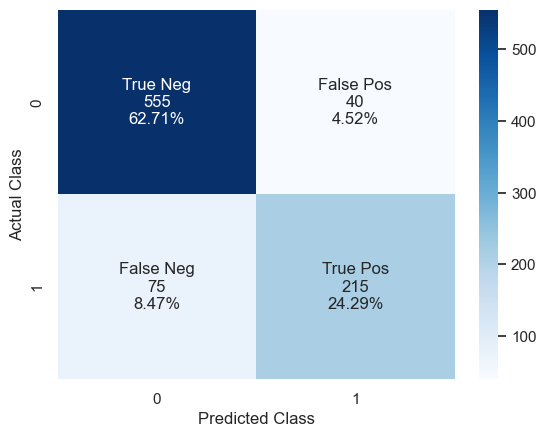

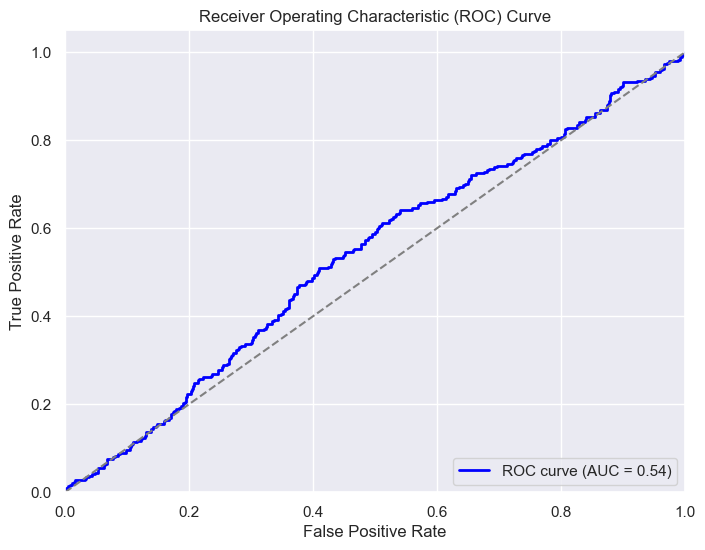

In [182]:
bayes_cat_params, bayes_cat_model = bayes_tuning(clf = pipeline_cat, parameters= param_grid_cat, train_feat = x_train, train_labels = y_train, val_feat = x_val, val_labels = y_val, cv = 3, svc = False)

In [183]:
bayes_gdb_params

OrderedDict([('classifier__max_depth', 3),
             ('classifier__min_samples_split', 7),
             ('classifier__n_estimators', 100),
             ('classifier__subsample', 0.8)])

In [184]:
#cross_validation(bayes_cat_model, x_eval, y_eval, cv)


 Model Evaluation Result For the Test Phase 

Test Time(s): 0.016823700003442355
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       594
           1       0.87      0.69      0.77       291

    accuracy                           0.86       885
   macro avg       0.86      0.82      0.84       885
weighted avg       0.86      0.86      0.86       885
 



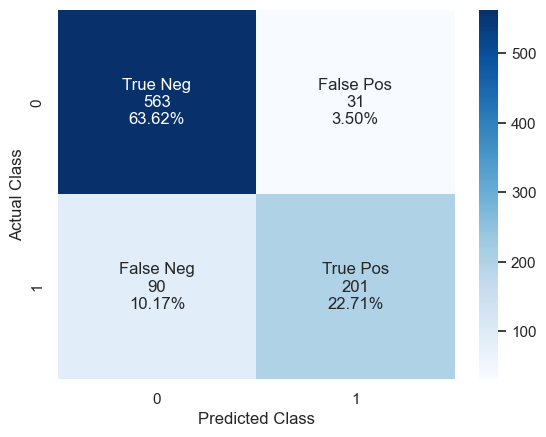

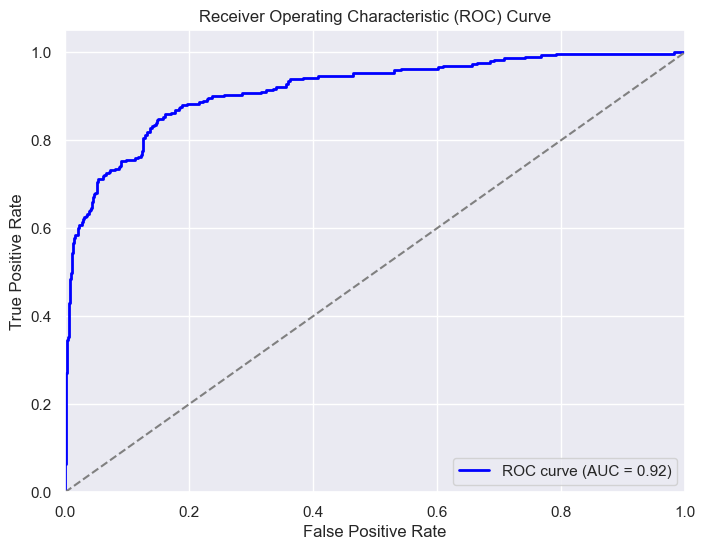

In [185]:
model_evaluation(bayes_cat_model, x_test, y_test, phase = 'Test')

## Feature Importance (Cat)

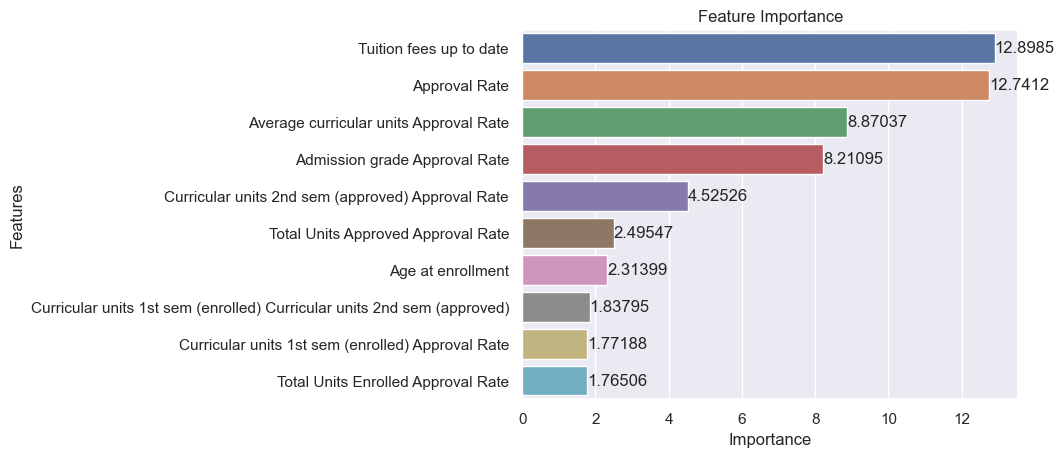

In [186]:
feature_importance(bayes_cat_model)

In [276]:
# shap_values = shap_explanations(bayes_cat_model, x_train, y_train, x_test, x_train.columns)


AttributeError: 'TreeEnsemble' object has no attribute 'values'

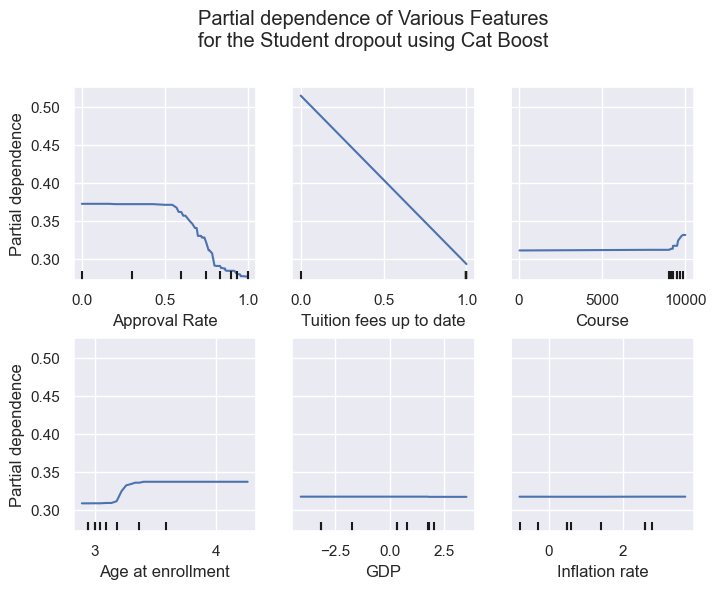

In [280]:
create_pdp(bayes_cat_model, x_test, ['Approval Rate', 'Tuition fees up to date', 'Course', 'Age at enrollment', 'GDP', 'Inflation rate'], algo = 'Cat Boost')

In [278]:
save_model(random_cat_model, 'random_cat.pkl')
save_model(bayes_cat_model, 'bayes_cat.pkl')
save_model(pipeline_cat_tuned, 'manual_cat.pkl')

Model saved successfully to random_cat.pkl
Model saved successfully to bayes_cat.pkl
Model saved successfully to manual_cat.pkl


# Extreme Gradient Boosting Classifier

In [188]:
from xgboost import XGBClassifier

In [189]:
xgb = XGBClassifier(random_state = 105)
pipeline_xgb = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', xgb)  
])

Train Time(s): 4.293244299995422
Training Accuracy:  100.0%

 Model Evaluation Result For the Training Phase 

Test Time(s): 0.020813000002817716
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       595
           1       0.81      0.74      0.77       290

    accuracy                           0.86       885
   macro avg       0.85      0.83      0.84       885
weighted avg       0.86      0.86      0.86       885
 



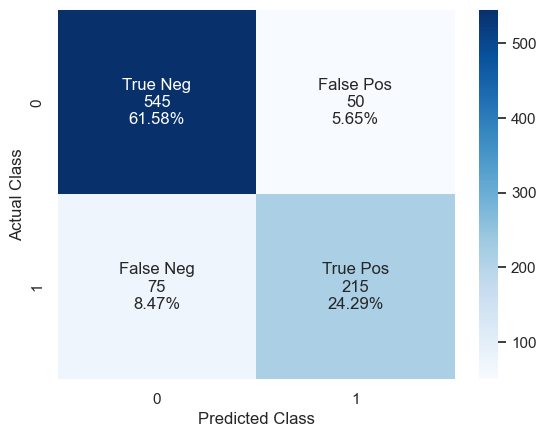

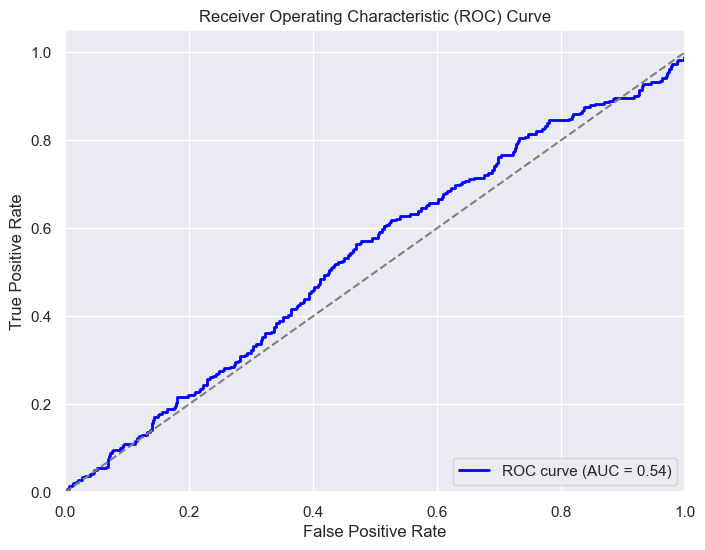

In [190]:
model_training(pipeline_xgb, x_train, y_train, x_val, y_val, phase = 'Training')

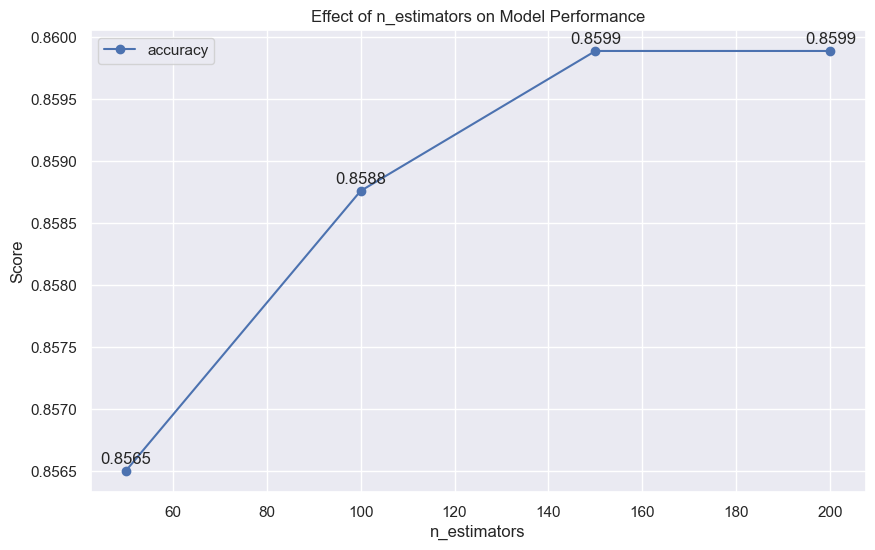

In [191]:
# Define the range of values for the hyperparameter 'max_depth'
param_values = [50, 100, 150, 200]
param_name = 'n_estimators'

# Call the function to evaluate and plot the metrics
evaluate_pipeline_with_metrics(pipeline_xgb, param_name, param_values, x_train, x_val, y_train, y_val, metrics=['accuracy'])

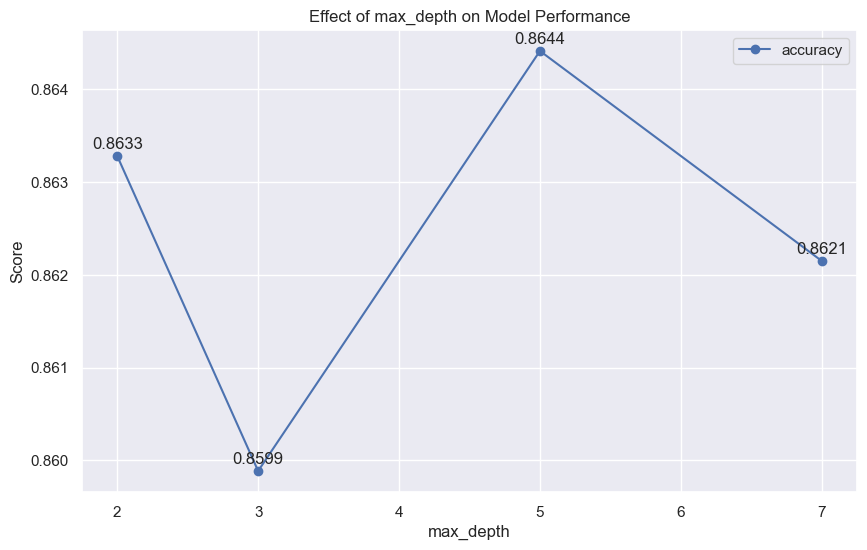

CPU times: total: 0 ns
Wall time: 0 ns


In [192]:
# Define the range of values for the hyperparameter 'max_depth'
param_values = [2, 3, 5, 7]
param_name = 'max_depth'

# Call the function to evaluate and plot the metrics
evaluate_pipeline_with_metrics(pipeline_xgb, param_name, param_values, x_train, x_val, y_train, y_val, metrics=['accuracy'])
%time

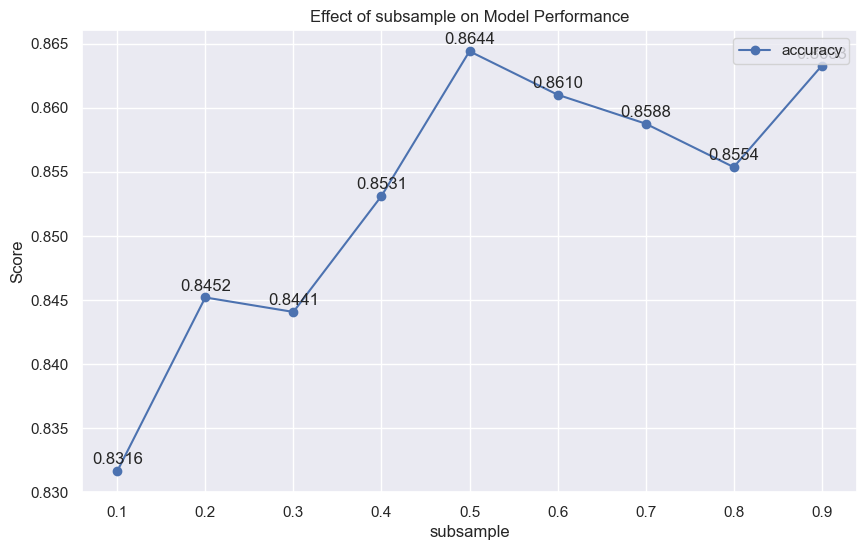

In [193]:
# Define the range of values for the hyperparameter 'min_samples_leaf'
param_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_name = 'subsample'

# Call the function to evaluate and plot the metrics
evaluate_pipeline_with_metrics(pipeline_xgb, param_name, param_values, x_train, x_val, y_train, y_val, metrics=['accuracy'])

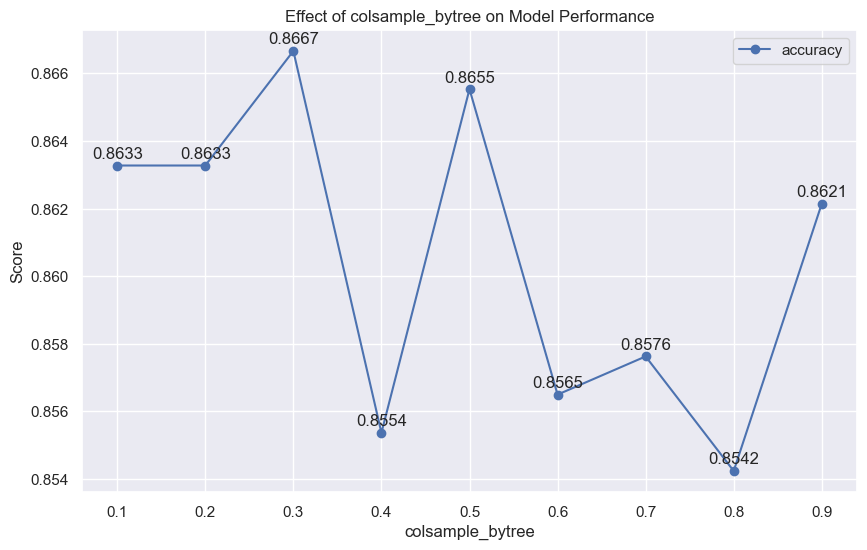

In [194]:
# Define the range of values for the hyperparameter 'min_samples_leaf'
param_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_name = 'colsample_bytree'

# Call the function to evaluate and plot the metrics
evaluate_pipeline_with_metrics(pipeline_xgb, param_name, param_values, x_train, x_val, y_train, y_val, metrics=['accuracy'])

### Manual Tuning

In [195]:
# Create the pipeline
pipeline_xgb_tuned = Pipeline([
    ('scaler', MinMaxScaler()),  # Step 1: Scale features to a range (0, 1)
    ('classifier', XGBClassifier(n_estimators = 150, max_depth = 7, subsample = 0.5, colsample_bytree = 0.3, random_state = 105))  # Step 2: Apply Logistic Regression
])

Train Time(s): 2.306564399994386
Training Accuracy:  100.0%

 Model Evaluation Result For the Training Phase 

Test Time(s): 0.027167699998244643
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       595
           1       0.84      0.74      0.78       290

    accuracy                           0.87       885
   macro avg       0.86      0.83      0.84       885
weighted avg       0.87      0.87      0.86       885
 



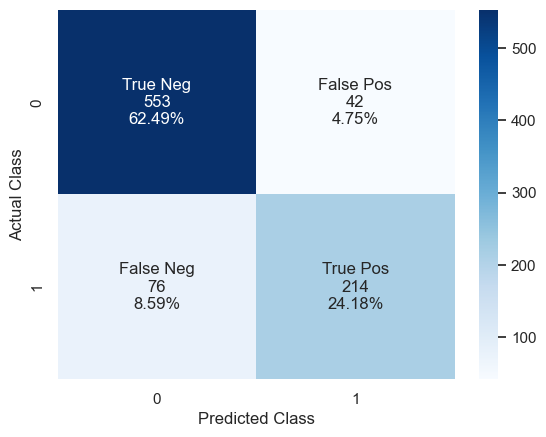

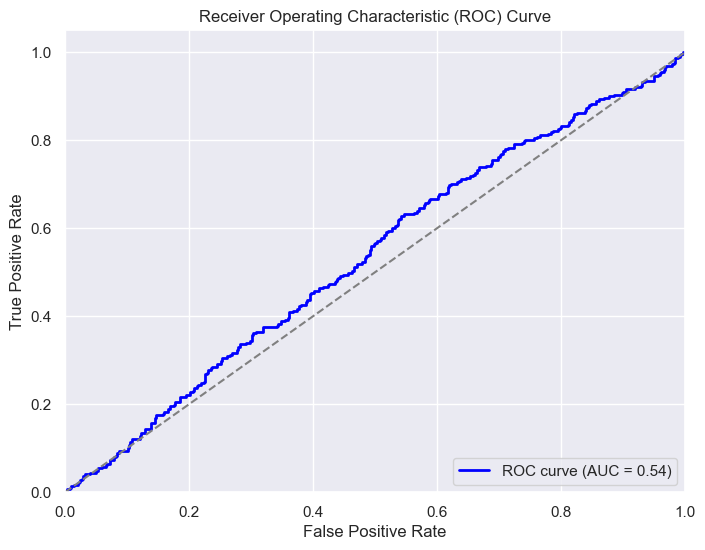

In [196]:
model_training(pipeline_xgb_tuned, x_train, y_train, x_val, y_val, phase= 'Training')

In [197]:
#cross_validation(pipeline_gdb_tuned, x_eval, y_eval, cv)


 Model Evaluation Result For the Test Phase 

Test Time(s): 0.01675979999708943
Accuracy:  85.0%

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       594
           1       0.83      0.69      0.76       291

    accuracy                           0.85       885
   macro avg       0.85      0.81      0.83       885
weighted avg       0.85      0.85      0.85       885
 



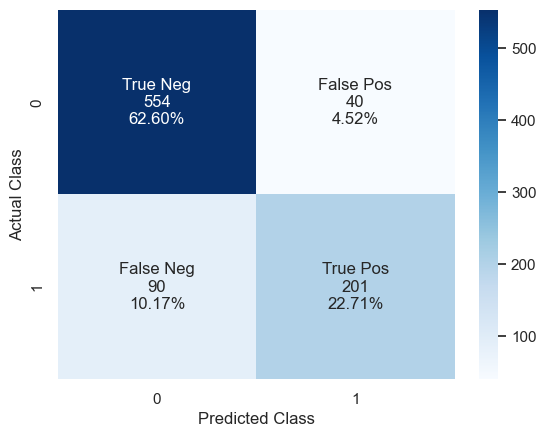

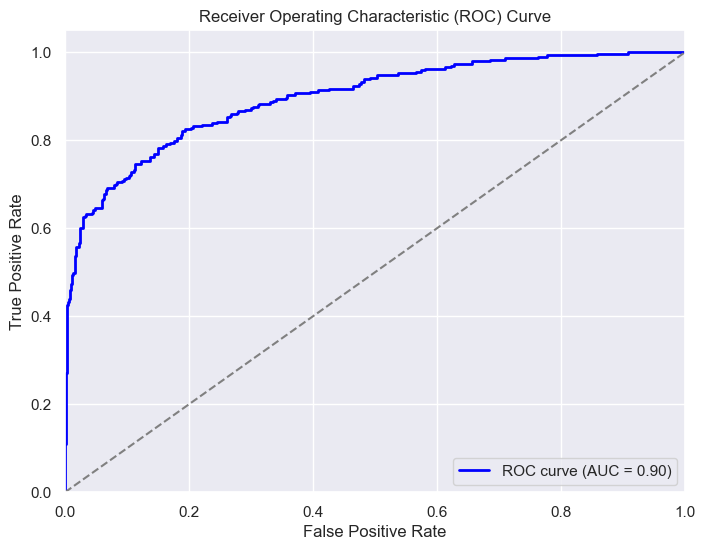

In [198]:
model_evaluation(pipeline_xgb_tuned, X_te = x_test, y_te = y_test, phase = 'Test')

### Grid Search

Fitting 2 folds for each of 54 candidates, totalling 108 fits
[05:32:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

[05:32:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

Train Time(s): 0.5689429000049131
Training Accuracy:  91.0%

 Model Evaluation Result For the Tuning Phase 

Test Time(s): 0.018031200001132675
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       595
           1       0.83      0.75      0.79       290

    accuracy                           0.87       885
   macro avg       0.86      0.84      0.85       885
weighted avg       0.87      0.87      0.87       885
 



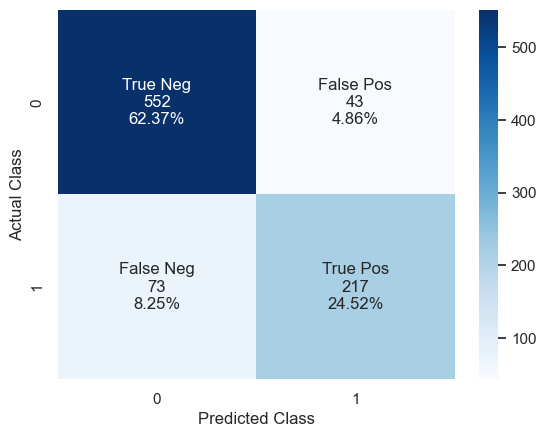

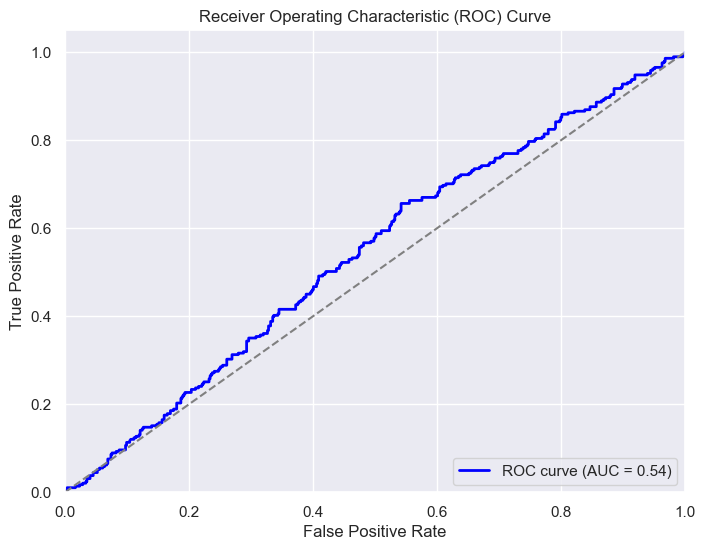

In [199]:
param_grid_xgb = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__subsample': [0.7, 0.8, 0.9],
    'classifier__colsample_bytree': [0.7, 0.8, 1.0],
}

grid_xgb_params, grid_xgb_model = grid_tuning(pipeline_xgb, parameters = param_grid_gdb, train_feat = x_train,
                              train_labels = y_train, val_feat = x_val, val_labels = y_val, cv = 2)

In [200]:
grid_xgb_params

{'classifier__max_depth': 2,
 'classifier__min_samples_split': 5,
 'classifier__n_estimators': 50,
 'classifier__subsample': 0.9}

In [201]:
#cross_validation(grid_gdb_model, x_eval, y_eval, cv)


 Model Evaluation Result For the Test Phase 

Test Time(s): 0.016860199997609016
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       594
           1       0.85      0.70      0.77       291

    accuracy                           0.86       885
   macro avg       0.86      0.82      0.83       885
weighted avg       0.86      0.86      0.86       885
 



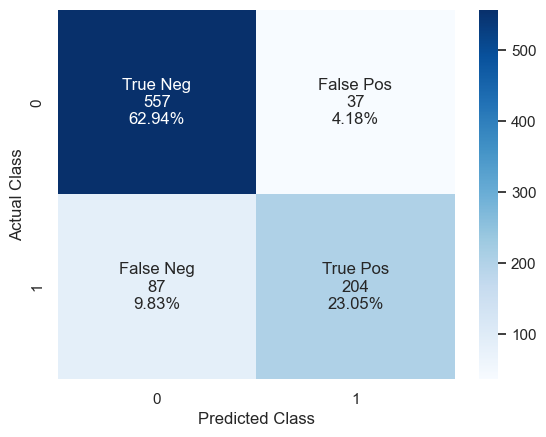

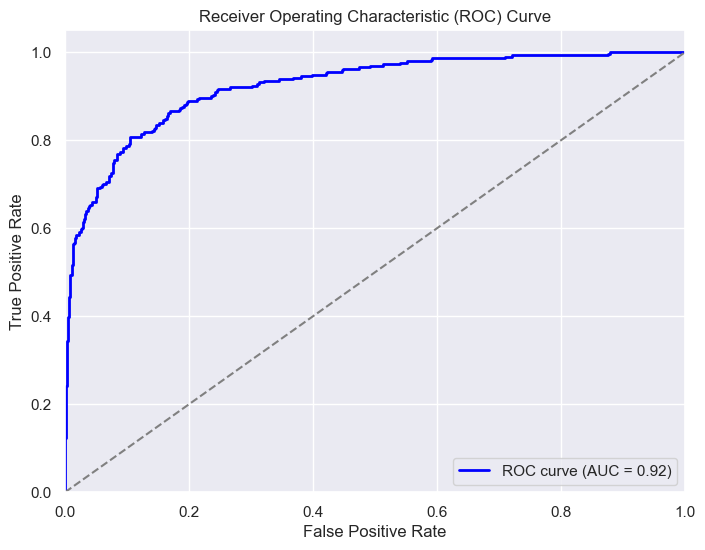

In [202]:
model_evaluation(grid_xgb_model, X_te = x_test, y_te = y_test, phase = 'Test')

### Random Search

Train Time(s): 0.9191684000034002
Training Accuracy:  94.0%

 Model Evaluation Result For the Tuning Phase 

Test Time(s): 0.016702300003089476
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       595
           1       0.83      0.74      0.78       290

    accuracy                           0.86       885
   macro avg       0.85      0.83      0.84       885
weighted avg       0.86      0.86      0.86       885
 



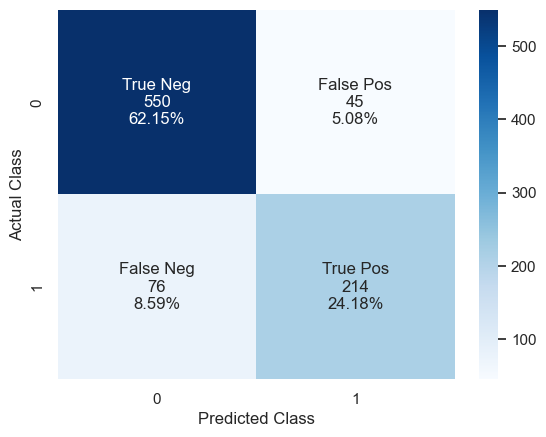

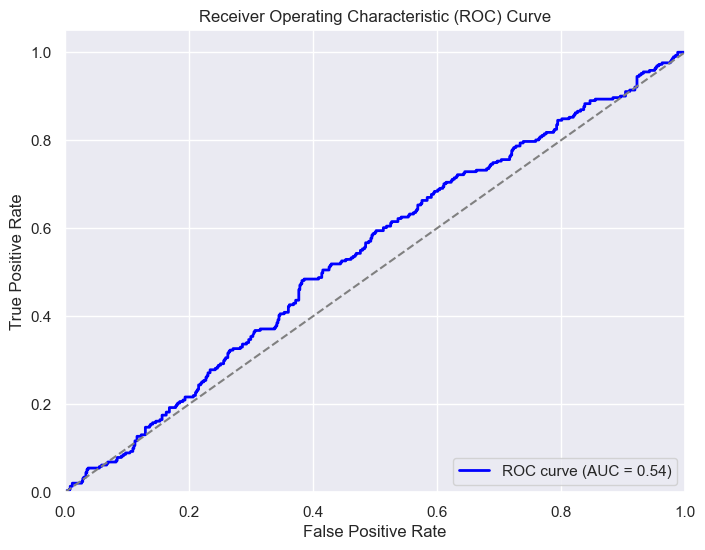

In [203]:
random_xgb_params, random_xgb_model = random_tuning(clf = pipeline_xgb, parameters= param_grid_xgb, train_feat = x_train, n_iter = 5, train_labels = y_train, val_feat = x_val, val_labels = y_val, cv = 3, svc = False)

In [204]:
random_xgb_params

{'classifier__subsample': 0.9,
 'classifier__n_estimators': 50,
 'classifier__max_depth': 3,
 'classifier__colsample_bytree': 1.0}

In [205]:
#cross_validation(random_gdb_model, x_eval, y_eval, cv)


 Model Evaluation Result For the Test Phase 

Test Time(s): 0.0168753000034485
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       594
           1       0.84      0.72      0.77       291

    accuracy                           0.86       885
   macro avg       0.86      0.83      0.84       885
weighted avg       0.86      0.86      0.86       885
 



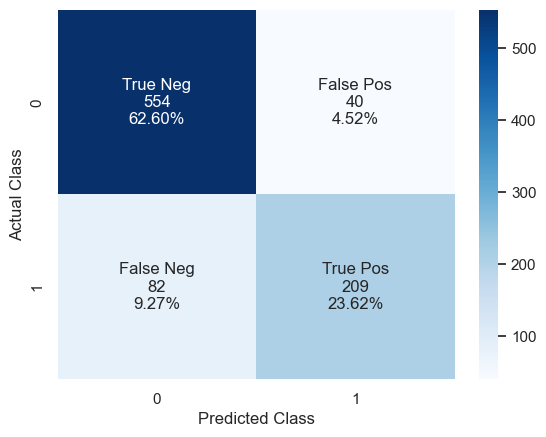

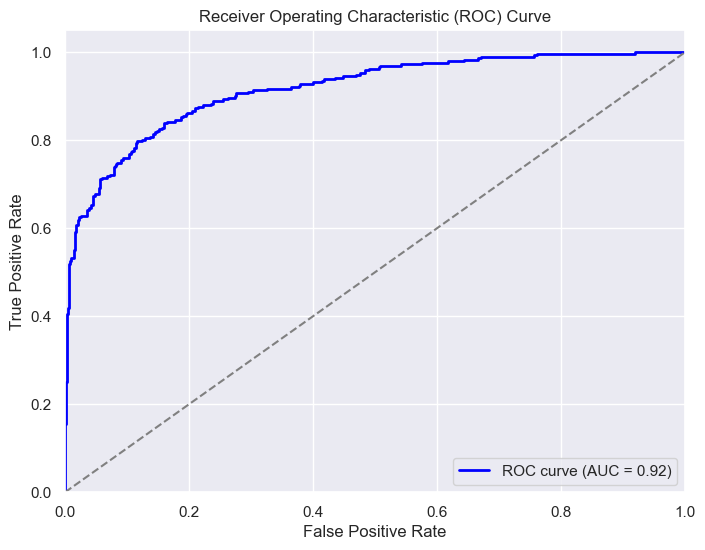

In [206]:
model_evaluation(random_xgb_model, x_test, y_test, phase = 'Test')

### Bayes Search

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Train Time(s): 4.009150699996098
Training Accuracy:  100.0%

 Model Evaluation Result For the Tuning Phase 

Test Time(s): 0.020126399998844136
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       595
           1       0.82      0.73      0.77       290

    accuracy                           0.86       885
   macro avg       0.85      0

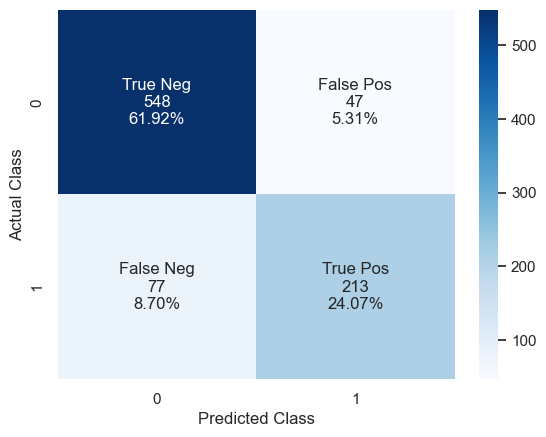

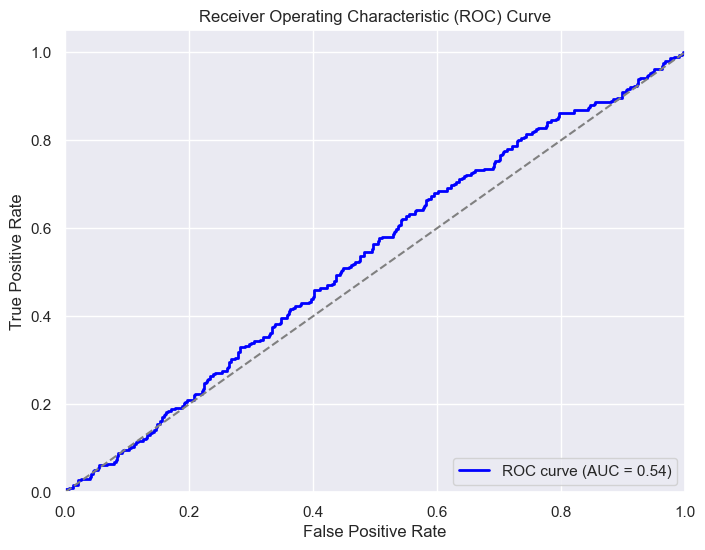

In [207]:
bayes_xgb_params, bayes_xgb_model = bayes_tuning(clf = pipeline_xgb, parameters= param_grid_xgb, train_feat = x_train, train_labels = y_train, val_feat = x_val, val_labels = y_val, cv = 3, svc = False)

In [208]:
bayes_xgb_params

OrderedDict([('classifier__colsample_bytree', 1.0),
             ('classifier__max_depth', 7),
             ('classifier__n_estimators', 100),
             ('classifier__subsample', 0.8)])

In [209]:
#cross_validation(bayes_gdb_model, x_eval, y_eval, cv)


 Model Evaluation Result For the Test Phase 

Test Time(s): 0.013119300005200785
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       594
           1       0.85      0.68      0.76       291

    accuracy                           0.86       885
   macro avg       0.85      0.81      0.83       885
weighted avg       0.86      0.86      0.85       885
 



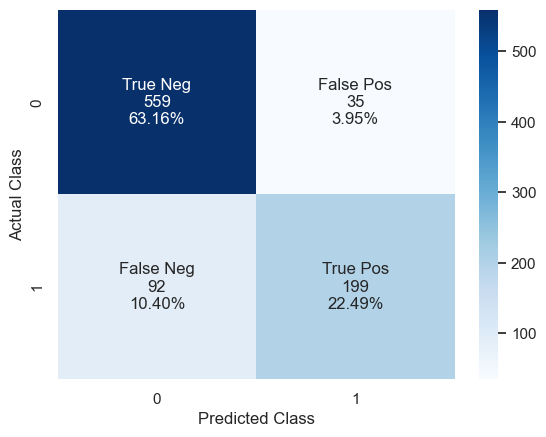

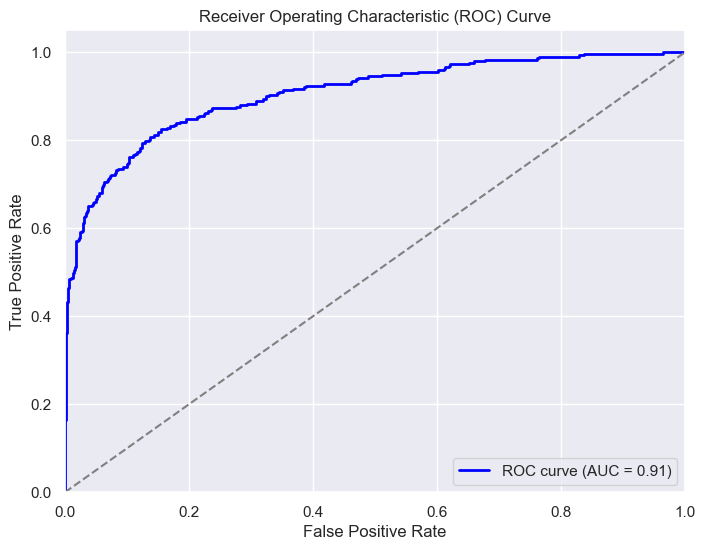

In [210]:
model_evaluation(bayes_xgb_model, x_test, y_test, phase = 'Test')

## Feature Importance (Xgb)

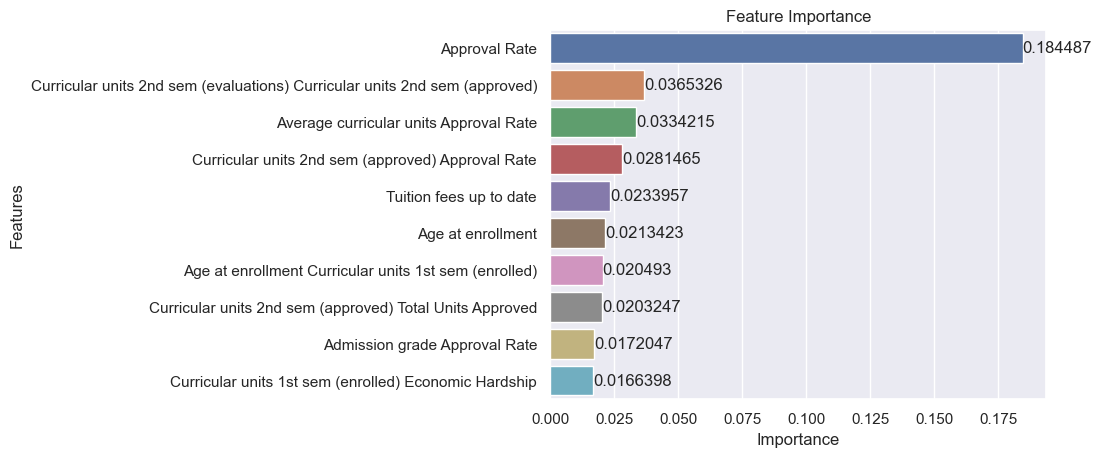

In [211]:
feature_importance(random_xgb_model)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


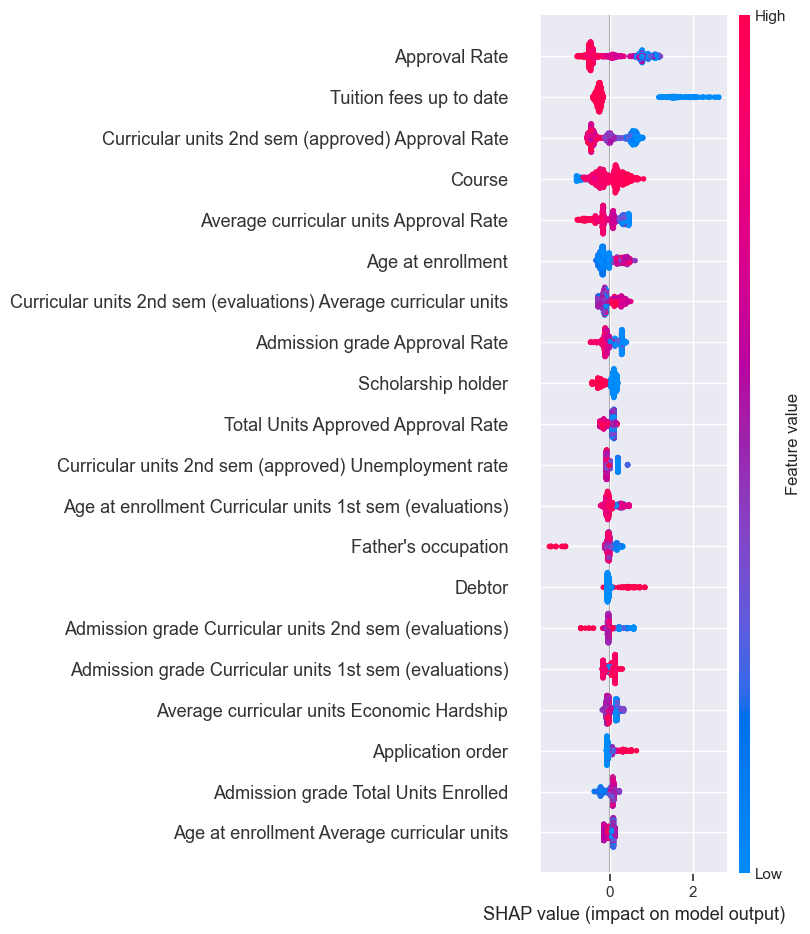

In [279]:
shap_values = shap_explanations(random_xgb_model, x_train, y_train, x_test, x_train.columns)


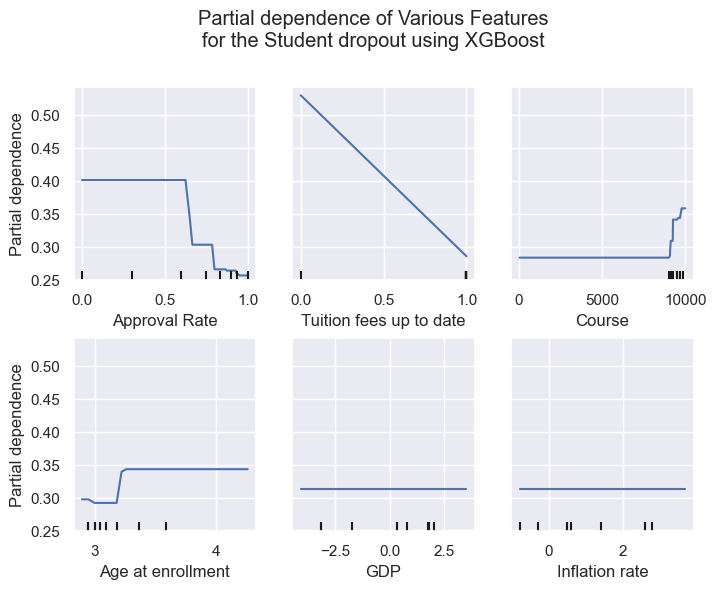

In [281]:
create_pdp(random_xgb_model, x_test, ['Approval Rate', 'Tuition fees up to date', 'Course', 'Age at enrollment', 'GDP', 'Inflation rate'], algo = 'XGBoost')

In [282]:
save_model(grid_xgb_model, 'grid_xgb.pkl')
save_model(random_xgb_model, 'random_xgb.pkl')
save_model(bayes_xgb_model, 'bayes_xgb.pkl')
save_model(pipeline_xgb_tuned, 'manual_xgb.pkl')

Model saved successfully to grid_xgb.pkl
Model saved successfully to random_xgb.pkl
Model saved successfully to bayes_xgb.pkl
Model saved successfully to manual_xgb.pkl


# Stacking Classifier

In [213]:
from sklearn.ensemble import StackingClassifier

In [214]:
estimators = [
    ('cat', bayes_cat_model),
    ('log', best_log_model),
    ('svc', bayes_svc_model)
]
stack_clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(random_state = 207)
)

Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


Train Time(s): 231.60518890000094
Training Accuracy:  89.0%

 Model Evaluation Result For the Training Phase 

Test Time(s): 0.15266879999398952
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       595
           1       0.84      0.72      0.78       290

    accuracy                           0.86       885
   macro avg       0.86      0.83      0.84       885
weighted avg       0.86      0.86      0.86       885
 



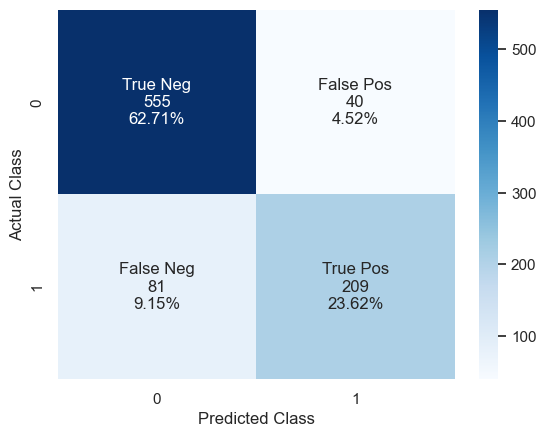

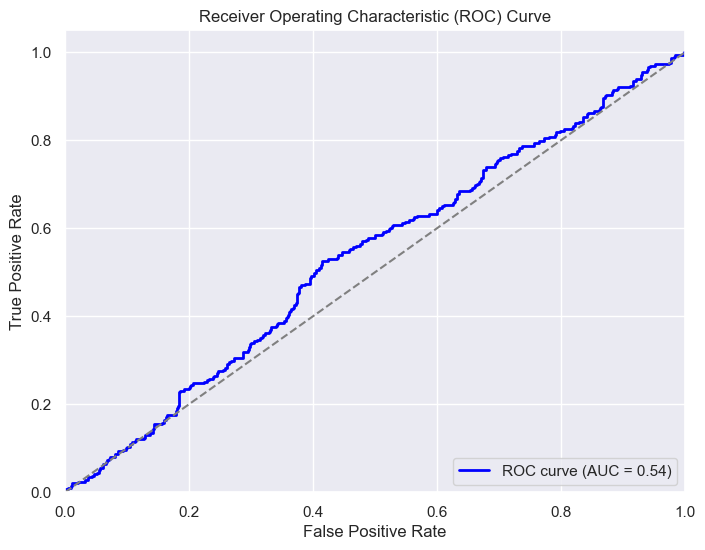

In [215]:
model_training(stack_clf, x_train, y_train, x_val, y_val, phase= 'Training')


 Model Evaluation Result For the Test Phase 

Test Time(s): 0.16654130000097211
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       594
           1       0.88      0.71      0.79       291

    accuracy                           0.87       885
   macro avg       0.87      0.83      0.85       885
weighted avg       0.87      0.87      0.87       885
 



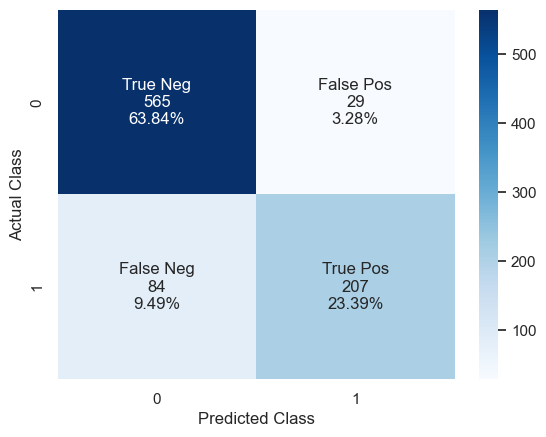

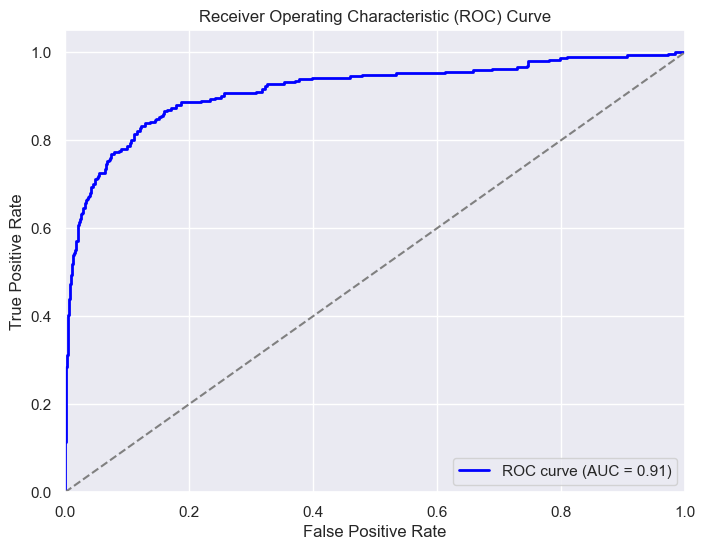

In [216]:
model_evaluation(stack_clf, x_test, y_test, phase = 'Test')

In [284]:
# shap_values = shap_explanations(stack_clf, x_train, y_train, x_test, x_train.columns)

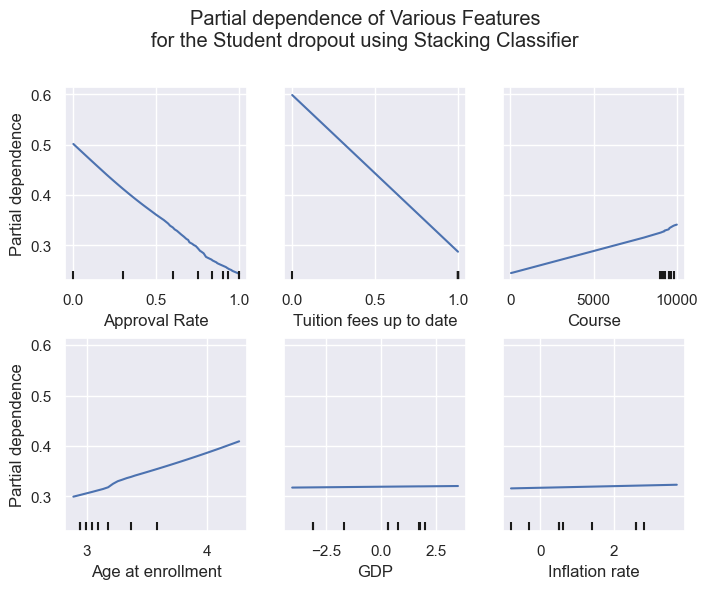

In [286]:
create_pdp(stack_clf, x_test, ['Approval Rate', 'Tuition fees up to date', 'Course', 'Age at enrollment', 'GDP', 'Inflation rate'], algo = 'Stacking Classifier')

In [287]:
save_model(stack_clf, 'stack_clf.pkl')

Model saved successfully to stack_clf.pkl


# Blending Ensemble

In [293]:
from numpy import hstack
def get_models():
    models = [('cat', bayes_cat_model),
    ('log', best_log_model),
    ('svc', bayes_svc_model)
    ]
    return models

def fit_ensemble(models, X_train, X_val, y_train, y_val):
    meta_X = list()
    for name, model in models:
        X_train = pipeline_log.named_steps['scaler'].transform(X_train)
        X_val = pipeline_log.named_steps['scaler'].transform(X_val)
        # fit in training set
        model.fit(X_train, y_train)
        # predict on hold out set
        yhat = model.predict(X_val)
        # reshape predictions into a matrix with one column
        yhat = yhat.reshape(len(yhat), 1)
        # store predictions as input for blending
        meta_X.append(yhat)
    # create 2d array from predictions, each set is an input feature
    meta_X = hstack(meta_X)
    # define blending model
    blender = LogisticRegression()
    # fit on predictions from base models
    blender.fit(meta_X, y_val)
    return blender
def predict_ensemble(models, blender, X_test):
    # make predictions with base models
    meta_X = list()
    for name, model in models:
        X_test = pipeline_log.named_steps['scaler'].transform(X_test)
        # predict with base model
        yhat = model.predict(X_test)

        yhat = yhat.reshape(len(yhat), 1)
        # store prediction
        meta_X.append(yhat)
    # create 2d array from predictions, each set is an input feature
    meta_X = hstack(meta_X)
    # predict
    return blender.predict(meta_X)
def evaluate_ensemble(y_te, pred_class):
    
    accuracy = accuracy_score(y_te, pred_class)
    
    report = classification_report(y_te, pred_class)
    
    print('Accuracy:  {}%\n'.format(round(accuracy, 2)*100))
    
    print(report, '\n')
    
    cf_matrix = confusion_matrix(y_te, pred_class)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(
        value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(
        group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()
    

 


X does not have valid feature names, but MinMaxScaler was fitted with feature names
X does not have valid feature names, but MinMaxScaler was fitted with feature names
X does not have valid feature names, but MinMaxScaler was fitted with feature names
X does not have valid feature names, but MinMaxScaler was fitted with feature names
Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
X does not have valid feature names, but MinMaxScaler was fitted with feature names
X does not have valid feature names, but MinMaxScaler was fitted with feature names


Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.86      0.96      0.90       594
           1       0.89      0.67      0.76       291

    accuracy                           0.86       885
   macro avg       0.87      0.81      0.83       885
weighted avg       0.87      0.86      0.86       885
 



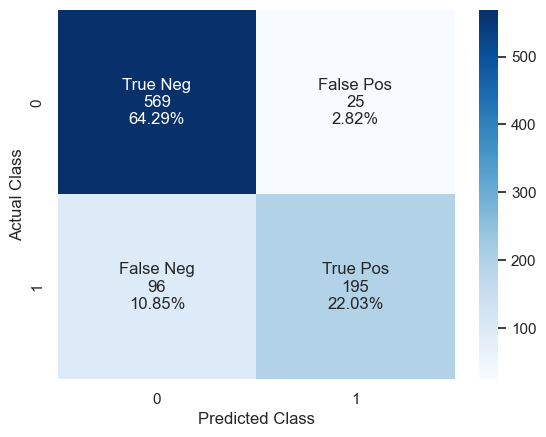

In [294]:
# create the base models
models = get_models()
# train the blending ensemble
blender = fit_ensemble(models, x_train, x_val, y_train, y_val)
# make predictions on test set
yhat = predict_ensemble(models, blender, x_test)
# evaluate predictions
evaluate_ensemble(y_test, yhat)

# Majority Voting

In [219]:
from sklearn.ensemble import VotingClassifier

Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


Train Time(s): 28.345580100001825
Training Accuracy:  89.0%

 Model Evaluation Result For the Training Phase 

Test Time(s): 0.11183509999682428
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.87      0.94      0.90       595
           1       0.85      0.72      0.78       290

    accuracy                           0.86       885
   macro avg       0.86      0.83      0.84       885
weighted avg       0.86      0.86      0.86       885
 



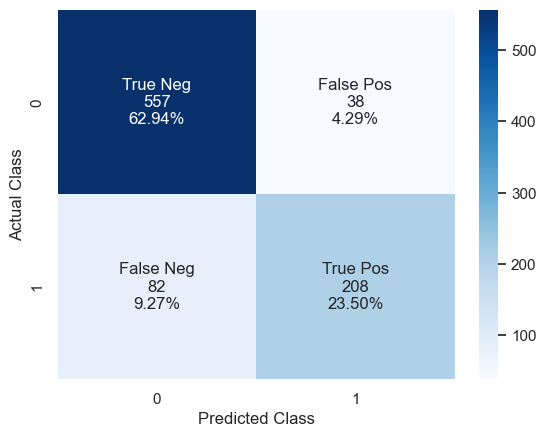

In [220]:
mv_clf = VotingClassifier(estimators = estimators)
model_training(mv_clf, x_train, y_train, x_val, y_val, phase= 'Training', mv = True)

In [299]:
save_model(mv_clf, 'Majority_voting_clf.pkl')

Model saved successfully to Majority_voting_clf.pkl
